- With this approach, we attempted to use BERT-annotated screenplay data to help with preprocessing. 
- The idea was to then build our own BERT to annotate new screenplay text data. 
- The approach was unfortunately not ready for deployment by the deadline. 

# 0. Import Data and Dependencies

# 0.0 Packages and Dependencies

In [1]:
import numpy as np
import pandas as pd
import os 
import re
import gdown
import zipfile
import shutil

## 0.1 Notebook Functions

In [ ]:
def print_first_lines(dict_list, n):
    for idx, d in enumerate(dict_list):
        if idx == n:
            break
        else:
            print(d)

In [ ]:
def find_avg_length(series):
    avg_length = np.mean([len(d) for d in series])
    print("Average length:", avg_length)

In [ ]:
def format_as_json(screenplay):
    # store results as list of key-value pairs
    screenplay_data = []
    # split screenplays by \n
    lines = screenplay.split("\n")
    # iterate through lines 
    for line in lines: 
        # take part of string up to : as label
        match = re.search(r':', line)
        if match:
            # take end of match as cutoff
            cutoff = match.end()
            label = line[:cutoff-1]
            # after cutoff is data 
            data = line[cutoff+1:]
            # store as dict
            line_info = {label:data}
            # append to list
            screenplay_data.append(line_info)
    # return list
    return screenplay_data

## 0.2 Download Datafiles 

In [ ]:
ZIP_ID = r'1fCZF5SgtiuKENLxA9wOfunsskqUQ3t4G'
gdrive_url = f'https://drive.google.com/uc?id={ZIP_ID}'
output_path = 'archive.zip'
output_folder_path = "archive"
extract_to_folder = "c:\\temp_extract"

Extracts and downlaods a ZIP file containing everything needed to run the notebook. 

In [ ]:
def extract_zip(zip_file_path, extract_to):
    # Extract the zip file if it exists and is valid
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
            print(f"Extracted all files to {extract_to}")
    except FileNotFoundError:
        print(f"Error: File {zip_file_path} does not exist.")
    except zipfile.BadZipFile:
        print("Error: The file is not a valid zip file.")
    except Exception as e:
        print(f"An error occurred: {e}")

def download_and_extract(gdrive_url, output_path, extract_to_folder, output_folder_path):
    # Download the file
    try:
        gdown.download(gdrive_url, output_path, quiet=False)
        print(f"File downloaded and saved as {output_path}")
        
        # Extract the downloaded zip file
        extract_zip(output_path, extract_to_folder)

        # Move the extracted folder and clean up
        shutil.move(extract_to_folder, output_folder_path)
        os.remove(output_path)
        print(f"Moved extracted files to {output_folder_path} and removed {output_path}")
    except Exception as e:
        print(f"An error occurred during the download or extraction process: {e}")

download_and_extract(gdrive_url, output_path, extract_to_folder, output_folder_path)

: 

In [7]:
texts_path = os.path.join(output_folder_path, 'final_zip', 'BERT_annotations')
screenplays_annot = {}

hex_pat = re.compile(r'[\x00-\x1F\x7F-\x9F]')

# list all files in folder and iterate over them 
for file_name in os.listdir(texts_path):
    # get file_path by joining folder path with file_name
    file_path = os.path.join(texts_path, file_name)
    # ensure path points to an actual file
    if os.path.isfile(file_path):
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()
            # remove non-printable non-ASCII chars
            cleaned_content = re.sub(hex_pat, '', content)
            # assign content to its file_name
            screenplays_annot[file_name] = content

# ensure files were imported correctly by printing a sample of the first ten files 
i = 0
for file_name, content in screenplays_annot.items():
    if i == 10:
        break
    else:
        print(f"Example of {file_name}:\n")
        print(content[:100])
        print("-"*50)
        i += 1

Example of 10 Cloverfield Lane_1179933_anno.txt:

dialog: The Cellar
dialog: by
dialog: Josh Campbell & Matt Stuecken
speaker_heading: DARKNESS
dialog
--------------------------------------------------
Example of 10 Things I Hate About You_0147800_anno.txt:

dialog: 
text: TEN THINGS I HATE ABOUT YOU
dialog: 
dialog: written by Karen McCullah Lutz &amp; Kir
--------------------------------------------------
Example of 12 Angry Men_0118528_anno.txt:

scene_heading: PLEASE COPY AND RETURN |
dialog: ———_————_
dialog: 
scene_heading: TWELVE ANGRY MEN
d
--------------------------------------------------
Example of 12 Monkeys_0114746_anno.txt:

dialog: 
speaker_heading: TWELVE MONKEYS
dialog: 
dialog: An original screenplay by
dialog: David Pe
--------------------------------------------------
Example of 12 Years a Slave_2024544_anno.txt:

dialog: 
speaker_heading: 12 YEARS A SLAVE
dialog: Written by
dialog: John Ridley
speaker_heading: C
--------------------------------------------------
Ex

Check for unprintable non-ASCII characters.

In [8]:
# search values of screenplays_annot for data corruption pattern 
corruptions = set()
for val in screenplays_annot.values():
    corrupted = re.findall(hex_pat, repr(val))
    for c in corrupted:
        corruptions.add(c)

print(corruptions)

set()


In [9]:
# find names of screenpay with hexademical chars 
counter = 0
for key, val in screenplays_annot.items():
    if re.search(hex_pat, repr(val)):
        print(key)
        counter += 1

print(f"{counter} files contain hexadecimal chars")

0 files contain hexadecimal chars


## 0.3 Assemble DataFrame

In [10]:
import os

meta_path = os.path.join(output_folder_path, 'final_zip', 'movie_meta_data.csv')

if os.path.exists(meta_path):
    meta_df = pd.read_csv(meta_path)
    print(meta_df.columns)
else:
    print(f"File {meta_path} does not exist.")

meta_df.head()


Index(['imdbid', 'title', 'akas', 'year', 'metascore', 'imdb user rating',
       'number of imdb user votes', 'awards', 'opening weekend', 'producers',
       'budget', 'script department', 'production companies', 'writers',
       'directors', 'casting directors', 'cast', 'countries', 'age restrict',
       'plot', 'plot outline', 'keywords', 'genres', 'taglines', 'synopsis'],
      dtype='object')


,imdbid,title,akas,year,metascore,imdb user rating,number of imdb user votes,awards,opening weekend,producers,...,casting directors,cast,countries,age restrict,plot,plot outline,keywords,genres,taglines,synopsis
0,120770,A Night at the Roxbury,"Une nuit au Roxbury (France), Movida en el Rox...",1998,26,6,56537,NaN,United States:,"Marie Cantin, Erin Fraser, Amy Heckerling, Ste...",...,Jeff Greenberg,"Will Ferrell, Chris Kattan, Raquel Gardner, Vi...",United States,"Argentina:13, Australia:M, Brazil:14, Canada:P...",Two dim-witted brothers dream of owning their ...,"The Roxbury Guys, Steve and Doug Butabi, want ...","woman-on-top, nightclub, car-accident, 1990s, ...","Comedy, Music, Romance",Score!,NaN
1,132512,At First Sight,"Sight Unseen (United States), Premier regard (...",1999,40,6,12922,NaN,United States:,"Rob Cowan, Roger Paradiso, Irwin Winkler",...,"Kerry Barden, Billy Hopkins, Suzanne Smith","Val Kilmer, Mira Sorvino, Kelly McGillis, Stev...",United States,"Argentina:13, Australia:M, Canada:PG::(Alberta...",A blind man has an operation to regain his sig...,First Sight is true to the title from start to...,"visual-agnosia, brother-sister-relationship, r...","Drama, Romance","Only Love Can Bring You To Your Senses., Scien...",NaN
2,118661,The Avengers,"Chapeau melon et bottes de cuir (France), Mit ...",1998,12,3,40784,"FMCJ Award 1998, Golden Reel Award 1999, Razzi...","United States: $10,305,957, 16 Aug 1998","Susan Ekins, Jerry Weintraub",...,Susie Figgis,"Ralph Fiennes, Uma Thurman, Sean Connery, Patr...",United States,"Argentina:13, Australia:PG, Brazil:10, Canada:...",Two British Agents team up to stop Sir August ...,"British Ministry Agent John Steed, under direc...","good-versus-evil, heroine, evil-man, villain, ...","Action, Adventure, Sci-Fi, Thriller","Mrs. Peel, we're needed., Extraordinary crimes...",NaN
3,215545,Bamboozled,"The Very Black Show (France), It's Showtime (G...",2000,54,6,10373,"Golden Berlin Bear 2001, Black Reel 2001, Imag...",United States:,"Jon Kilik, Spike Lee, Kisha Imani Cameron",...,Aisha Coley,"Damon Wayans, Savion Glover, Jada Pinkett Smit...",United States,"Australia:MA, Finland:K-15, France:Tous public...",A frustrated African-American TV writer propos...,"Dark, biting satire of the television industry...","television-industry, african-american, referen...","Comedy, Drama, Music",Starring the great negroe actors,"In a New York City residence, Pierre Delacroix..."
4,118715,The Big Lebowski,"El gran Lebowski (Spain), O Grande Lebowski (P...",1998,71,8,724388,"Honorable Mention 1998, ACCA 1998, Golden Berl...","United States: $5,533,844, 08 Mar 1998","Tim Bevan, John Cameron, Ethan Coen, Eric Fell...",...,John S. Lyons,"Jeff Bridges, John Goodman, Julianne Moore, St...","United States, United Kingdom","Argentina:16, Argentina:18::(cable rating), Au...","Jeff ""The Dude"" Lebowski, mistaken for a milli...","When ""the dude"" Lebowski is mistaken for a mil...","rug, nihilism, pornographer, bowling-alley, de...","Comedy, Crime, Sport",Hay quienes tratan de ganarse la vida sin move...,A tumbleweed rolls up a hillside just outside ...


Extracting filename patterns to merge screenplay data with metadata.

In [11]:
# take a look at filename format
filenames = list(screenplays_annot.keys())
print(filenames[:10])

['10 Cloverfield Lane_1179933_anno.txt', '10 Things I Hate About You_0147800_anno.txt', '12 Angry Men_0118528_anno.txt', '12 Monkeys_0114746_anno.txt', '12 Years a Slave_2024544_anno.txt', '127 Hours_1542344_anno.txt', '13 13 13_2991516_anno.txt', '1408_0450385_anno.txt', '1492 Conquest of Paradise_0103594_anno.txt', '15 Minutes_0179626_anno.txt']


In [12]:
# filenames are formatted as movietitle_IMDBid_anno.txt

filenames = list(screenplays_annot.keys())
movie_titles = []
ids = []
for f in filenames:
    # split at first _ to separate title from rest of filename
    splits = f.split(sep="_")
    movie_title = splits[0]
    id = splits[1]
    movie_titles.append(movie_title)
    ids.append(id)
i = 0
for title, id in zip(movie_titles, ids):
    if i == 10:
        break
    else:
        print("Title:", title, " ID:", id)
        i += 1

Title: 10 Cloverfield Lane  ID: 1179933
Title: 10 Things I Hate About You  ID: 0147800
Title: 12 Angry Men  ID: 0118528
Title: 12 Monkeys  ID: 0114746
Title: 12 Years a Slave  ID: 2024544
Title: 127 Hours  ID: 1542344
Title: 13 13 13  ID: 2991516
Title: 1408  ID: 0450385
Title: 1492 Conquest of Paradise  ID: 0103594
Title: 15 Minutes  ID: 0179626


In [13]:
screenplays_df = pd.DataFrame({
    'imdbid': ids,
    'screenplay annot': screenplays_annot.values()
})
screenplays_df.head()

,imdbid,screenplay annot
0,1179933,dialog: The Cellar\ndialog: by\ndialog: Josh C...
1,0147800,dialog: \ntext: TEN THINGS I HATE ABOUT YOU\nd...
2,0118528,scene_heading: PLEASE COPY AND RETURN |\ndialo...
3,0114746,dialog: \nspeaker_heading: TWELVE MONKEYS\ndia...
4,2024544,dialog: \nspeaker_heading: 12 YEARS A SLAVE\nd...


Assess datatypes.

In [14]:
print(screenplays_df.info())
print(meta_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1998 entries, 0 to 1997
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   imdbid            1998 non-null   object
 1   screenplay annot  1998 non-null   object
dtypes: object(2)
memory usage: 31.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2858 entries, 0 to 2857
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   imdbid                     2858 non-null   int64 
 1   title                      2858 non-null   object
 2   akas                       2652 non-null   object
 3   year                       2858 non-null   int64 
 4   metascore                  2858 non-null   int64 
 5   imdb user rating           2858 non-null   int64 
 6   number of imdb user votes  2858 non-null   int64 
 7   awards                     2243 non-null   object
 8   op

In [15]:
# convert screenplays imdbid to int
screenplays_df['imdbid'] = screenplays_df['imdbid'].astype(int)
df = meta_df.merge(screenplays_df, on='imdbid')
df.head()

,imdbid,title,akas,year,metascore,imdb user rating,number of imdb user votes,awards,opening weekend,producers,...,cast,countries,age restrict,plot,plot outline,keywords,genres,taglines,synopsis,screenplay annot
0,120770,A Night at the Roxbury,"Une nuit au Roxbury (France), Movida en el Rox...",1998,26,6,56537,NaN,United States:,"Marie Cantin, Erin Fraser, Amy Heckerling, Ste...",...,"Will Ferrell, Chris Kattan, Raquel Gardner, Vi...",United States,"Argentina:13, Australia:M, Brazil:14, Canada:P...",Two dim-witted brothers dream of owning their ...,"The Roxbury Guys, Steve and Doug Butabi, want ...","woman-on-top, nightclub, car-accident, 1990s, ...","Comedy, Music, Romance",Score!,NaN,dialog: \ntext: A NIGHT AT THE ROXBURY\ndialog...
1,132512,At First Sight,"Sight Unseen (United States), Premier regard (...",1999,40,6,12922,NaN,United States:,"Rob Cowan, Roger Paradiso, Irwin Winkler",...,"Val Kilmer, Mira Sorvino, Kelly McGillis, Stev...",United States,"Argentina:13, Australia:M, Canada:PG::(Alberta...",A blind man has an operation to regain his sig...,First Sight is true to the title from start to...,"visual-agnosia, brother-sister-relationship, r...","Drama, Romance","Only Love Can Bring You To Your Senses., Scien...",NaN,scene_heading: AT FIRST SIGHT\nscene_heading: ...
2,118661,The Avengers,"Chapeau melon et bottes de cuir (France), Mit ...",1998,12,3,40784,"FMCJ Award 1998, Golden Reel Award 1999, Razzi...","United States: $10,305,957, 16 Aug 1998","Susan Ekins, Jerry Weintraub",...,"Ralph Fiennes, Uma Thurman, Sean Connery, Patr...",United States,"Argentina:13, Australia:PG, Brazil:10, Canada:...",Two British Agents team up to stop Sir August ...,"British Ministry Agent John Steed, under direc...","good-versus-evil, heroine, evil-man, villain, ...","Action, Adventure, Sci-Fi, Thriller","Mrs. Peel, we're needed., Extraordinary crimes...",NaN,dialog: \nspeaker_heading: THE AVENGERS\ndialo...
3,215545,Bamboozled,"The Very Black Show (France), It's Showtime (G...",2000,54,6,10373,"Golden Berlin Bear 2001, Black Reel 2001, Imag...",United States:,"Jon Kilik, Spike Lee, Kisha Imani Cameron",...,"Damon Wayans, Savion Glover, Jada Pinkett Smit...",United States,"Australia:MA, Finland:K-15, France:Tous public...",A frustrated African-American TV writer propos...,"Dark, biting satire of the television industry...","television-industry, african-american, referen...","Comedy, Drama, Music",Starring the great negroe actors,"In a New York City residence, Pierre Delacroix...",dialog: Bamboozled\ndialog: by\ndialog: Spike ...
4,118715,The Big Lebowski,"El gran Lebowski (Spain), O Grande Lebowski (P...",1998,71,8,724388,"Honorable Mention 1998, ACCA 1998, Golden Berl...","United States: $5,533,844, 08 Mar 1998","Tim Bevan, John Cameron, Ethan Coen, Eric Fell...",...,"Jeff Bridges, John Goodman, Julianne Moore, St...","United States, United Kingdom","Argentina:16, Argentina:18::(cable rating), Au...","Jeff ""The Dude"" Lebowski, mistaken for a milli...","When ""the dude"" Lebowski is mistaken for a mil...","rug, nihilism, pornographer, bowling-alley, de...","Comedy, Crime, Sport",Hay quienes tratan de ganarse la vida sin move...,A tumbleweed rolls up a hillside just outside ...,dialog: \nscene_heading: THE BIG LEBOWSKI\ntex...


Free up memory

In [16]:
del screenplays_df, meta_df, content, cleaned_content, filenames

Remove Irrelevant Columns.

In [17]:
# Create a lean version of the dataframe with only relevant columns for predicting age restrict classification
df_lean = df[['imdbid', 'title', 'year', 'age restrict', 'screenplay annot']]
df_lean.head()

,imdbid,title,year,age restrict,screenplay annot
0,120770,A Night at the Roxbury,1998,"Argentina:13, Australia:M, Brazil:14, Canada:P...",dialog: \ntext: A NIGHT AT THE ROXBURY\ndialog...
1,132512,At First Sight,1999,"Argentina:13, Australia:M, Canada:PG::(Alberta...",scene_heading: AT FIRST SIGHT\nscene_heading: ...
2,118661,The Avengers,1998,"Argentina:13, Australia:PG, Brazil:10, Canada:...",dialog: \nspeaker_heading: THE AVENGERS\ndialo...
3,215545,Bamboozled,2000,"Australia:MA, Finland:K-15, France:Tous public...",dialog: Bamboozled\ndialog: by\ndialog: Spike ...
4,118715,The Big Lebowski,1998,"Argentina:16, Argentina:18::(cable rating), Au...",dialog: \nscene_heading: THE BIG LEBOWSKI\ntex...


Extract target variable: Australian Classifications.

In [18]:
# Define the regex pattern for Australia
pattern = re.compile(r"Australia:([A-Za-z0-9-]+)")

# Function to find the Australia classification in a string
def find_aus_classification(string):
    if isinstance(string, str):  # Ensure the input is a string
        match = pattern.search(string)
        return match.group(1) if match else pd.NA  # Return the matched value or NA
    return pd.NA  # Return NA if the input is not a string

# Assuming df_clean is your DataFrame and 'age restrict' is the column of interest
aus_classifications = df_lean['age restrict'].apply(find_aus_classification)

# Output aus classifications' value counts
print(aus_classifications.value_counts())

age restrict
M       824
MA15    346
PG      276
MA      164
R        93
G        79
R18      29
A        25
SOA      14
NRC      10
Name: count, dtype: int64


Pass to dataframe as a new column

In [19]:
df_lean.loc[:,'age restrict aus'] = aus_classifications
df_lean['age restrict aus']

C:\Users\bened\AppData\Local\Temp\ipykernel_5436\115597273.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lean.loc[:,'age restrict aus'] = aus_classifications


0          M
1          M
2         PG
3         MA
4         MA
        ... 
1993    MA15
1994      PG
1995    MA15
1996      PG
1997    MA15
Name: age restrict aus, Length: 1998, dtype: object

Drop rows with no aus classification and where classification is either 'RC' or 'SOA'

In [20]:
df_aus = df_lean.dropna(how='any', subset='age restrict aus')
df_aus = df_aus[~df_aus['age restrict aus'].isin(['SOA', 'RC'])]
df_aus['age restrict aus'].value_counts()

age restrict aus
M       824
MA15    346
PG      276
MA      164
R        93
G        79
R18      29
A        25
NRC      10
Name: count, dtype: int64

In [21]:
# Check nulls
print("Nulls remaining in frame for 'age restrict aus':", df_aus['age restrict aus'].isnull().sum())

Nulls remaining in frame for 'age restrict aus': 0


Free up more memory

In [22]:
del aus_classifications, df, df_lean, ids, movie_titles

# 1. Preprocessing

<b>Note: The results of sections 1-2 are redownloaded into the notebook at the beginning of section 3. You can skip ahead to that tab to avoid long execution times. </b>

## 1.0 Format Text Data as dicts

Here we turn the screenplay data into a series of lists, where each lists contains dicts of the form {label:data}

In [23]:
screenplay_dicts = df_aus['screenplay annot'].apply(format_as_json)

## 1.1 Analyze labels

First we find all possible label annotations in the screnplay data. 

In [24]:

def find_unique_labels(json):
    unique_labels = set()

    def extract_keys(d):
        if isinstance(d, dict):
            for key, value in d.items():
                if value not in [None, '']:
                    unique_labels.add(key)
            for value in d.values():
                if isinstance(value, dict):
                    extract_keys(value)
                elif isinstance(value, list):
                    for item in value:
                        extract_keys(item)

    for d in json: 
        extract_keys(d)
        
    return unique_labels

unique_labels_series = screenplay_dicts.apply(find_unique_labels)
all_labels = [item for d in unique_labels_series for item in d]
unique_labels = set(all_labels)
print("Possible label annotations:", list(unique_labels))

Possible label annotations: ['speaker_heading', 'scene_heading', 'text', 'dialog']


In [25]:
roxbury_lines = screenplay_dicts[0]
print(roxbury_lines[:100])

[{'dialog': ''}, {'text': 'A NIGHT AT THE ROXBURY'}, {'dialog': 'written by'}, {'dialog': 'Steve Koren'}, {'dialog': 'Will Ferrell'}, {'dialog': '&'}, {'dialog': 'Chris Kattan'}, {'dialog': 'June 2, 1997'}, {'speaker_heading': 'FADE IN:'}, {'scene_heading': 'EXT. PANORAMIC VIEW OF LOS ANGELES - SUNSET'}, {'text': 'As we hear "What is Love" by HADDAWAY -- night falls and'}, {'text': 'partytime begins.'}, {'scene_heading': 'SUPERIMPOSE: SUNSET BLVD., 11:03 PM'}, {'speaker_heading': 'CUT TO:'}, {'scene_heading': 'EXT. DANCE CLUBS - NIGHT'}, {'dialog': 'Coconut Teaser, The Palace, The Roxbury, Tatou, etc.'}, {'speaker_heading': 'CUT TO:'}, {'scene_heading': 'INT. DANCE CLUBS- QUICK SHOTS - NIGHT'}, {'text': 'Of random dancers -- gyrating, flirting, making out, drinking.'}, {'speaker_heading': 'CUT TO:'}, {'scene_heading': 'INT. PALACE - NIGHT'}, {'text': 'The CAMERA MOVES THROUGH a crowded dance floor -- and'}, {'text': 'SETTLES ON the rhythmically swaying backs of...'}, {'speaker_heading'

### 1.1.1 Find and drop rows where data is empty

There are four possible labels, so now we look for screenplays with less than four labels present.

In [26]:
unequal_length = []
for idx, labels in unique_labels_series.items():
    if len(labels) != 4:
        unequal_length.append((idx, labels))

for entry in unequal_length:
    print(f"Row {entry[0]}, Labels: {entry[1]}")

Row 43, Labels: {'speaker_heading', 'text', 'dialog'}
Row 367, Labels: {'scene_heading', 'text', 'dialog'}
Row 1034, Labels: set()
Row 1477, Labels: set()
Row 1639, Labels: set()


In [27]:
unique_labels_series.loc[[1034, 1477, 1639]]

1034    {}
1477    {}
1639    {}
Name: screenplay annot, dtype: object

Halloween II lacks any 'scene_heading' labels, so we print out a sample of the screenplay below. 

In [28]:
print(df_aus.loc[43, 'screenplay annot'][:1000])

dialog: HalloweeN II
dialog: Transcript
dialog: Transcribed By Jason Todd
dialog: For WWW.HALLOWEEN.8M.COM
speaker_heading: HADDONFIELD,ILLINOIS
dialog: OCTOBER 31ST 1978
dialog: FADE IN: "Mr. Sandman" plays as the camera pans through trees to the front of the house that Laurie Strode is babysitting at. We cut into the house:
dialog: LAURIE
dialog: (to the kids:)
dialog: I want you to listen to me. I want you to go out the house, and down the street to the McKinsey's house,I want you to knock on their door. I want you to tell them to call the police and send them over here.Alright? Now do as I say. Go!
text: THE KIDS EXIT. LAURIE leans up against the doorframe. In the background we see the Shape rise.
text: THE KIDS run out of the house screaming. LOOMIS sees them . INSIDE: The shape comes at LAURIE and tries to strangle her. LOOMIS runs up the stairs and fires six bullets at MICHAEL, MICHAEL falls off the back balcony.
dialog: LAURIE
dialog: Was that the boogeyman?
dialog: LOOMIS
dial

Clearly there are scene headings here, but they have been mislabelled by BERT as 'dialog' or 'speaker_heading', for unclear reasons.

In [29]:
# print values of roxbury 
roxbury = df_aus.loc[0, 'screenplay annot']

<i>Heavenly Creatures</i> lacks any 'speaker_heading' labels, so we print out a sample below.

In [30]:
# define a function to print a random span from a text 
import random

def print_random_span(text, length):
    if len(text) > length:
        start = random.randint(0, len(text) - length)
        random_span = text[start:start + length]
    else:
        random_span = text
    print(random_span)

In [31]:
print_random_span(df_aus.loc[367, 'screenplay annot'], 2000)

e of the figures of authority, like the doctor, the vicar and the headmistress, are hilariously overplayed.
dialog: PJ: Well, I like movies to be entertaining, to be a little larger than life. With something like Braindead, obviously there's no problem doing that. But with 'Heavenly Creatures,' we were telling what we hoped would be a fairly accurate story. At the same time, however, I still wanted to make a movie; I didn't want something totally tied to real life, and totally dull. So we did have a little bit of fun with some of those characters. I guess if you were trying to justify it you could say we were presenting them from the girls' point of view, but that's not strictly true. I just think that there were really only two people who we needed to be realistic with, and they were Juliet and Pauline, both of whom were slightly larger than life anyway. That's something that came across in the interviews with their classmates. They were remembered as being sort of terrifying: Juliet 

In this case, speaker headings are labelled alongside dialog, e.g. "PJ:" and "FW:" above.  This is possibly because the input text data for the BERT annotator didn't have speaker headings offset on their own line. 

Given that only two texts have this problem, we can disregard it as fairly minor.

Now we look at the texts with no labels at all.


In [32]:
empty_series = []
for idx, series in enumerate(unique_labels_series):
    if len(series) == 0:
        empty_series.append(idx)

In [33]:
screenplay_dicts.loc[empty_series]

991     [{'speaker_heading': 'GOSFORD PARK'}, {'dialog...
1370    [{'speaker_heading': 'ARRIVAL'}, {'dialog': 'S...
1516    [{'dialog': ''}, {'dialog': 'o~'}, {'dialog': ...
Name: screenplay annot, dtype: object

In [34]:
screenplay_dicts.loc[0]

[{'dialog': ''},
 {'text': 'A NIGHT AT THE ROXBURY'},
 {'dialog': 'written by'},
 {'dialog': 'Steve Koren'},
 {'dialog': 'Will Ferrell'},
 {'dialog': '&'},
 {'dialog': 'Chris Kattan'},
 {'dialog': 'June 2, 1997'},
 {'speaker_heading': 'FADE IN:'},
 {'scene_heading': 'EXT. PANORAMIC VIEW OF LOS ANGELES - SUNSET'},
 {'text': 'As we hear "What is Love" by HADDAWAY -- night falls and'},
 {'text': 'partytime begins.'},
 {'scene_heading': 'SUPERIMPOSE: SUNSET BLVD., 11:03 PM'},
 {'speaker_heading': 'CUT TO:'},
 {'scene_heading': 'EXT. DANCE CLUBS - NIGHT'},
 {'dialog': 'Coconut Teaser, The Palace, The Roxbury, Tatou, etc.'},
 {'speaker_heading': 'CUT TO:'},
 {'scene_heading': 'INT. DANCE CLUBS- QUICK SHOTS - NIGHT'},
 {'text': 'Of random dancers -- gyrating, flirting, making out, drinking.'},
 {'speaker_heading': 'CUT TO:'},
 {'scene_heading': 'INT. PALACE - NIGHT'},
 {'text': 'The CAMERA MOVES THROUGH a crowded dance floor -- and'},
 {'text': 'SETTLES ON the rhythmically swaying backs of...

In [35]:
screenplay_dicts[991][:10]

[{'speaker_heading': 'GOSFORD PARK'},
 {'dialog': 'a screenplay'},
 {'dialog': 'Julian Fellowes'},
 {'dialog': 'based upon an idea'},
 {'dialog': 'by'},
 {'dialog': 'Robert Altman and Bob Balaban'},
 {'scene_heading': 'SHOOTING SCRIPT: 02/20/01'},
 {'dialog': 'Last Revision: 05/22/01'},
 {'speaker_heading': 'Davip WARFELD'},
 {'speaker_heading': '660 Pier AVENUE'}]

In [36]:
screenplay_dicts[0][:10]

[{'dialog': ''},
 {'text': 'A NIGHT AT THE ROXBURY'},
 {'dialog': 'written by'},
 {'dialog': 'Steve Koren'},
 {'dialog': 'Will Ferrell'},
 {'dialog': '&'},
 {'dialog': 'Chris Kattan'},
 {'dialog': 'June 2, 1997'},
 {'speaker_heading': 'FADE IN:'},
 {'scene_heading': 'EXT. PANORAMIC VIEW OF LOS ANGELES - SUNSET'}]

In [37]:
missing_imdbid = df_aus.loc[empty_series, 'imdbid']
df_aus.loc[empty_series]

,imdbid,title,year,age restrict,screenplay annot,age restrict aus
991,280707,Gosford Park,2001,"Argentina:16, Australia:M, Austria:6, Brazil:1...",speaker_heading: GOSFORD PARK\ndialog: a scree...,M
1370,2543164,Arrival,2016,"Argentina:13, Australia:M, Austria:12, Brazil:...",speaker_heading: ARRIVAL\ndialog: Screenplay b...,M
1516,203009,Moulin Rouge!,2001,"Argentina:13, Australia:M, Austria:10, Brazil:...",dialog: \ndialog: o~\ndialog: \w/\ndialog: \nd...,M


It's not quite clear why these three have returned empty sets when we looked for unique labels, but they still seem to have been correctly formatted with the desired [{label:data}] structure, so we'll proceed unless further issues arise.

So we have 'scene_heading', 'speaker_heading', 'text' and 'dialog' labels.  Let's look at an example screenplay to see what might be worth removing. 

## 1.2 Flattening Contiguous Data

In some cases we see the same sentences spread over different values, while key is the same.  The function below will find these contiguous values and flatten them into one value.  This will make sentence tokenization more meaningful later on. 

In [38]:
# we'll define a more general function this time that takes a key input
def flatten_data(dict_list, key):
    flattened_data = []
    temp = ''
    for d in dict_list:
        if key in d:
            temp += ' ' + d[key] if temp else d[key]
        else:
            # if a key other than input is encountered and temp is not empty
            if temp:
                # append the concatenated string to text list 
                flattened_data.append({key:temp})
                # and reset temp 
                temp = ''
            # append non text dict to list 
            flattened_data.append(d)
    # after loop ends, concatenate what's left in temp if anything
    if temp:
        flattened_data.append({key:temp})
    # and return concatenated list
    return flattened_data

In [39]:
screenplays_flat_txt = screenplay_dicts.apply(flatten_data, key='text')
screenplays_flat = screenplays_flat_txt.apply(flatten_data, key='dialog')

In [40]:
del screenplays_flat_txt, screenplay_dicts

## 1.3 Removing 'speaker_heading'

It's unlikely that speaker headings contain information relevant to film classifications, so we'll cut this out, both to reduce noise and to reduce the overall size of the text data.

In [41]:
def decapitate_speakers(json_list):
    decapitated = [d for d in json_list if not 'speaker_heading' in d]
    return decapitated 

In [42]:
decapitated_screenplays = screenplays_flat.apply(decapitate_speakers)

In [43]:
del screenplays_flat

## 1.4 Sentence Tokenization

We'll sentence tokenize the values first before removing punctuation marks etc. 

In [44]:
import nltk
from nltk.tokenize import sent_tokenize

In [45]:
# define as a general function
def sent_tokenize_dicts(dict_list):

    sentence_dicts = []

    for d in dict_list:
        # empty dict for storing result 
        sents_dict = {}
        for key, value in d.items():
            sents_dict[key] = sent_tokenize(value)
            sentence_dicts.append(sents_dict)
    
    return sentence_dicts

(execution time especially long on this step below)

In [46]:
# apply all 
screenplay_sents = decapitated_screenplays.apply(sent_tokenize_dicts)

In [47]:
print_first_lines(screenplay_sents[50], 10)

{'text': ['TEN THINGS I HATE ABOUT YOU']}
{'dialog': ['written by Karen McCullah Lutz &amp; Kirsten Smith  based on \'Taming of the Shrew" by William Shakespeare  Revision November 12, 1997']}
{'scene_heading': ['PADUA HIGH SCHOOL - DAY']}
{'dialog': ['Welcome to Padua High School,, your typical urban-suburban high school in Portland, Oregon.', 'Smarties, Skids, Preppies,']}
{'text': ['Granolas.', 'Loners, Lovers, the In and the Out Crowd rub sleep out of their eyes and head for the main building.']}
{'scene_heading': ['PADUA HIGH PARKING LOT - DAY']}
{'text': ["KAT STRATFORD, eighteen, pretty -- but trying hard not to be -- in a baggy granny dress and glasses, balances a cup of coffee and a backpack as she climbs out of her battered, baby blue '75 Dodge Dart."]}
{'text': ['A stray SKATEBOARD clips her, causing her to stumble and spill her coffee, as well as the contents of her backpack.']}
{'text': ['The young RIDER dashes over to help, trembling when he sees who his board has hit.']}

Each screenplay is now organized as list of dicts, where each value contains a list of sentences:

screenplay: [{label: [sentences]}]

In [48]:
del decapitated_screenplays

## 1.5 Label Encoding

At this point we're going to encode our labels just to save on memory. 

In [49]:
label_map = {
    'scene_heading': np.int8(0),
    'text': np.int8(1),
    'dialog': np.int8(2)
}

In [50]:
# define as function and apply all 

def encode_labels(dict_list):
    encoded_list = []
    for d in dict_list:
        encoded_dict = {label_map[key]: value for key, value in d.items()}
        encoded_list.append(encoded_dict)
    return encoded_list

screenplays_encoded = screenplay_sents.apply(encode_labels)
print(screenplays_encoded[0][:10])

[{1: ['A NIGHT AT THE ROXBURY']}, {2: ['written by Steve Koren Will Ferrell & Chris Kattan June 2, 1997']}, {0: ['EXT.', 'PANORAMIC VIEW OF LOS ANGELES - SUNSET']}, {1: ['As we hear "What is Love" by HADDAWAY -- night falls and partytime begins.']}, {0: ['SUPERIMPOSE: SUNSET BLVD., 11:03 PM']}, {0: ['EXT.', 'DANCE CLUBS - NIGHT']}, {2: ['Coconut Teaser, The Palace, The Roxbury, Tatou, etc.']}, {0: ['INT.', 'DANCE CLUBS- QUICK SHOTS - NIGHT']}, {1: ['Of random dancers -- gyrating, flirting, making out, drinking.']}, {0: ['INT.', 'PALACE - NIGHT']}]


we can remove strings with the pattern '([A-Z]+\s[A-Z]+:\s)' 

## 1.9 Word Token Processing

Stopwords 

In [51]:
from nltk.corpus import stopwords 

stops = stopwords.words('english') 
print(stops)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [52]:
extra_stops = [
'an', 'uh', 'i', 'the', 'as', 'are', 'at', 'a', 'and', 'all', 'angeles', 'any', 
'be', 'but', 'by', 
'can', 'ca', 'copyright',
'ext',
'for', 'from', 'fox', 'searchlight', 'pictures', 'los', 
 'in',  'inc', 
 'means', 'may',
 'no',
 'or',
'performed', 'published', 
'quoted', 
'reproduced', 'rights', 'reserved', 
'portion', 'of', 'this', 'script',  
'sold', 'or', 'distributed',  
]

In [53]:
from nltk.tokenize import word_tokenize

def word_tokenize_dicts(dict_list):
    # iterate through dict list
    for d in dict_list:
        # iterate through keys and values 
        for key, value in d.items():
            d[key] = [word_tokenize(sent) for sent in value]
    return dict_list

In [54]:
# apply all 
screenplays_tokenized = screenplays_encoded.apply(word_tokenize_dicts)
print_first_lines(screenplays_tokenized[0], 10)

{1: [['A', 'NIGHT', 'AT', 'THE', 'ROXBURY']]}
{2: [['written', 'by', 'Steve', 'Koren', 'Will', 'Ferrell', '&', 'Chris', 'Kattan', 'June', '2', ',', '1997']]}
{0: [['EXT', '.'], ['PANORAMIC', 'VIEW', 'OF', 'LOS', 'ANGELES', '-', 'SUNSET']]}
{1: [['As', 'we', 'hear', '``', 'What', 'is', 'Love', "''", 'by', 'HADDAWAY', '--', 'night', 'falls', 'and', 'partytime', 'begins', '.']]}
{0: [['SUPERIMPOSE', ':', 'SUNSET', 'BLVD.', ',', '11:03', 'PM']]}
{0: [['EXT', '.'], ['DANCE', 'CLUBS', '-', 'NIGHT']]}
{2: [['Coconut', 'Teaser', ',', 'The', 'Palace', ',', 'The', 'Roxbury', ',', 'Tatou', ',', 'etc', '.']]}
{0: [['INT', '.'], ['DANCE', 'CLUBS-', 'QUICK', 'SHOTS', '-', 'NIGHT']]}
{1: [['Of', 'random', 'dancers', '--', 'gyrating', ',', 'flirting', ',', 'making', 'out', ',', 'drinking', '.']]}
{0: [['INT', '.'], ['PALACE', '-', 'NIGHT']]}


The data is now organized as lists of dicts, where each value contains lists of word-tokenized sentences: 

screenplay: [{label: [sentences[words]]}]

In [55]:
del screenplays_unlocated

NameError: name 'screenplays_unlocated' is not defined

### 1.9.1  Remove tokens with no letters

word tokens that contain no alphabetical letters at all are highly unlikely to be relevant to film classification, so we remove them here.

In [66]:
import re 

def contains_letters(token):
    return bool(re.search(r'[a-zA-Z]', token))

def remove_non_letters(dict_list):
    for d in dict_list:
        for key, value in d.items():
            d[key] = [
                [t for t in sentence if contains_letters(t)]
                for sentence in value
            ]
    return dict_list 

In [67]:
# seems to work so apply all 
screenplays_alpha = screenplays_tokenized.apply(remove_non_letters)
print_first_lines(screenplays_alpha[0], 10)

{1: [['A', 'NIGHT', 'AT', 'THE', 'ROXBURY']]}
{2: [['written', 'by', 'Steve', 'Koren', 'Will', 'Ferrell', 'Chris', 'Kattan', 'June']]}
{0: [['PANORAMIC', 'VIEW', 'OF', 'LOS', 'ANGELES', 'SUNSET']]}
{1: [['As', 'we', 'hear', 'What', 'is', 'Love', 'by', 'HADDAWAY', 'night', 'falls', 'and', 'partytime', 'begins']]}
{0: [['SUPERIMPOSE', 'SUNSET', 'BLVD.', 'PM']]}
{0: [['DANCE', 'CLUBS', 'NIGHT']]}
{2: [['Coconut', 'Teaser', 'The', 'Palace', 'The', 'Roxbury', 'Tatou', 'etc']]}
{0: [['DANCE', 'CLUBS-', 'QUICK', 'SHOTS', 'NIGHT']]}
{1: [['Of', 'random', 'dancers', 'gyrating', 'flirting', 'making', 'out', 'drinking']]}
{0: [['PALACE', 'NIGHT']]}


In [68]:
del screenplays_tokenized

### 1.9.2 Cut micro-tokens

It's very unlikely that tokens consisting of a single character will be relevant to film classification, so we remove these here. 

In [69]:
def cut_single_chars(dict_list):
    for d in dict_list:
        for key, value in d.items():
            d[key] = [
                [w for w in sentence if len(w) > 1]
                for sentence in value]
    return dict_list

In [70]:
# apply all 
screenplays_poly = screenplays_alpha.apply(cut_single_chars)
print_first_lines(screenplays_poly[250], 10)

{2: [['Written', 'by', 'Rhett', 'Reese', 'amp', 'Paul', 'Wernick', 'Final', 'Shooting', 'Script', 'November']]}
{1: [['OVER', 'BLACK'], ['Low', 'volume', 'through', 'tinny', 'speaker', 'JUICE', 'NEWTON', "'S", 'ANGEL', 'OF', 'THE', 'MORNING']]}
{0: [['EXT./INT'], ['TAXI', 'CAB', 'MORNING']]}
{1: [['DEADPOOL', 'in', 'full', 'DRESS', 'REDS', 'and', 'MASK', 'quietly', 'FIDGETS', 'in', 'the', 'BACK', 'SEAT', 'of', 'TAXI', 'CAB', 'as', 'it', 'proceeds', 'along', 'CITY', 'FREEWAY'], ['Deadpool', 'adjusts', 'the', 'two', 'KATANAS', 'strapped', 'to', 'his', 'back'], ['Rolls', 'the', 'WINDOWS', 'up', 'down', 'up'], ['Tries', 'futilely', 'to', 'untwist', 'the', 'seatbelt', 'then', 'LUNGES', 'forward', 'locking', 'it', 'up'], ['Rifles', 'through', 'tourist', 'booklet', 'and', 'tears', 'out', 'HAUNTED', 'SEGWAY', 'TOUR', 'coupon'], ['The', 'CABBIE', 'young', 'thin', 'brown', 'glances', 'back', 'and', 'forth', 'from', 'the', 'rear', 'view', 'to', 'the', 'road', 'to', 'the', 'rear', 'view']]}
{2: [[

In [71]:
del screenplays_alpha

### 1.9.3 Stopword Removal

Here we remove irrelevant stopwords.

In [72]:
from nltk.corpus import stopwords

stops = stopwords.words('english')
extra_stops = [
'fox', 'searchlight', 'pictures', 'inc', 'los', 'angeles', 'ca',
'all', 'rights', 'reserved', 'copyright', 'willow', 'and', 'oak', 'inc.', 'no',
'portion', 'of', 'this', 'script', 'may', 'be', 'performed', 'published', 'reproduced',
'sold', 'or', 'distributed', 'by', 'any', 'means', 'or', 'quoted', 'or', 'published', 'in', 'any',
r'ext./int', 'amp', "'ll", 'ext', 'int'
]

for s in extra_stops:
    if s not in stops:
        stops.append(s)

def remove_stops(dict_list):
    for d in dict_list:
        for key, value in d.items():
            d[key] = [
                [w for w in sentence if w.lower() not in stops]
                for sentence in value]
    return dict_list

screenplays_nonstop = screenplays_poly.apply(remove_stops)

In [73]:
print_first_lines(screenplays_nonstop[60], 10)

{2: [['Written', 'Brian', 'Helgeland', 'White', 'March', 'Blue', 'Revised', 'April', 'Pink', 'Revised', 'April', 'Yellow', 'Revised', 'April', 'Green', 'Revised', 'April', 'Goldenrod', 'Revised', 'Buff', 'Revised', 'Salmon', 'Revised', 'June', 'Cherry', 'Revised', 'June', 'Tan', 'Revised', 'June', 'Double', 'White', 'Revised', 'June', 'Double', 'Blue', 'Revised', 'July']]}
{0: [['PINK', 'REV']]}
{1: [['Fills', 'screen'], ['Falling', 'top', 'frame', 'bottom'], ['Pluming', 'dust'], ['White', 'white', 'white'], ['move', 'toward', 'even', 'recedes', 'always', 'reach'], ['Finally', 'pop', 'wide', 'high', 'reveal'], ['white', 'chalk'], ['old', 'BLACK', 'GROUNDSKEEPER', 'lays', 'right', 'field', 'line', 'baseball', 'diamond']]}
{0: [[], ['BRANCH', 'RICKEY', "'S", 'OFFICE', 'MONTAGUE', 'ST', 'BROOKLYN', 'DAY']]}
{1: [['Blinds', 'closed'], ['Dust', 'motes', 'air'], ['large', 'GOLDFISH', 'TANK', 'bubbles'], ['BRANCH', 'RICKEY', 'desk'], ['Two', 'photos', 'wall', 'Abe', 'Lincoln', 'Leo', 'Duroche

In [74]:
del screenplays_poly

### 1.9.4 Remove Empties

In [75]:
def remove_empties(dict_list):
    for d in dict_list:
        for key, value in d.items():
            d[key] = [sent for sent in value if sent]
    return dict_list

cleaned_screenplays = screenplays_nonstop.apply(remove_empties)
print_first_lines(cleaned_screenplays[44], 10)

{0: [['HEAR', 'SLOW', 'RHYTHMIC', 'CLACK-CLACK-CLACK', 'HARD', 'INSISTENT']]}
{1: [['BEAT', 'PETRIFIED', 'HEART'], ['SUDDENLY', 'FLUORESCENT', 'LIGHT', 'INVADES', 'SPACE', 'HARSH', 'UGLY', 'FIND', 'FEATURELESS', 'WHITE', 'CORRIDOR', 'SEEMS', 'STRETCH', 'INFINITY'], ['SOFT', 'MUFFLED', 'COMING', 'HIDDEN', 'DIMENSION', 'HEAR', 'CRAZED', 'LAUGHTER', 'PATHETIC', 'WHIMPERING']]}
{0: [['WILD', 'CANINE', 'YELPING', 'SOUNDS', 'MADNESS', 'EMANATING', 'WALLS']]}
{2: [['Sometimes', "'m", 'late', 'night', 'think', 'tunnel', 'know', 'one', "'re", 'supposed', 'see']]}
{1: [['die'], ["'s", 'door', 'far', 'end']]}
{2: [['side', 'either', 'heaven', 'hell'], ['beat', 'mind', "'s", 'door']]}
{1: [['FAR', 'END', 'CORRIDOR'], ["'S", 'WINDOW']]}
{2: [['Um'], ['Dr.', 'Howard', 'said', 'five', 'milligrams', 'Zyprexa', 'twice', 'day'], ['Dr.', 'Fein']]}
{2: [['Howard'], ['Fein', "'s", 'one', 'curly', 'hair']]}
{2: [['Right'], ["'s"]]}


In [76]:
del screenplays_nonstop

## 1.10 Convert to Dict structure 

We're now convertin the series back to a dict structure for greater efficiency as we move towards more advanced preprocessing.

In [77]:
screenplays_dict = cleaned_screenplays.to_dict()
print(screenplays_dict[0][:10])

[{1: [['NIGHT', 'ROXBURY']]}, {2: [['written', 'Steve', 'Koren', 'Ferrell', 'Chris', 'Kattan', 'June']]}, {0: [['PANORAMIC', 'VIEW', 'SUNSET']]}, {1: [['hear', 'Love', 'HADDAWAY', 'night', 'falls', 'partytime', 'begins']]}, {0: [['SUPERIMPOSE', 'SUNSET', 'BLVD.', 'PM']]}, {0: [['DANCE', 'CLUBS', 'NIGHT']]}, {2: [['Coconut', 'Teaser', 'Palace', 'Roxbury', 'Tatou', 'etc']]}, {0: [['DANCE', 'CLUBS-', 'QUICK', 'SHOTS', 'NIGHT']]}, {1: [['random', 'dancers', 'gyrating', 'flirting', 'making', 'drinking']]}, {0: [['PALACE', 'NIGHT']]}]


In [78]:
print(type(screenplays_dict[0]))
print(type(screenplays_dict[0][0]))
print(type(list(screenplays_dict[0][0].values())[0]))


<class 'list'>
<class 'dict'>
<class 'list'>


In [79]:
del cleaned_screenplays

# 2. Lemmatization and NER with Spacy

In [118]:
import spacy 
nlp = spacy.load("en_core_web_sm")

## 2.1 Named Entity Recognition

### 2.1.1 Allowed Entities

In [119]:
allowed_entities = [
    "DATE",
    "TIME",
    "QUANTITY",
    "MONEY",
    "GPE",
    "WORK_OF_ART",
    "FAC",
    "LOC",
    "EVENT"
]

### 2.1.2 Create Corpus for Spacy

In [40]:
# define a function to join json data into a corpus 
def join_json(data):
    # empty list for storing joined lines (one line per dict)
    joined_lines = []
    # iterate through dicts
    for d in data:
        # unpack keys and values
        for key, value in d.items():
            # convert key to string label with an escape char
            label = '@' + str(key) + ':'
            # append label to corpus
            joined_lines.append(label)
            # create an empty list for joined sentences 
            joined_sentences = []
            # iterate through sentences in value
            for sentence in value:
                # join the sentences with " " 
                joined_sentence = " ".join(sentence)
                # append joined_sentence to joined_sentences
                joined_sentences.append(joined_sentence)
            # now join the sentences in joined_sentences with ". "
            sentences_in_line = ". ".join(joined_sentences)
            # append this line to the joined_lines list
            joined_lines.append(sentences_in_line)
    # now join all the lines in joined_lines with "\n"
    screenplay_text = " \n ".join(joined_lines)
    # and return the text
    return screenplay_text


In [121]:
allowed_postags = [
    "NOUN",
    "ADJ",
    "VERB",
    "INTJ",
    "ADV"
]

<i> A Night at the Roxbury </i> 

In [41]:
rox_corpus = join_json(screenplays_dict[0])
rox_doc = nlp(rox_corpus) 
rox_ents = {} 
for entity in rox_doc.ents: 
    label = entity.label 
    if label in rox_ents: 
        rox_ents[label].append(entity.text) 
    else: 
        rox_ents[label] = [entity.text] 

rox_ents_df = pd.DataFrame.from_dict(rox_ents)
rox_ents_df

NameError: name 'screenplays_dict' is not defined

In [122]:
def lemmatize(doc, allowed_postags=allowed_postags):
    lemmas = [] 
    for token in doc:
        if token.pos_ in allowed_postags:
            lemmas.append(token.lemma_)
    return lemmas 

In [123]:
def preprocess_json(json_data, allowed_entities=allowed_entities, allowed_postags=allowed_postags):
    text = join_json(json_data)
    doc = nlp(text)
    filtered_output = []
    for token in doc: 
        if token.ent_type_ and token.ent_type in allowed_entities:
            t = token.text.lower()
            filtered_output.append(t)
        else:
            if token.pos_ in allowed_postags:
                t = token.lemma_.lower()
                filtered_output.append(t)
    return filtered_output

(do not try to run the cell below; execution time approx. 4hrs. The resulting file is downloaded in the next cell after.) 

In [124]:
# from tqdm.notebook import tqdm 

# processed_screenplays_dict = {}

# for key, value in tqdm(screenplays_dict.items(), desc="Processing Sreenplays"):
#     processed_screenplays_dict[key] = preprocess_json(value)

Processing Sreenplays:   0%|          | 0/1846 [00:00<?, ?it/s]

If you want to save your own version of the file, uncomment the block below and alter the path accordingly. Otherwise ignore.

In [90]:
# import pickle 

# path = r"C:\\Users\bened\DataScience\ANLP\AT2\\preprocessed_data\\processed_screenplays_final.pkl"

# screenplay_pickle = pickle.dumps(processed_screenplays_dict)

# with open(path, 'wb') as f:
#     f.write(screenplay_pickle)

In [ ]:
del screenplays_dict

# <i> Save Checkpoint

<b> Run notebook from here to skip preprocessing steps </b>

Download processed data from Gdrive

In [1]:
# del processed_screenplays_dict
import gdown 

processed_data_id = '1DQKfnGwcj5e2MycgCflVbCGUBC0uwznc'
destination = 'processed_data.pkl'
gdown.download(f"https://drive.google.com/uc?id={processed_data_id}", destination, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1DQKfnGwcj5e2MycgCflVbCGUBC0uwznc
From (redirected): https://drive.google.com/uc?id=1DQKfnGwcj5e2MycgCflVbCGUBC0uwznc&confirm=t&uuid=6e339f31-16e2-47d3-94de-dc3ca070a2fd
To: c:\Users\bened\DataScience\ANLP\AT2\36118_NLP_Spring\notebooks\processed_data.pkl
100%|██████████| 162M/162M [00:21<00:00, 7.51MB/s] 


'processed_data.pkl'

In [1]:
import pickle
import os

output_folder_path = "archive"

data_path = os.path.join(output_folder_path, 'final_zip', 'processed_screenplays_final.pkl')

with open(data_path, 'rb') as f:
    data = pickle.load(f)

In [3]:
import os 
import pandas as pd

meta_path = os.path.join(output_folder_path, 'movie_meta_data.csv')

if os.path.exists(meta_path):
    df_meta = pd.read_csv(meta_path)
    print(df_meta.columns)
else:
    print(f"File {meta_path} does not exist.")

df_meta.head()

Index(['imdbid', 'title', 'akas', 'year', 'metascore', 'imdb user rating',
       'number of imdb user votes', 'awards', 'opening weekend', 'producers',
       'budget', 'script department', 'production companies', 'writers',
       'directors', 'casting directors', 'cast', 'countries', 'age restrict',
       'plot', 'plot outline', 'keywords', 'genres', 'taglines', 'synopsis'],
      dtype='object')


,imdbid,title,akas,year,metascore,imdb user rating,number of imdb user votes,awards,opening weekend,producers,...,casting directors,cast,countries,age restrict,plot,plot outline,keywords,genres,taglines,synopsis
0,120770,A Night at the Roxbury,"Une nuit au Roxbury (France), Movida en el Rox...",1998,26,6,56537,NaN,United States:,"Marie Cantin, Erin Fraser, Amy Heckerling, Ste...",...,Jeff Greenberg,"Will Ferrell, Chris Kattan, Raquel Gardner, Vi...",United States,"Argentina:13, Australia:M, Brazil:14, Canada:P...",Two dim-witted brothers dream of owning their ...,"The Roxbury Guys, Steve and Doug Butabi, want ...","woman-on-top, nightclub, car-accident, 1990s, ...","Comedy, Music, Romance",Score!,NaN
1,132512,At First Sight,"Sight Unseen (United States), Premier regard (...",1999,40,6,12922,NaN,United States:,"Rob Cowan, Roger Paradiso, Irwin Winkler",...,"Kerry Barden, Billy Hopkins, Suzanne Smith","Val Kilmer, Mira Sorvino, Kelly McGillis, Stev...",United States,"Argentina:13, Australia:M, Canada:PG::(Alberta...",A blind man has an operation to regain his sig...,First Sight is true to the title from start to...,"visual-agnosia, brother-sister-relationship, r...","Drama, Romance","Only Love Can Bring You To Your Senses., Scien...",NaN
2,118661,The Avengers,"Chapeau melon et bottes de cuir (France), Mit ...",1998,12,3,40784,"FMCJ Award 1998, Golden Reel Award 1999, Razzi...","United States: $10,305,957, 16 Aug 1998","Susan Ekins, Jerry Weintraub",...,Susie Figgis,"Ralph Fiennes, Uma Thurman, Sean Connery, Patr...",United States,"Argentina:13, Australia:PG, Brazil:10, Canada:...",Two British Agents team up to stop Sir August ...,"British Ministry Agent John Steed, under direc...","good-versus-evil, heroine, evil-man, villain, ...","Action, Adventure, Sci-Fi, Thriller","Mrs. Peel, we're needed., Extraordinary crimes...",NaN
3,215545,Bamboozled,"The Very Black Show (France), It's Showtime (G...",2000,54,6,10373,"Golden Berlin Bear 2001, Black Reel 2001, Imag...",United States:,"Jon Kilik, Spike Lee, Kisha Imani Cameron",...,Aisha Coley,"Damon Wayans, Savion Glover, Jada Pinkett Smit...",United States,"Australia:MA, Finland:K-15, France:Tous public...",A frustrated African-American TV writer propos...,"Dark, biting satire of the television industry...","television-industry, african-american, referen...","Comedy, Drama, Music",Starring the great negroe actors,"In a New York City residence, Pierre Delacroix..."
4,118715,The Big Lebowski,"El gran Lebowski (Spain), O Grande Lebowski (P...",1998,71,8,724388,"Honorable Mention 1998, ACCA 1998, Golden Berl...","United States: $5,533,844, 08 Mar 1998","Tim Bevan, John Cameron, Ethan Coen, Eric Fell...",...,John S. Lyons,"Jeff Bridges, John Goodman, Julianne Moore, St...","United States, United Kingdom","Argentina:16, Argentina:18::(cable rating), Au...","Jeff ""The Dude"" Lebowski, mistaken for a milli...","When ""the dude"" Lebowski is mistaken for a mil...","rug, nihilism, pornographer, bowling-alley, de...","Comedy, Crime, Sport",Hay quienes tratan de ganarse la vida sin move...,A tumbleweed rolls up a hillside just outside ...


In [4]:
import re

# Define the regex pattern for Australia
pattern = re.compile(r"Australia:([A-Za-z0-9-]+)")

# Function to find the Australia classification in a string
def find_aus_classification(string):
    if isinstance(string, str):  # Ensure the input is a string
        match = pattern.search(string)
        return match.group(1) if match else pd.NA  # Return the matched value or NA
    return pd.NA  # Return NA if the input is not a string

# Assuming df_clean is your DataFrame and 'age restrict' is the column of interest
df_meta['age restrict aus'] = df_meta['age restrict'].apply(find_aus_classification)

# Output aus classifications' value counts
print(df_meta['age restrict aus'].value_counts())

age restrict aus
M       1000
MA15     413
PG       355
MA       194
R        128
G        111
R18       38
A         36
SOA       18
NRC       10
RC         1
Name: count, dtype: int64


In [5]:
# drop rows with no classification 
df_clean = df_meta.dropna(subset='age restrict aus')
df_clean['age restrict aus'].isnull().sum()

0

# 3. Phrases

## 3.0 Additional Preprocessing 

In analyzing the phrases we produce later on, we discovered additional preprocessing steps that needed to be undertaken.  We perform these before preparing the data for Phrases so that we don't have to repeat the steps, because the data preparation for Phrases loses the dict structure. 

### 3.0.0 Removing JavaScript

When building the Phrases model, we discovered phrases that look like javascript, like window.add_event_listener. 
We'll first write some logic to discover any other js-like text.

In [6]:
import re

js_patterns = [
    r'window\.\w+',
    r'document\.\w+',
    r'function\s?\w*s?\(',
    r'\bvar\b|bconst\b',
    r'\.addeventlistener',
    r';'
]

js_regex = re.compile('|'.join(js_patterns))
js_tokens = []
for value in data.values():
    js_tokens.extend([t for t in value if js_regex.search(t)])

js_set = set(js_tokens)

print("tokens with javascript-like text:")
for t in list(js_set):
    print(t)

tokens with javascript-like text:
document.location.protocol
document.documentelement.clientheight
document.write
document.link
document.documentelement
document.layers
window.up
window.addeventlistener
document.embeds
var
document.getelementbyid
window.location.href.replace
document.image
document.layer
document.captureevent
window.innerwidth
document.body
var-.ous
this.document.cookie


As well as removing javascript, the function below removes some unneeded punctuations and changes - to _ as likely signifying already-existing phrases

In [7]:
import re

js_patterns = [
    r'window\.\w+',
    r'document\.\w+',
    r'function\s?\w*s?\(',
    r'\bvar\b|bconst\b',
    r'\.addeventlistener',
    r';'
]

js_regex = re.compile('|'.join(js_patterns))

def clean(data): 
    clean_data = {} 
    for key, value in data.items(): 
        filtered_tokens = [] 
        for t in value: 
            if not js_regex.search(t):
                token = t.replace('.', '').replace('/', '')
                token = token.replace('-', '_')
                token = re.sub(r'\d+', '', token)
                if token.strip():
                    filtered_tokens.append(token) 
        clean_data[key] = filtered_tokens 
    return clean_data 

clean_data = clean(data) 

In [8]:
# print a sample from roxbury 
print(data[0][:100])

['@1', 'roxbury', '\n ', 'write', 'steve', 'koren', 'ferrell', 'chris', 'kattan', 'june', '\n ', '@1', 'hear', 'love', 'haddaway', 'night', 'fall', 'partytime', 'begin', 'superimpose', 'sunset', 'blvd', 'pm', '@0', 'quick', 'random', 'dancer', 'gyrate', 'flirt', 'making', 'drink', 'move', 'crowd', 'dance', 'floor', 'settles', 'rhythmically', 'sway', 'back', '@1', 'hero', 'mind', 'steve', 'tall', 'dark', 'handsome', 'little', 'genius', 'correct', 'tall', 'little', 'part', '@1', 'simultaneously', 'turn', 'scope', 'room', 'unison', 'head', 'bop', 'music', 'step', 'bar', 'o.s.', 'female', 'want', 'dance', 'yes', 'alright', 'worry', '@1', 'reject', 'step', 'steve', 'step', 'o.s.', 'female', 'want', 'dance', 'problem', 'stranger', 'rejection', 'faze', 'enthusiastically', 'step', 'two', 'attractive', 'girl', 'hey', 'wan', '@1', 'two', 'attractive', 'girl', 'turn', 'back', 'doug', '\n ', 'remain', 'positive']


## 3.1 Data Preparation for Phrases

This function turns lists of word tokens back into lists of sentences while preserving the top-level dict structure. 

In [9]:
def back_to_sents(dict):

    sentences_dict = {}
    
    for key, value in dict.items():
        # list of sentences of each value
        sentences = []
        current_sentence = []

        for t in value:
            if t.strip() == '\n' or t.strip().startswith('@'):
                if current_sentence:
                    sentences.append(current_sentence)
                    current_sentence = []
            else:
                if '\n' not in t:
                    current_sentence.append(t)
            
        if current_sentence:
            sentences.append(current_sentence)

        sentences_dict[key] = sentences
    
    return sentences_dict

In [10]:
sents_data = back_to_sents(clean_data)

In [11]:
roxbury_opening = sents_data[0][:10] 
for sent in roxbury_opening: 
    print(sent, "\n") 

['roxbury', 'write', 'steve', 'koren', 'ferrell', 'chris', 'kattan', 'june'] 

['hear', 'love', 'haddaway', 'night', 'fall', 'partytime', 'begin', 'superimpose', 'sunset', 'blvd', 'pm'] 

['quick', 'random', 'dancer', 'gyrate', 'flirt', 'making', 'drink', 'move', 'crowd', 'dance', 'floor', 'settles', 'rhythmically', 'sway', 'back'] 

['hero', 'mind', 'steve', 'tall', 'dark', 'handsome', 'little', 'genius', 'correct', 'tall', 'little', 'part'] 

['simultaneously', 'turn', 'scope', 'room', 'unison', 'head', 'bop', 'music', 'step', 'bar', 'os', 'female', 'want', 'dance', 'yes', 'alright', 'worry'] 

['reject', 'step', 'steve', 'step', 'os', 'female', 'want', 'dance', 'problem', 'stranger', 'rejection', 'faze', 'enthusiastically', 'step', 'two', 'attractive', 'girl', 'hey', 'wan'] 

['two', 'attractive', 'girl', 'turn', 'back', 'doug', 'remain', 'positive', 'maybe', 'see', 'later', 'step', 'back', 'steve', 'spot', 'end', 'bar', 'dance', 'hey', 'want', 'dance', 'cheerfully', 'alright', 'kno

sents_data remains a dict, so this can be used later for the index numbers. 

In [12]:
# save index numbers for data to re-merge later on
screenplays_index = list(data.keys())
print(screenplays_index[:10])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


While this function flattens the dict into a list of lists of sentences, for Gensim's Phrases module.

In [13]:
def prep_phrases(sents_data):
    sentences =  []
    for key, sent_list in sents_data.items():
        sentences.extend(sent_list)
    return sentences 

sents = prep_phrases(sents_data)

## 3.1 Bigrams

In [14]:
from gensim.models import phrases
from collections import Counter

bigrams = phrases.Phrases(
    sentences=sents,
    connector_words=phrases.ENGLISH_CONNECTOR_WORDS
)
bigram_phraser = phrases.Phraser(bigrams)
bigram_sentences = bigram_phraser[sents]

bigram_counts = Counter() 

for sent in bigram_sentences: 
    bigram_counts.update([phrase for phrase in sent if '_' in phrase])

bigrams_dict = bigrams.export_phrases()
bigrams_df = pd.DataFrame.from_dict(
    bigrams_dict, 
    orient='index')
bigrams_df.reset_index(inplace=True)
bigrams_df.columns = ["phrase", "score"]
bigrams_df['count'] = bigrams_df['phrase'].map(bigram_counts)
bigrams_df.sort_values('score', inplace=True, ascending=False)
bigrams_df

,phrase,score,count
30718,snacky_smores,301844.041667,8
19178,bombosity_knickety,295683.959184,0
19179,knickety_knackety,295683.959184,7
26521,bryn_mawr,292697.252525,9
31722,zoobi_doobi,284088.509804,17
...,...,...,...
10392,become_inaudible,10.002992,6
13635,perfect_health,10.001984,9
25564,plunge_blackness,10.001045,6
2059,boil_oil,10.000962,6


In [15]:
bigrams_df.tail(50)

,phrase,score,count
30825,restrain_bolt,10.031374,8
13733,gaze_intently,10.030498,16
15080,today_wednesday,10.030399,10
35238,large_format,10.030124,6
20939,approximately_five,10.029197,9
23016,emerge_gloom,10.028550,8
26468,trash_dump,10.028217,11
6492,sleep_couch,10.026782,72
1998,grave_dig,10.026185,12
8040,skull_bone,10.023555,8


There are a few genuine phrases here that aren't reducible to the constituent words, such as "assisted living" and "naughty list", so the parameters are probably fine. There are also likely trigrams like "assisted living facility" or "approximately five pm". 

In [16]:
bigrams_df.head(50)

,phrase,score,count
30718,snacky_smores,301844.041667,8
19178,bombosity_knickety,295683.959184,0
19179,knickety_knackety,295683.959184,7
26521,bryn_mawr,292697.252525,9
31722,zoobi_doobi,284088.509804,17
33160,conver__sation,278625.269231,7
36931,deutsches_technikmuseum,278625.269231,10
5358,medulla_oblongata,271659.637500,8
35083,wibberlee_wobberlee,271659.637500,8
29298,valles_marineris,258723.464286,7


## 3.3 Trigrams

In [17]:
trigrams = phrases.Phrases(bigram_phraser[sents])
trigram_phraser = phrases.Phraser(trigrams)
trigram_sents = trigram_phraser[sents]

trigram_counts = Counter() 

for sent in trigram_sents: 
    trigram_counts.update([phrase for phrase in sent if '_' in phrase])

trigrams_dict = trigrams.export_phrases()
trigrams_df = pd.DataFrame.from_dict(
    trigrams_dict, 
    orient='index'
)
trigrams_df.reset_index(inplace=True)
trigrams_df.columns = ["phrase", "score"]
trigrams_df['score'] = trigrams_df['score'].round(4)
trigrams_df['count'] = trigrams_df['phrase'].map(trigram_counts)

trigrams_df.sort_values('score', inplace=True, ascending=False)
trigrams_df

,phrase,score,count
36066,geel_piet,9.534855e+07,52
40943,nyuk_nyuk,4.868862e+07,11
22684,kama_sutra,2.704923e+07,15
39319,nai_nai,2.244241e+07,182
22530,yom_kippur,2.202580e+07,24
...,...,...,...
33737,palm_print,1.000250e+01,9
26079,make_recommendation,1.000180e+01,15
18791,swing_rifle,1.000100e+01,29
16112,death_trap,1.000060e+01,23


In [18]:
trigrams_df.head(50)

,phrase,score,count
36066,geel_piet,9.534855e+07,52
40943,nyuk_nyuk,4.868862e+07,11
22684,kama_sutra,2.704923e+07,15
39319,nai_nai,2.244241e+07,182
22530,yom_kippur,2.202580e+07,24
24063,objet_d'art,2.163939e+07,13
35421,piggly_wiggly,1.947545e+07,17
37966,rajkumar_hirani,1.622954e+07,21
41411,ibn_khaldun,1.582380e+07,44
27114,khor_kalba,1.420085e+07,12


In [19]:
trigrams_df.tail(50)

,phrase,score,count
8905,look_pleadingly,10.0267,30
558,turn_heel,10.0263,154
22070,rather_odd,10.0254,15
8654,stun_confused,10.0253,16
28289,finger_splay,10.0246,7
4510,paper_briefcase,10.0245,21
419,close_eye,10.0244,2984
4706,honestly_believe,10.0242,19
5108,say_prayer,10.0235,112
2005,paint_bucket,10.0227,11


phrases like "death_trap" (N=23), "plain_clothes_detective" (N=0??) and "first_grader" (N=7) are clearly meaningful, suggesting the parameters are appropriate. 

Saving the trigrams model, uncomment and change path if you want to save your own version. 

In [20]:
# trigram_phraser.save(r"C:\Users\bened\DataScience\ANLP\AT2\models\trigrams_final.pkl")

## <i>Trigrams Download Checkpoint</i> 

In [4]:
from gensim.models.phrases import Phrases 

trigrams_path = os.path.join(output_folder_path, 'final_zip', 'trigrams_final.pkl')

trigram_phraser = Phrases.load(trigrams_path)

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [22]:
# check out roxbury phrases
from collections import Counter 

roxbury_sents = sents_data[0] 
rox_phrases = trigram_phraser.find_phrases(roxbury_sents)

trigram_counts = Counter() 

trigrams_df = pd.DataFrame.from_dict(
    rox_phrases, 
    orient='index'
)
trigrams_df.reset_index(inplace=True)
trigrams_df.columns = ["phrase", "score"]
trigrams_df['score'] = trigrams_df['score'].round(4)

trigrams_df.sort_values('score', inplace=True, ascending=False)
trigrams_df

,phrase,score
180,nitrous_oxide,235210.7246
315,san_francisco,110224.5473
312,wastepaper_basket,11040.5034
67,floral_arrangement,9127.9753
367,sideview_mirror,7535.1436
...,...,...
108,wear_black,10.2855
284,fake_punch,10.2609
57,dance_club,10.1276
351,do_do,10.0353


In [23]:
trigrams_df.head(10)

,phrase,score
180,nitrous_oxide,235210.7246
315,san_francisco,110224.5473
312,wastepaper_basket,11040.5034
67,floral_arrangement,9127.9753
367,sideview_mirror,7535.1436
345,dearly_belove,7300.7377
306,chaise_lounge,6384.9542
234,donald_trump,5719.9977
181,take_aback,5352.8680
71,middle_aged,4907.1191


# Data Preparation

- most up-to-date preprocessed data that preserves indexes is sents_data. 
- so we can call the trigram_phraser recursively on the values of sents_data to get the phrases while retaining index numbers. 

In [24]:
screenplays_index = list(sents_data.values())

# this function creates a flat featureset appropriate to TF-IDF. 

def create_flat_featureset(phraser, data): 
    feature_dict = {}
    for idx, sentences in data.items(): 
        phrased_sentences = [phraser[sent] for sent in sentences]
        flattened_row = [t for sentence in phrased_sentences for t in sentence]
        feature_dict[idx] = flattened_row
    data_series = pd.Series(feature_dict)
    return data_series 

data_series = create_flat_featureset(trigram_phraser, sents_data)

Before moving further we'll analyze most frequent terms to see what still needs to be cleaned

In [25]:
print(type(data_series[0]))

<class 'list'>


In [26]:
from collections import Counter 

all_tokens = [token for token_list in data_series for token in token_list]
token_counts = Counter(all_tokens) 
common_words = token_counts.most_common(50) 
for token, count in common_words: 
    print(f"{token}: {count}")

look: 220542
go: 193741
get: 179702
see: 146168
know: 119313
back: 109015
come: 104765
take: 99700
one: 90612
turn: 84559
hand: 82154
say: 76483
think: 76075
man: 69186
well: 67155
right: 67068
want: 67004
make: 66361
face: 60803
move: 57562
walk: 55334
stand: 55038
eye: 54724
head: 54556
two: 52820
room: 50814
tell: 50471
start: 50366
door: 49057
_: 48294
way: 47456
stop: 47384
pull: 47344
time: 47238
watch: 46606
sit: 46304
car: 46245
hold: 45622
leave: 45492
give: 45435
try: 45125
run: 44998
good: 44464
still: 42478
smile: 41648
hear: 40784
let: 40360
open: 40228
find: 38810
put: 38533


In [27]:
non_alpha = {} 
for token, count in token_counts.items(): 
    if not re.search("_", token) and not token.isalpha(): 
        non_alpha[token] = count 
non_alpha_sorted = sorted(non_alpha, key=non_alpha.get, reverse=True)
for idx, token in enumerate(non_alpha_sorted): 
    if idx == 20: 
        break 
    print(token, ":", non_alpha[token])

: : 28878
's : 23799
' : 5767
+ : 729
y'know : 652
ma'am : 566
'd : 502
i' : 468
 t h e  : 408
o'clock : 353
 a  : 349
= : 344
® : 318
d'artagnan : 317
o'neil : 301
n't : 282
o'connell : 281
o'shea : 248
t'challa : 220
o'ryan : 218


In [28]:
# now we'll print a random sample from non_alpha to see if we'd miss anything if we just got rid of all these tokens 
import random 

non_alpha_tokens = list(non_alpha.keys()) 
non_alpha_sample = random.sample(non_alpha_tokens, 50) 
print(non_alpha_sample)

['weren´t', 'films\x9d', "d'une", 'cop+killer', '\x00a\x00g\x00o\x00n\x00y\x00\x00', "wi'ndham", 'her|addie', 'darlin\x92', "can'+", 'disappearin\x92', "o'reilly", 'jake´s', "y'hei", "him'~", 'i+', '\x00t\x00i\x00m\x00e\x00\x00', '\x00e\x00y\x00e\x00', 'sylvia,', '\x00b\x00e\x00l\x00l\x00s\x00\x00', "d'ey", '\x98a', '\x00t\x00o\x00u\x00c\x00h\x00', '\x00l\x00i\x00v\x00e\x00', "|'mdoing", 'phone~~', "t'you", 'wouldn\x92t', "m'am", '\x00s\x00i\x00z\x00z\x00l\x00i\x00n\x00g\x00', 'fes=', "m'mmm", "there'", '\x00r\x00e\x00a\x00r\x00', "need'one", '¢¥inte', "up'to", '\x00f\x00a\x00m\x00i\x00l\x00i\x00a\x00r\x00', "|'mtire", 'weren\x92t', '\x00l\x00e\x00a\x00n\x00s\x00\x00', 'â\x80¢peere', "d'em", '\x92s', '\x00w\x00a\x00l\x00l\x00', '\x00t\x00a\x00l\x00k\x00', "worthin'ton", 'computer~', '\x00l\x00e\x00a\x00t\x00h\x00e\x00r\x00', '\x00s\x00t\x00\x00', '\x00s\x00a\x00m\x00e\x00\x00']


From this random sample, the one token we'd clearly miss would be '¢rack' which should presumably be the word 'crack', potentially a drug reference. We'll try replacing this character with a c and then resample. 

In [29]:
hex_pat = re.compile(r'[\x00-\x1F\x7F-\x9F]')

def clean(tokens): 
    cleaned_tokens = [] 
    for token in tokens: 
        clean_token = re.sub('¢', 'c', token) 
        clean_token = re.sub('€', 'e', clean_token)
        clean_token = re.sub('£', 'f', clean_token) 
        clean_token = re.sub('¥', 'y', clean_token) 
        # replace ' with space 
        clean_token = re.sub("'", " ", clean_token) 
        # replace | with space 
        clean_token = re.sub(r"\|", " ", clean_token)
        # remove ~ and + 
        clean_token = re.sub(r"~|\+", "", clean_token)
        # remove hexadecimals, again!! 
        clean_token = re.sub(hex_pat, "", clean_token) 
        if len(clean_token) > 1: 
            cleaned_tokens.append(clean_token) 
    return cleaned_tokens 

In [30]:
clean_tokens = clean(all_tokens) 
token_counts = Counter(clean_tokens) 
common_words = token_counts.most_common(50) 
for token, count in common_words: 
    print(f"{token}: {count}")

non_alpha = {} 
for token, count in token_counts.items(): 
    if not re.search("_", token) and not token.isalpha(): 
        non_alpha[token] = count 
non_alpha_sorted = sorted(non_alpha, key=non_alpha.get, reverse=True)
for idx, token in enumerate(non_alpha_sorted): 
    if idx == 20: 
        break 
    print(token, ":", non_alpha[token])

non_alpha_tokens = list(non_alpha.keys()) 
non_alpha_sample = random.sample(non_alpha_tokens, 50) 
print(non_alpha_sample)

look: 220550
go: 193768
get: 179735
see: 146190
know: 119332
back: 109054
come: 104788
take: 99720
one: 90673
turn: 84559
hand: 82170
say: 76492
think: 76077
man: 69201
well: 67168
right: 67081
want: 67009
make: 66369
face: 60832
move: 57562
walk: 55336
stand: 55041
eye: 54725
head: 54560
two: 52841
room: 50849
tell: 50475
start: 50371
door: 49081
way: 47465
stop: 47389
pull: 47345
time: 47259
watch: 46606
sit: 46306
car: 46249
hold: 45624
leave: 45498
give: 45446
try: 45125
run: 45000
good: 44474
still: 42486
smile: 41648
hear: 40785
let: 40372
open: 40239
find: 38814
put: 38536
little: 38181
 s : 23801
y know : 652
ma am : 566
 d : 502
i  : 481
o clock : 355
d artagnan : 317
o neil : 301
n t : 282
o connell : 281
o shea : 248
t challa : 220
o ryan : 218
o niel : 187
o doul : 175
 re : 168
o meara : 129
o neill : 128
s pose : 111
d agosta : 108
['i lls', ' weeks', 'up n quit', 'hesitate to', '\\ssue', 'that l', 'w=', 'i  mbuilde', 'b rich', 't you', 'the jsame', 'way do', 'm mm', ' re

it looks like we would be pretty safe just removing all these, but to be sure we'll do this again while stripping out whitespace 

In [31]:
split_tokens = []
for token in clean_tokens:
    if ' ' in token:
        split_tokens.extend(token.split())
    else:
        split_tokens.append(token)

token_counts = Counter(split_tokens) 
common_words = token_counts.most_common(50) 

for token, count in common_words: 
    print(f"{token}: {count}")

non_alpha = {} 
for token, count in token_counts.items(): 
    if not re.search("_", token) and not token.isalpha(): 
        non_alpha[token] = count 
non_alpha_sorted = sorted(non_alpha, key=non_alpha.get, reverse=True)
for idx, token in enumerate(non_alpha_sorted): 
    if idx == 20: 
        break 
    print(token, ":", non_alpha[token])

non_alpha_tokens = list(non_alpha.keys()) 
non_alpha_sample = random.sample(non_alpha_tokens, 50) 
print(non_alpha_sample)

look: 220555
go: 193773
get: 179747
see: 146231
know: 119997
back: 109058
come: 104793
take: 99723
one: 90680
turn: 84560
hand: 82176
say: 76495
think: 76084
man: 69217
well: 67168
right: 67083
want: 67022
make: 66378
face: 60838
move: 57562
walk: 55336
stand: 55043
eye: 54726
head: 54563
two: 52843
room: 50851
tell: 50480
start: 50374
door: 49086
way: 47468
stop: 47390
pull: 47347
time: 47261
watch: 46606
sit: 46307
car: 46250
hold: 45627
leave: 45501
give: 45452
try: 45128
run: 45002
good: 44474
still: 42487
smile: 41648
hear: 40792
let: 40385
open: 40239
find: 38816
put: 38540
little: 38181
:pm : 76
:am : 57
bottom: : 48
a= : 30
i´m : 25
don´t : 23
you´re : 17
it´s : 14
c= : 13
\e : 12
that´s : 11
can´t : 11
i´ll : 8
b= : 8
­day : 8
itãcâ¬âcs : 8
let´s : 7
we´re : 7
jake´s : 7
wasn´t : 6
['\\jerkily', 'vege\xadtable', '\xadnight', 'src=', 'hall^', 'nancy§', '\\af', 'rev:', 'sheets—', 'forty=', 'him—', '\\styprise', 'arri\\', 'angelina,', 'fâ±ont', 's:', 'to=', 'bm^', 'they´re', 'all

In [32]:
aus_target_map = {
    'G': 0,
    'A': 0,
    'PG': 1,
    'NRC': 1,
    'M': 2,
    'MA': 3,
    'MA15+': 3,
    'R': 4,
    'R18+': 4
}

y = df_clean['age restrict aus'].map(aus_target_map).dropna().astype(int)
print(y.shape)
print(y.value_counts())

(1834,)
age restrict aus
2    1000
1     365
3     194
0     147
4     128
Name: count, dtype: int64


Drop rows from X not present in y and vice-versa

In [33]:
data_clean = data_series.apply(clean)
X = data_series
X.head()

0    [roxbury, write, steve, koren, ferrell, chris,...
1    [first, gold, light, dapple, valley, seem, rea...
2    [blue, clouds, ext, flat, horizon, stretch_inf...
3    [lee, voice, malcolm, hoodwink, take, lead_ast...
4    [float, steep, scrubby, slope, hear, male_voic...
dtype: object

In [34]:
# remove all nonword chars now except _ 
def alphabetize(tokens): 
    alpha_tokens = [] 
    for token in tokens: 
        clean_token = re.sub(r'[^a-zA-Z_]', '', token)
        if len(clean_token) > 2:
            alpha_tokens.append(clean_token) 
    return alpha_tokens

In [35]:
alpha_data = data_clean.apply(alphabetize) 

In [36]:
X = alpha_data
X = X.loc[X.index.isin(y.index)]
print(X.shape)
y = y.loc[y.index.isin(X.index)]
print(y.shape)

(1376,)
(1376,)


In [37]:
X.head() 

0    [roxbury, write, steve, koren, ferrell, chris,...
1    [first, gold, light, dapple, valley, seem, rea...
2    [blue, clouds, ext, flat, horizon, stretch_inf...
3    [lee, voice, malcolm, hoodwink, take, lead_ast...
4    [float, steep, scrubby, slope, hear, male_voic...
dtype: object

# 4. TF-IDF Approach 

## 4.0 Feature Engineering

In [38]:
#  for simplicity's sake, we'll transform feature back to Bags of Words before calling the tfidf vectorizer 
def bag_words(token_list): 
    # join filtered tokens into a string 
    bow = " ".join(t.strip() for t in token_list)
    return bow 

X_bow = X.apply(bag_words)
X_bow.head()

0    roxbury write steve koren ferrell chris kattan...
1    first gold light dapple valley seem reach fore...
2    blue clouds ext flat horizon stretch_infinity ...
3    lee voice malcolm hoodwink take lead_astray ru...
4    float steep scrubby slope hear male_voice gent...
dtype: object

In [39]:
print(X_bow.shape)

(1376,)


In [40]:
print(y.value_counts(normalize=True))

age restrict aus
2    0.528343
1    0.191860
3    0.122820
4    0.079942
0    0.077035
Name: proportion, dtype: float64


In [41]:
X.head()

0    [roxbury, write, steve, koren, ferrell, chris,...
1    [first, gold, light, dapple, valley, seem, rea...
2    [blue, clouds, ext, flat, horizon, stretch_inf...
3    [lee, voice, malcolm, hoodwink, take, lead_ast...
4    [float, steep, scrubby, slope, hear, male_voic...
dtype: object

In [42]:
print(type(X[0][0]))

<class 'str'>


## 4.1 TFIDF Vectorization

In [43]:
X.head() 

0    [roxbury, write, steve, koren, ferrell, chris,...
1    [first, gold, light, dapple, valley, seem, rea...
2    [blue, clouds, ext, flat, horizon, stretch_inf...
3    [lee, voice, malcolm, hoodwink, take, lead_ast...
4    [float, steep, scrubby, slope, hear, male_voic...
dtype: object

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define a dummy tokenizer that simply returns tokens as is 
# def dummy_tokenizer(tokens): 
#     return tokens

vectorizer = TfidfVectorizer(
    max_df=0.95,
    # token must appear in more than one screenplay -- hopefully this can exclude movie-specific fictional terms like character names etc. 
    min_df=2,
    lowercase=False,
    strip_accents='ascii'
)

X_tfidf = vectorizer.fit_transform(X_bow)

In [45]:
print(X_tfidf.shape)

(1376, 98231)


In [46]:
X_bow.head(10)

0    roxbury write steve koren ferrell chris kattan...
1    first gold light dapple valley seem reach fore...
2    blue clouds ext flat horizon stretch_infinity ...
3    lee voice malcolm hoodwink take lead_astray ru...
4    float steep scrubby slope hear male_voice gent...
5    randall wallace epic beauty cobalt mountain gl...
6    breakfast club write direct john_hughes card c...
7    site south hemming sam thought tell close shop...
8    hannah allen last credit appear song_end fade ...
9    kramer robert benton predict bad call tell cal...
dtype: object

In [47]:
features = vectorizer.get_feature_names_out() 
print(features[:100])

['__a' '__and' '__as' '__d' '__every' '__guess' '__i' '__in' '__it' '__my'
 '__she' '__the' '__there' '__uh' '__we' '__who' '__yeah' '__you' '_about'
 '_abruptly' '_after' '_again' '_all' '_also' '_an' '_and' '_another'
 '_anythe' '_anyway' '_are' '_as' '_at' '_away' '_back' '_band' '_be'
 '_beautiful' '_because' '_before' '_beside' '_billy' '_blood' '_body'
 '_born' '_burst' '_but' '_by' '_ca' '_calle' '_can' '_cardboard' '_cause'
 '_charlie' '_che' '_chives' '_cliff' '_close' '_cmon' '_coat' '_come'
 '_conference' '_continue' '_continued' '_continuous' '_day' '_dead'
 '_depend' '_dinner' '_dissolve' '_do' '_doer' '_doing' '_door' '_down'
 '_dresse' '_drink' '_drive' '_dusk' '_easy' '_else' '_ends' '_er' '_even'
 '_evening' '_ever' '_every' '_everythe' '_except' '_expensive' '_ext'
 '_eye' '_fille' '_finally' '_finde' '_first' '_five' '_for' '_friend'
 '_from' '_fucke']


Making a table showing a span from <i>A Night at the Roxbury</i> with TFIDF measures. 

In [48]:
import numpy as np

rox_tfidf = X_tfidf[0].toarray().flatten() 
features = vectorizer.get_feature_names_out() 
# IDF values from fitted vectorizer 
idf_values = vectorizer.idf_ 
# calculate DF 
DF = np.sum(X_tfidf.toarray() > 0, axis=0) 
 
# extract corresponding features 
sample_features = [features[10:20]] 
tf_values = [rox_tfidf[10:20]] 
df_values = [DF[10:20]]
idf_sample = [idf_values[10:20]]
tfidf_scores = [rox_tfidf[10:20]]

tfidf_table = pd.DataFrame({
    "TF": tf_values, 
    "DF": df_values, 
    "IDF": idf_sample, 
    "TFIDF": tfidf_scores
}, index=sample_features).T 

tfidf_table

,__she,__the,__there,__uh,__we,__who,__yeah,__you,_about,_abruptly
TF,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
DF,"[3, 3, 2, 2, 2, 2, 2, 9, 4, 2]","[3, 3, 2, 2, 2, 2, 2, 9, 4, 2]","[3, 3, 2, 2, 2, 2, 2, 9, 4, 2]","[3, 3, 2, 2, 2, 2, 2, 9, 4, 2]","[3, 3, 2, 2, 2, 2, 2, 9, 4, 2]","[3, 3, 2, 2, 2, 2, 2, 9, 4, 2]","[3, 3, 2, 2, 2, 2, 2, 9, 4, 2]","[3, 3, 2, 2, 2, 2, 2, 9, 4, 2]","[3, 3, 2, 2, 2, 2, 2, 9, 4, 2]","[3, 3, 2, 2, 2, 2, 2, 9, 4, 2]"
IDF,"[6.8413681376087645, 6.8413681376087645, 7.129...","[6.8413681376087645, 6.8413681376087645, 7.129...","[6.8413681376087645, 6.8413681376087645, 7.129...","[6.8413681376087645, 6.8413681376087645, 7.129...","[6.8413681376087645, 6.8413681376087645, 7.129...","[6.8413681376087645, 6.8413681376087645, 7.129...","[6.8413681376087645, 6.8413681376087645, 7.129...","[6.8413681376087645, 6.8413681376087645, 7.129...","[6.8413681376087645, 6.8413681376087645, 7.129...","[6.8413681376087645, 6.8413681376087645, 7.129..."
TFIDF,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [49]:
n = len(X) 
DF_t = 0.95 * n
IDF_threshold = np.log(n/DF_t) + 1
print(IDF_threshold)

1.0512932943875506


In [50]:
import numpy as np

roxbury = X[0]
roxbury_sample = roxbury[10:20] 
tf = {token: (X[0].count(token) / len(roxbury) * 100) for token in roxbury_sample}

DF = {} 
for token in roxbury_sample:
    idx = vectorizer.vocabulary_.get(token) 
    if idx is not None: 
        DF[token] = np.sum(X_tfidf[:, idx].toarray() > 0) 

idf = { 
    token: vectorizer.idf_[vectorizer.vocabulary_[token]] 
    for token in roxbury_sample if token in vectorizer.vocabulary_ 
}

tfidf = {
    token: X_tfidf[0, vectorizer.vocabulary_[token]] 
    for token in roxbury_sample if token in vectorizer.vocabulary_
}

data = {
    'TF': [tf.get(token, np.nan) for token in roxbury_sample],
    'DF': [DF.get(token, "> 95%") for token in roxbury_sample],
    'IDF': [idf.get(token, "< 1") for token in roxbury_sample],
    'TFIDF': [tfidf.get(token, np.nan) for token in roxbury_sample]
}

tfidf_example = pd.DataFrame(data, index=roxbury_sample)

def fill_tfidf(row): 
    if pd.isna(row['TFIDF']): 
        result = row['TF'] * IDF_threshold
        return f"> {result:.4f}"
    else: 
        return row['TFIDF'] 

tfidf_example['TFIDF'] = tfidf_example.apply(fill_tfidf, axis=1) 

tfidf_example

,TF,DF,IDF,TFIDF
haddaway,0.040459,> 95%,< 1,> 0.0425
night,0.188806,> 95%,< 1,> 0.1985
fall,0.013486,> 95%,< 1,> 0.0142
partytime,0.013486,2,7.12905,0.008885
begin,0.161834,> 95%,< 1,> 0.1701
superimpose,0.067431,132,3.337313,0.020797
sunset_blvd,0.013486,4,6.618225,0.008249
quick,0.040459,1065,1.255994,0.004696
random,0.026972,287,2.564702,0.006393
dancer,0.013486,306,2.500815,0.003117


In [51]:
tfidf_example.to_csv(r"C:\Users\bened\DataScience\ANLP\AT2\tables\tfidf_example.csv")

In [52]:
# search for words 'night', 'fall', 'begin' in docs 
suspect_words = ['night', 'fall', 'begin'] 

def find_context(series, target_tokens, span=5): 
    for idx, tokens in series.items(): 
        for target in target_tokens: 
            if target in tokens:
                target_idx = tokens.index(target)
                start = max(0, target_idx - span) 
                end = min(len(tokens), target_idx + span + 1) 
                print(f"\nFound '{target}' in index {idx}") 
                print(f"Context: {' '.join(tokens[start:end])}") 
                print("-" * 50) 

find_context(X, suspect_words) 


Found 'night' in index 0
Context: kattan june hear love haddaway night fall partytime begin superimpose sunset_blvd
--------------------------------------------------

Found 'fall' in index 0
Context: june hear love haddaway night fall partytime begin superimpose sunset_blvd quick
--------------------------------------------------

Found 'begin' in index 0
Context: love haddaway night fall partytime begin superimpose sunset_blvd quick random dancer
--------------------------------------------------

Found 'night' in index 1
Context: sign attention catch camera stare night small ice pond middle move
--------------------------------------------------

Found 'fall' in index 1
Context: amy_virgil need think maybe like fall thing rest_life look see eye
--------------------------------------------------

Found 'night' in index 2
Context: french window int knightsbridge flat night investigate look round military memorabilia
--------------------------------------------------

Found 'fall' in 

In [53]:
tfidf_features = list(vectorizer.get_feature_names_out())
print(tfidf_features[200:300])

['_parent', '_parked', '_passe', '_past', '_pause', '_peacock', '_peel', '_people', '_piece', '_please', '_professor', '_really', '_release', '_report', '_returne', '_reveale', '_right', '_road', '_salesman', '_same', '_script', '_see', '_semi', '_seven', '_she', '_side', '_since', '_smoke', '_so', '_someone', '_somethe', '_space', '_st', '_start', '_state', '_still', '_stoppe', '_such', '_suddenly', '_sure', '_t_', '_ta', '_take', '_teddy', '_tell', '_thank', '_thanks', '_that', '_the', '_then', '_there', '_these', '_they', '_theyl', '_thi', '_think', '_this', '_til', '_time', '_to', '_too', '_totally', '_trie', '_turn', '_two', '_type', '_uh', '_unless', '_until', '_up', '_us', '_ve', '_walk', '_want', '_watche', '_watching', '_we', '_well', '_were', '_what', '_whatever', '_when', '_where', '_which', '_while', '_whisper', '_whose', '_will', '_window', '_with', '_without', '_woman', '_would', '_yeah', '_you', '_you_', '_your', '_yvette', 'a_a', 'a_b']


clean more stopwords: 
'an', 'a', 'and' 
- again remove tokens less than 1 char 

In [54]:
more_stops = [
    'an', 'uh', 'i', 'the', 'as', 'are', 'at', 'a', 'and',
    'be', 'but', 'by',
    'can', 
    'ext', 
    'for', 'from',
    'get', 'got', 
    'if', 'in', 'is', 'it', 
    'of', 'oh', 
    'that', 'the', 'there', 'these', 'they', 'to', 'too', 
    'uh', ''
]

Q: are there any two letter words likely to be relevant to film classification? Some phrases perhaps, like "up yours". But then we would need to find phrases before removing these. 

In [55]:
# roxbury vector example 
print(X_tfidf[0][:100])

  (0, 72188)	0.14092496898773765
  (0, 97195)	0.005667096510870611
  (0, 82104)	0.7993150840333009
  (0, 30491)	0.008248521915013652
  (0, 15013)	0.0043735918457944965
  (0, 45984)	0.007523314873291505
  (0, 61712)	0.008885181535345968
  (0, 83877)	0.02079704467184507
  (0, 83812)	0.008248521915013652
  (0, 67735)	0.00469616572755493
  (0, 68381)	0.006392953436379553
  (0, 20608)	0.0031168518099094983
  (0, 37810)	0.02086170210380711
  (0, 31917)	0.006837056201342697
  (0, 51656)	0.0034821845501307323
  (0, 24982)	0.00963158360531832
  (0, 19746)	0.016877275434697758
  (0, 20599)	0.023644794921880503
  (0, 75319)	0.007157394986361614
  (0, 70976)	0.004792948817044945
  (0, 84359)	0.0027502105957349474
  (0, 39696)	0.002521465316716689
  (0, 54209)	0.005287572413165345
  (0, 85111)	0.0076000203460084665
  (0, 20749)	0.0026903795086922386
  :	:
  (0, 4625)	0.0052828113714631746
  (0, 84459)	0.006015390195826166
  (0, 77572)	0.00194516143316701
  (0, 51805)	0.0029714087197320145
  (0, 507

In [56]:
print(vectorizer.get_feature_names_out()[:100])

['__a' '__and' '__as' '__d' '__every' '__guess' '__i' '__in' '__it' '__my'
 '__she' '__the' '__there' '__uh' '__we' '__who' '__yeah' '__you' '_about'
 '_abruptly' '_after' '_again' '_all' '_also' '_an' '_and' '_another'
 '_anythe' '_anyway' '_are' '_as' '_at' '_away' '_back' '_band' '_be'
 '_beautiful' '_because' '_before' '_beside' '_billy' '_blood' '_body'
 '_born' '_burst' '_but' '_by' '_ca' '_calle' '_can' '_cardboard' '_cause'
 '_charlie' '_che' '_chives' '_cliff' '_close' '_cmon' '_coat' '_come'
 '_conference' '_continue' '_continued' '_continuous' '_day' '_dead'
 '_depend' '_dinner' '_dissolve' '_do' '_doer' '_doing' '_door' '_down'
 '_dresse' '_drink' '_drive' '_dusk' '_easy' '_else' '_ends' '_er' '_even'
 '_evening' '_ever' '_every' '_everythe' '_except' '_expensive' '_ext'
 '_eye' '_fille' '_finally' '_finde' '_first' '_five' '_for' '_friend'
 '_from' '_fucke']


In [57]:
# print roxbury TFIDF vectors 
print(X_tfidf[0][:100])

  (0, 72188)	0.14092496898773765
  (0, 97195)	0.005667096510870611
  (0, 82104)	0.7993150840333009
  (0, 30491)	0.008248521915013652
  (0, 15013)	0.0043735918457944965
  (0, 45984)	0.007523314873291505
  (0, 61712)	0.008885181535345968
  (0, 83877)	0.02079704467184507
  (0, 83812)	0.008248521915013652
  (0, 67735)	0.00469616572755493
  (0, 68381)	0.006392953436379553
  (0, 20608)	0.0031168518099094983
  (0, 37810)	0.02086170210380711
  (0, 31917)	0.006837056201342697
  (0, 51656)	0.0034821845501307323
  (0, 24982)	0.00963158360531832
  (0, 19746)	0.016877275434697758
  (0, 20599)	0.023644794921880503
  (0, 75319)	0.007157394986361614
  (0, 70976)	0.004792948817044945
  (0, 84359)	0.0027502105957349474
  (0, 39696)	0.002521465316716689
  (0, 54209)	0.005287572413165345
  (0, 85111)	0.0076000203460084665
  (0, 20749)	0.0026903795086922386
  :	:
  (0, 4625)	0.0052828113714631746
  (0, 84459)	0.006015390195826166
  (0, 77572)	0.00194516143316701
  (0, 51805)	0.0029714087197320145
  (0, 507

## 4.2 Additional Preprocessing

We can see the vocabulary is bloated by phonetic spellings which string consecutive characters together repeatedly. We will deal with this now.

In [58]:
def truncate_repetitions(token): 
    return re.sub(r'(.)\1{2,}', r'\1\1', token)

X_filtered = X.apply(lambda tokens: [truncate_repetitions(token) for token in tokens])

X_filtered.head()

0    [roxbury, write, steve, koren, ferrell, chris,...
1    [first, gold, light, dapple, valley, seem, rea...
2    [blue, clouds, ext, flat, horizon, stretch_inf...
3    [lee, voice, malcolm, hoodwink, take, lead_ast...
4    [float, steep, scrubby, slope, hear, male_voic...
dtype: object

In [59]:
print(X_filtered.shape)

(1376,)


In [60]:
X_bow_filtered = X_filtered.apply(bag_words)
X_bow_filtered.head()

0    roxbury write steve koren ferrell chris kattan...
1    first gold light dapple valley seem reach fore...
2    blue clouds ext flat horizon stretch_infinity ...
3    lee voice malcolm hoodwink take lead_astray ru...
4    float steep scrubby slope hear male_voice gent...
dtype: object

In [61]:
vectorizer = TfidfVectorizer(
    # the lowest class label proportion is 0.06 for R-rated movies. 
    # we therefore set max_df to 0.95, to exclude terms that appear in over 95% of all movies
    # the idea is to hopefully exclude technical terms common to all films 
    max_df=0.95,
    # token must appear in more than one screenplay -- hopefully this can exclude movie-specific fictional terms like character names etc. 
    min_df=2,
    strip_accents='ascii'
)

X_tfidf = vectorizer.fit_transform(X_bow_filtered)
print(vectorizer.get_feature_names_out()[:100])

['__a' '__and' '__as' '__d' '__every' '__guess' '__i' '__in' '__it' '__my'
 '__she' '__the' '__there' '__uh' '__we' '__who' '__yeah' '__you' '_about'
 '_abruptly' '_after' '_again' '_all' '_also' '_an' '_and' '_another'
 '_anythe' '_anyway' '_are' '_as' '_at' '_away' '_back' '_band' '_be'
 '_beautiful' '_because' '_before' '_beside' '_billy' '_blood' '_body'
 '_born' '_burst' '_but' '_by' '_ca' '_calle' '_can' '_cardboard' '_cause'
 '_charlie' '_che' '_chives' '_cliff' '_close' '_cmon' '_coat' '_come'
 '_conference' '_continue' '_continued' '_continuous' '_day' '_dead'
 '_depend' '_dinner' '_dissolve' '_do' '_doer' '_doing' '_door' '_down'
 '_dresse' '_drink' '_drive' '_dusk' '_easy' '_ee' '_else' '_ends' '_er'
 '_even' '_evening' '_ever' '_every' '_everythe' '_except' '_expensive'
 '_ext' '_eye' '_fille' '_finally' '_finde' '_first' '_five' '_for'
 '_friend' '_from']


In [62]:
feature_names = vectorizer.get_feature_names_out() 
print(feature_names[len(feature_names)-100:len(feature_names)])

['zips' 'zips_bag' 'zips_pant' 'zips_traffic' 'zira' 'zirconium' 'zis'
 'ziskin' 'zit' 'zither' 'ziti' 'zito' 'zitty' 'zle' 'zli' 'zne' 'zocor'
 'zod' 'zod_ursa' 'zodiac' 'zodiacs' 'zoe' 'zoe_zoe' 'zog' 'zolo' 'zoloft'
 'zombie' 'zombie_' 'zombie_like' 'zombies' 'zombifie' 'zon' 'zone'
 'zoned' 'zong' 'zoning' 'zonke' 'zonked' 'zonker' 'zoo' 'zoo_'
 'zoo_animal' 'zooey' 'zook' 'zookeeper' 'zoological' 'zoologist' 'zoom'
 'zoom_lens' 'zoom_overhead' 'zoom_past' 'zoome' 'zoomed' 'zooming'
 'zooms' 'zoonotic' 'zoos' 'zoot_suit' 'zor' 'zora' 'zorba' 'zord' 'zorn'
 'zorro' 'zorro_zorro' 'zot' 'zou' 'zouche' 'zound' 'zouu' 'zow' 'zta'
 'zucchini' 'zucker' 'zull' 'zulu' 'zululand' 'zulus' 'zum' 'zumba'
 'zundapp' 'zuni' 'zurg' 'zurich' 'zus' 'zuz' 'zuzu' 'zvi' 'zwei' 'zyada'
 'zydeco' 'zyprexa' 'zz' 'zza' 'zzap' 'zzip' 'zzle' 'zzp' 'zzt' 'zztt']


In [63]:
print("Number of terms in TFIDF vocabulary:", len(feature_names))

Number of terms in TFIDF vocabulary: 98136


In [64]:
print(X_tfidf.shape)
print(y.shape)

(1376, 98136)
(1376,)


## 4.3 Data Split

In [65]:
from sklearn.model_selection import train_test_split

X_data, X_test, y_data, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=1, stratify=y_data)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(880, 98136)
(880,)
(220, 98136)
(220,)
(276, 98136)
(276,)


## 4.4 Traditional Machine-Learning Models

### 4.4.0 Results Storage

In [66]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

results_dict = {
    'Model Type': [],
    'Training Accuracy': [],
    'Training Recall': [],
    'Training Precision': [],
    'Training F1': [],
    'Validation Accuracy': [],
    'Validation Recall': [],
    'Validation Precision': [],
    'Validation F1': []
}

In [67]:
def store_results(model_name, train_preds, val_preds):

  train_accuracy = accuracy_score(y_train, train_preds)
  train_precision = precision_score(y_train, train_preds, average='weighted')
  train_recall = recall_score(y_train, train_preds, average='weighted')
  train_f1 = f1_score(y_train, train_preds, average='weighted')

  val_accuracy = accuracy_score(y_val, val_preds)
  val_precision = precision_score(y_val, val_preds, average='weighted')
  val_recall = recall_score(y_val, val_preds, average='weighted')
  val_f1 = f1_score(y_val, val_preds, average='weighted')

  results_dict['Model Type'].append(model_name)
  results_dict['Training Accuracy'].append(train_accuracy)
  results_dict['Training Precision'].append(train_precision)
  results_dict['Training Recall'].append(train_recall)
  results_dict['Training F1'].append(train_f1)
  results_dict['Validation Accuracy'].append(val_accuracy)
  results_dict['Validation Precision'].append(val_precision)
  results_dict['Validation Recall'].append(val_recall)
  results_dict['Validation F1'].append(val_f1)

### 4.4.1 Logistic Regression

In [68]:
! pip install matplotlib

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

In [70]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
preds_train_lr = lr.predict(X_train)
preds_val_lr = lr.predict(X_val)

store_results("LR", preds_train_lr, preds_val_lr)

print("Classifcation report on training data:")
print(classification_report(y_train, preds_train_lr))
print("Classification report on validation data:")
print(classification_report(y_val, preds_val_lr))

Classifcation report on training data:
              precision    recall  f1-score   support

           0       1.00      0.01      0.03        68
           1       0.97      0.20      0.33       169
           2       0.56      1.00      0.71       465
           3       1.00      0.05      0.09       108
           4       1.00      0.03      0.06        70

    accuracy                           0.58       880
   macro avg       0.91      0.26      0.24       880
weighted avg       0.76      0.58      0.46       880

Classification report on validation data:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.00      0.00      0.00        42
           2       0.53      1.00      0.69       116
           3       1.00      0.04      0.07        27
           4       0.00      0.00      0.00        18

    accuracy                           0.53       220
   macro avg       0.31      0.21      0.15       

c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

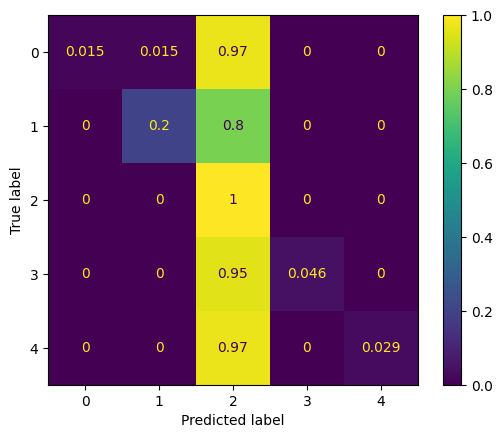

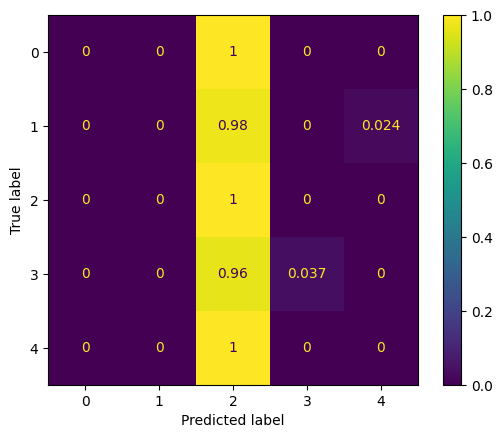

In [71]:
ConfusionMatrixDisplay.from_predictions(y_train, preds_train_lr, normalize='true')
ConfusionMatrixDisplay.from_predictions(y_val, preds_val_lr, normalize='true')

Model is extremely biased towards predicting majority label M. We'll now try a logit with a balanced class_weight. 

Classifcation report on training data:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        68
           1       0.89      0.92      0.90       169
           2       1.00      0.87      0.93       465
           3       0.82      1.00      0.90       108
           4       0.84      1.00      0.92        70

    accuracy                           0.92       880
   macro avg       0.87      0.96      0.91       880
weighted avg       0.93      0.92      0.92       880

Classification report on validation data:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.21      0.17      0.19        42
           2       0.58      0.66      0.62       116
           3       0.10      0.11      0.11        27
           4       0.00      0.00      0.00        18

    accuracy                           0.39       220
   macro avg       0.18      0.19      0.18       

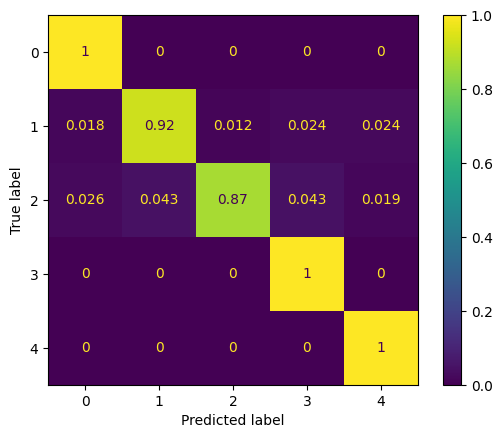

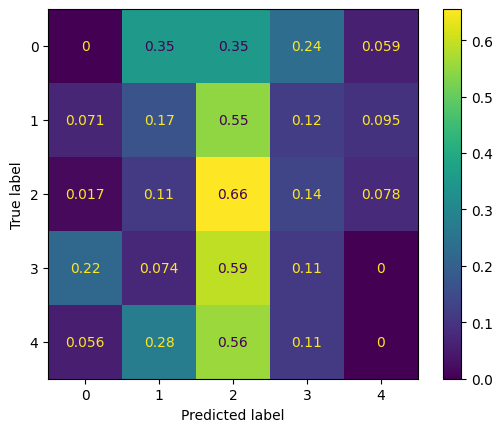

In [72]:
lr_balanced = LogisticRegression(class_weight='balanced')
lr_balanced.fit(X_train, y_train)
preds_train_lr_balanced = lr_balanced.predict(X_train)
preds_val_lr_balanced = lr_balanced.predict(X_val)

store_results("LR_balanced", preds_train_lr_balanced, preds_val_lr_balanced)

print("Classifcation report on training data:")
print(classification_report(y_train, preds_train_lr_balanced))
print("Classification report on validation data:")
print(classification_report(y_val, preds_val_lr_balanced))

ConfusionMatrixDisplay.from_predictions(y_train, preds_train_lr_balanced, normalize='true')
ConfusionMatrixDisplay.from_predictions(y_val, preds_val_lr_balanced, normalize='true')

### 4.4.2 Decision Tree

Classification report for DT on training data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        68
           1       0.99      1.00      1.00       169
           2       1.00      1.00      1.00       465
           3       1.00      1.00      1.00       108
           4       1.00      0.99      0.99        70

    accuracy                           1.00       880
   macro avg       1.00      1.00      1.00       880
weighted avg       1.00      1.00      1.00       880

Classification report for DT on validation data:
              precision    recall  f1-score   support

           0       0.08      0.06      0.07        17
           1       0.14      0.10      0.11        42
           2       0.48      0.54      0.51       116
           3       0.17      0.19      0.18        27
           4       0.06      0.06      0.06        18

    accuracy                           0.34       220
   macro avg       0.18      0.19  

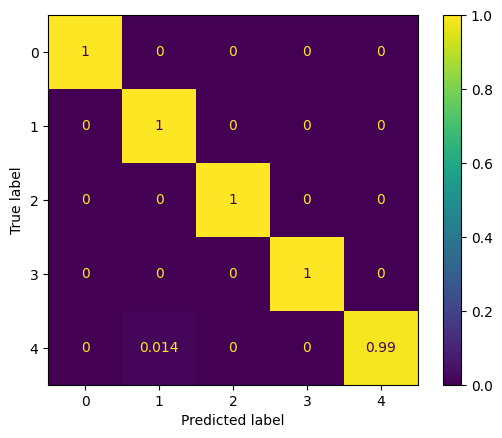

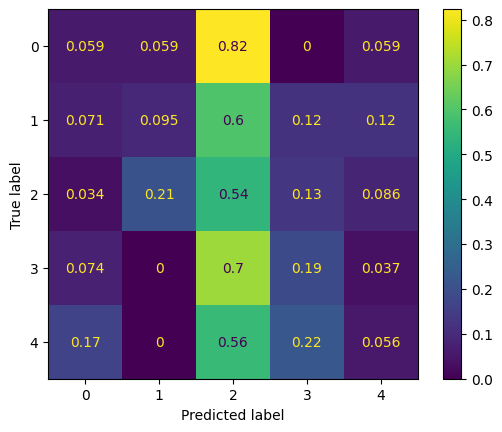

In [73]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
preds_dt_train = dt.predict(X_train)
preds_dt_val = dt.predict(X_val)
print("Classification report for DT on training data:")
print(classification_report(y_train, preds_dt_train))
print("Classification report for DT on validation data:")
print(classification_report(y_val, preds_dt_val))

store_results("Decision Tree", preds_dt_train, preds_dt_val)

ConfusionMatrixDisplay.from_predictions(y_train, preds_dt_train, normalize='true')
ConfusionMatrixDisplay.from_predictions(y_val, preds_dt_val, normalize='true')

Overfitting, although on the positive side the tree is happy to make predictions across the whole range of possible class labels. 

Classification report for DT_balanced on training data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        68
           1       1.00      0.99      1.00       169
           2       1.00      1.00      1.00       465
           3       1.00      1.00      1.00       108
           4       0.99      1.00      0.99        70

    accuracy                           1.00       880
   macro avg       1.00      1.00      1.00       880
weighted avg       1.00      1.00      1.00       880

Classification report for DT on validation data:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.24      0.21      0.23        42
           2       0.51      0.48      0.50       116
           3       0.07      0.11      0.09        27
           4       0.06      0.06      0.06        18

    accuracy                           0.31       220
   macro avg       0.18   

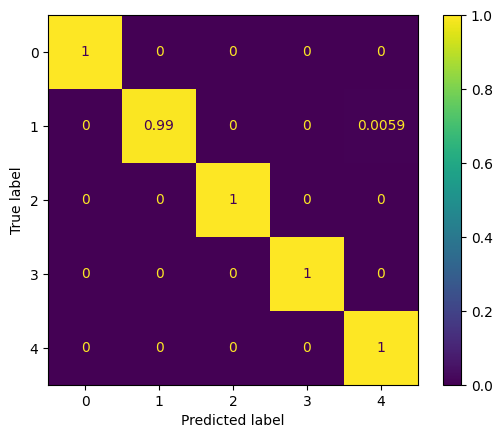

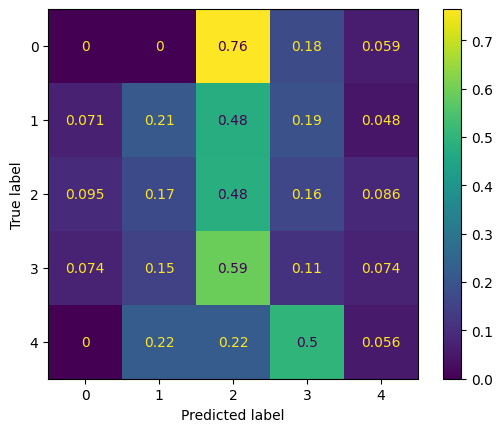

In [74]:
dt_balanced = DecisionTreeClassifier(class_weight='balanced')
dt_balanced.fit(X_train, y_train)
preds_dt_balanced_train = dt_balanced.predict(X_train)
preds_dt_balanced_val = dt_balanced.predict(X_val)
print("Classification report for DT_balanced on training data:")
print(classification_report(y_train, preds_dt_balanced_train))
print("Classification report for DT on validation data:")
print(classification_report(y_val, preds_dt_balanced_val))

store_results("DT_balanced", preds_dt_balanced_train, preds_dt_balanced_val)

ConfusionMatrixDisplay.from_predictions(y_train, preds_dt_balanced_train, normalize='true')
ConfusionMatrixDisplay.from_predictions(y_val, preds_dt_balanced_val, normalize='true')

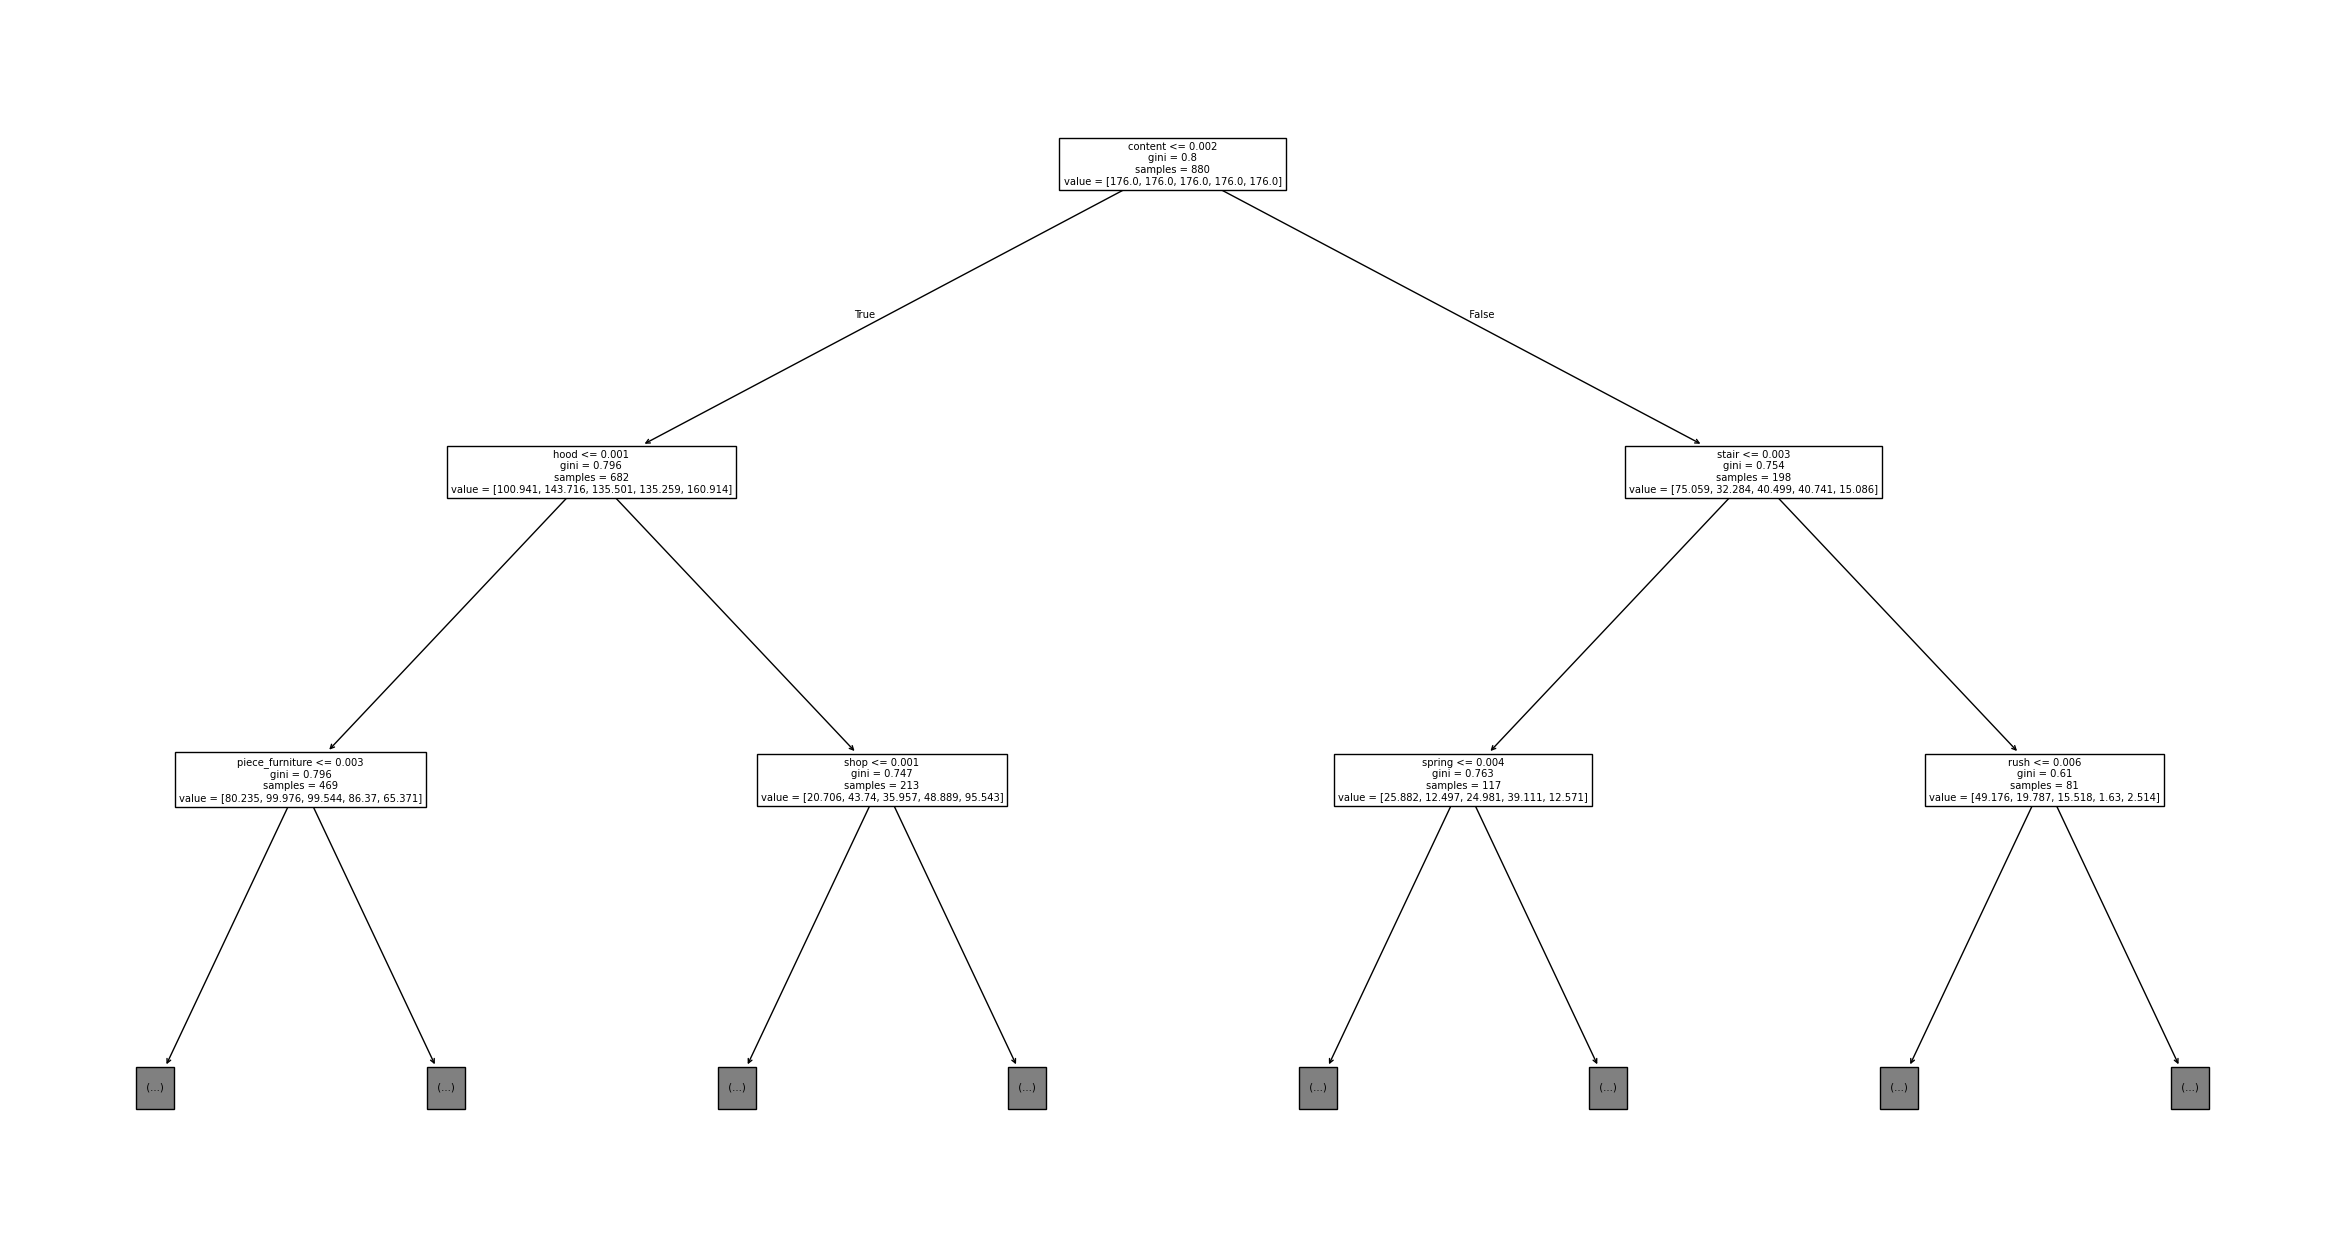

In [75]:
from sklearn.tree import plot_tree 

plt.figure(figsize=(30,16))
plot_tree(dt_balanced, max_depth=2, feature_names=feature_names)
plt.show() 

###  4.4.3 Support Vector Machine

Classification report for SVC on training data:
              precision    recall  f1-score   support

           0       1.00      0.16      0.28        68
           1       0.99      0.79      0.88       169
           2       0.73      1.00      0.84       465
           3       1.00      0.69      0.82       108
           4       1.00      0.26      0.41        70

    accuracy                           0.80       880
   macro avg       0.94      0.58      0.64       880
weighted avg       0.85      0.80      0.77       880

Classification report for SVC on validation_data:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       1.00      0.02      0.05        42
           2       0.53      1.00      0.69       116
           3       1.00      0.04      0.07        27
           4       0.00      0.00      0.00        18

    accuracy                           0.54       220
   macro avg       0.51      0.21

c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

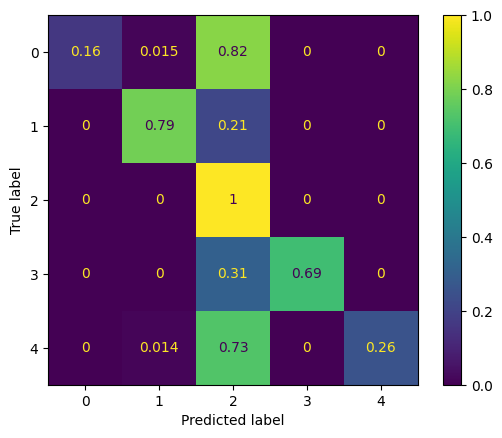

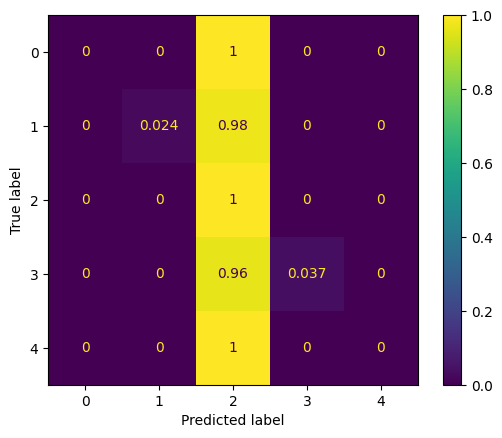

In [76]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train, y_train)
preds_svc_train = svc.predict(X_train)
preds_svc_val = svc.predict(X_val)
print("Classification report for SVC on training data:")
print(classification_report(y_train, preds_svc_train))
print("Classification report for SVC on validation_data:")
print(classification_report(y_val, preds_svc_val))

store_results("SVC", preds_svc_train, preds_svc_val)

ConfusionMatrixDisplay.from_predictions(y_train, preds_svc_train, normalize='true')
ConfusionMatrixDisplay.from_predictions(y_val, preds_svc_val, normalize='true')

SVC has a decent accuracy, but it achieves this by simply predicting M almost always, so the result is poor. 

Classification report for SVC_balanced on training data:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        68
           1       0.99      0.96      0.97       169
           2       0.99      0.97      0.98       465
           3       0.96      1.00      0.98       108
           4       0.92      1.00      0.96        70

    accuracy                           0.98       880
   macro avg       0.96      0.99      0.97       880
weighted avg       0.98      0.98      0.98       880

Classification report for SVC_balanced on validation_data:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.33      0.02      0.04        42
           2       0.54      0.92      0.68       116
           3       0.25      0.07      0.11        27
           4       0.00      0.00      0.00        18

    accuracy                           0.50       220
   macro avg   

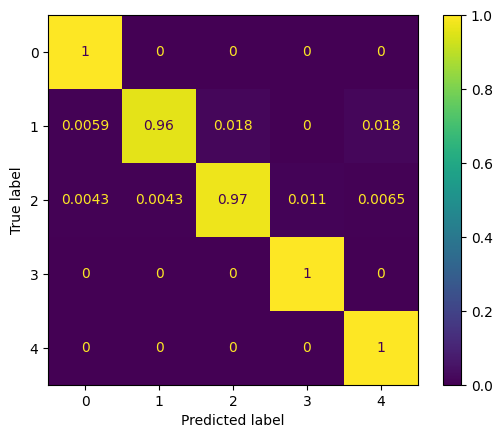

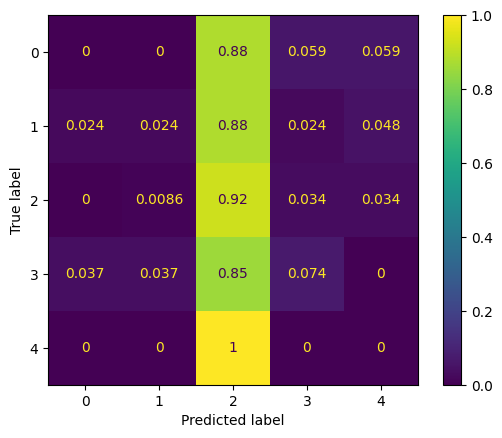

In [77]:
from sklearn.svm import SVC

svc_balanced = SVC(class_weight='balanced')
svc_balanced.fit(X_train, y_train)
preds_svc_train = svc_balanced.predict(X_train)
preds_svc_val = svc_balanced.predict(X_val)
print("Classification report for SVC_balanced on training data:")
print(classification_report(y_train, preds_svc_train))
print("Classification report for SVC_balanced on validation_data:")
print(classification_report(y_val, preds_svc_val))

store_results("SVC_balanced", preds_svc_train, preds_svc_val)

ConfusionMatrixDisplay.from_predictions(y_train, preds_svc_train, normalize='true')
ConfusionMatrixDisplay.from_predictions(y_val, preds_svc_val, normalize='true')

Even with balanced class weights, the SVC is still extremely biased towards predicting the majority class label M.

In [78]:
# visualize decision boundaries 
from sklearn.decomposition import PCA 

pca = PCA(n_components=2) 
X_train_2D = pca.fit_transform(X_train) 
svc_balanced_2D = SVC(class_weight='balanced')
svc_balanced_2D.fit(X_train_2D, y_train) 

x_min, x_max = X_train_2D[:, 0].min() - 1, X_train_2D[:, 0].max() + 1 
y_min, y_max = X_train_2D[:, 1].min() - 1, X_train_2D[:, 1].max() + 1 
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), 
                     np.arange(y_min, y_max, 0.01))

z = svc_balanced.predict(np.c_[xx.ravel(), yy.ravel()]) 
Z = z.reshape(xx.shape) 

ValueError: X has 2 features, but SVC is expecting 98136 features as input.

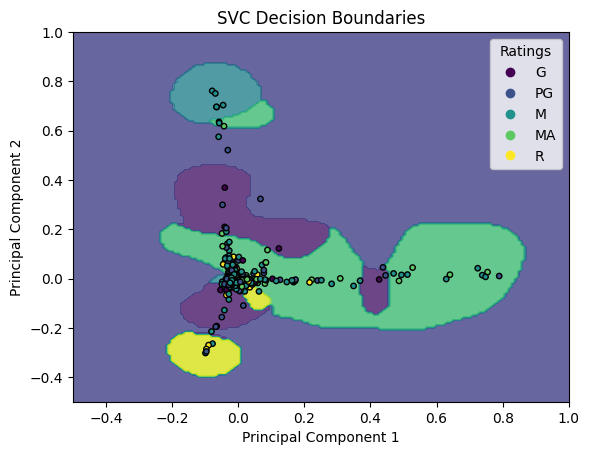

In [97]:
plt.contourf(xx, yy, Z, alpha=0.8) 

decision_boundary_plot = plt.scatter(
    X_train_2D[:, 0],
    X_train_2D[:, 1],
    c=y_train,
    edgecolors='k',
    marker='o',
    s=15
)
plt.xlim(-0.5, 1.0)
plt.ylim(-0.5, 1.0)

handles, labels = decision_boundary_plot.legend_elements() 
labels = ["G", "PG", "M", "MA", "R"]
plt.legend(handles, labels, title="Ratings")

plt.xlabel("Principal Component 1") 
plt.ylabel("Principal Component 2") 
plt.title("SVC Decision Boundaries") 
plt.show() 

### 4.4.4 Comparisons

In [79]:
results_df = pd.DataFrame.from_dict(results_dict)
f1_results = results_df.sort_values('Validation F1', ascending=False)
f1_results

,Model Type,Training Accuracy,Training Recall,Training Precision,Training F1,Validation Accuracy,Validation Recall,Validation Precision,Validation F1
4,SVC,0.797727,0.797727,0.852069,0.767018,0.536364,0.536364,0.594204,0.383895
5,SVC_balanced,0.978409,0.978409,0.979206,0.978490,0.500000,0.500000,0.376409,0.379588
0,LR,0.576136,0.576136,0.759665,0.458970,0.531818,0.531818,0.403294,0.375016
1,LR_balanced,0.915909,0.915909,0.926836,0.916703,0.390909,0.390909,0.358667,0.373031
2,Decision Tree,0.998864,0.998864,0.998870,0.998861,0.336364,0.336364,0.311556,0.322097
3,DT_balanced,0.998864,0.998864,0.998880,0.998866,0.313636,0.313636,0.331210,0.321448


The balanced Decision Tree is probably the best performing model so far, with 55% F1 Score on validation. We'll see if we can improve on this with Random Forest. 

### 4.4.5 Random Forest

#### 4.4.5.0 Results Storage

In [108]:
# initializing lists for storing metrics and results

# parameters 
model_names_list = []
number_of_estimators_list = []
max_depth_list = []
avg_depth_list = []
min_samples_leaf_list = []
max_features_list = []
class_weights = []
criteria = []

# training results 
training_accuracy_list = []
training_precision_list = []
training_recall_list = []
training_f1_list = []

# validation results 
validation_accuracy_list = []
validation_precision_list = []
validation_recall_list = []
validation_f1_list = []

# generalization results 
accuracy_losses_list = []
precision_losses_list = []
recall_losses_list = []
f1_losses_list = []

# confusion matrices
cm_train_list = []
cm_val_list = []

In [101]:
# preferences for ConfusionMatrixDisplay
label_names = ["G", "PG", "M", "MA", "R"]

def configure_CM(cm_display, title):
  cm_display.ax_.set_xlabel("Predicted")
  cm_display.ax_.set_ylabel("Actual")
  cm_display.ax_.set_xticklabels(label_names)
  cm_display.ax_.set_yticklabels(label_names)
  cm_display.ax_.set_title(title)

In [106]:
# Function to generate an RFC and store metrics
from sklearn.ensemble import RandomForestClassifier 

labels=[0, 1, 2, 3, 4]

def plant_forest(name, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0, max_features='sqrt', max_leaf_nodes=None, class_weight=None, criterion='gini', min_impurity_decrease=0.0):
  # instantiating model with specified hyperparameters
  model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, min_weight_fraction_leaf=min_weight_fraction_leaf, max_features=max_features, max_leaf_nodes=max_leaf_nodes, min_impurity_decrease=min_impurity_decrease, random_state=1917, class_weight=class_weight, criterion=criterion)
  # fitting model
  model.fit(X_train, y_train)
  # training results
  preds_train = model.predict(X_train)
  accuracy_train = accuracy_score(y_train, preds_train)
  precision_train = precision_score(y_train, preds_train, labels=labels, average='weighted', zero_division=0.0)
  recall_train = recall_score(y_train, preds_train, labels=labels, average='weighted')
  f1_train = f1_score(y_train, preds_train, labels=labels, average='weighted')

  # validation results
  preds_val = model.predict(X_val)
  accuracy_val = accuracy_score(y_val, preds_val)
  precision_val = precision_score(y_val, preds_val, labels=labels, average='weighted', zero_division=0.0)
  recall_val = recall_score(y_val, preds_val, labels=labels, average='weighted')
  f1_val = f1_score(y_val, preds_val, labels=labels, average='weighted')

  # Generalization loss
  accuracy_loss = accuracy_train - accuracy_val
  precision_loss = precision_train - precision_val
  recall_loss = recall_train - recall_val
  f1_loss = f1_train - f1_val

  # store results in global model comparison dict 
  store_results(name, preds_svc_train, preds_svc_val)

  # Storing info in lists
  # model parameters 
  model_params = model.get_params
  avg_depth = np.mean([estimator.tree_.max_depth for estimator in model.estimators_])
  model_names_list.append(name)
  number_of_estimators_list.append(n_estimators)
  max_depth_list.append(max_depth)
  avg_depth_list.append(avg_depth)
  min_samples_leaf_list.append(min_samples_leaf)
  max_features_list.append(max_features)
  class_weights.append(class_weight)
  criteria.append(criterion)

  # training results 
  training_accuracy_list.append(accuracy_train)
  training_precision_list.append(precision_train)
  training_recall_list.append(recall_train)
  training_f1_list.append(f1_train)

  # validation results 
  validation_accuracy_list.append(accuracy_val)
  validation_precision_list.append(precision_val)
  validation_recall_list.append(recall_val)
  validation_f1_list.append(f1_val)

  # generalization results 
  accuracy_losses_list.append(accuracy_loss)
  precision_losses_list.append(precision_loss)
  recall_losses_list.append(recall_loss)
  f1_losses_list.append(f1_loss)

  # Printing key measures
  # print(f"Training Accuracy for {name}: ", accuracy_train)
  # print(f"Training Precision for {name}: ", precision_train)
  # print(f"Training Recall for {name}: ", recall_train)
  # print(f"Training F1 Score for {name}: ", f1_train)
  # print("")
  print(classification_report(y_train, preds_train, zero_division=0.0))
  print("")
  # print(f"Validation Accuracy for {name}: ", accuracy_val)
  # print(f"Validation Precision for {name}: ", precision_val)
  # print(f"Validation Recall for {name}: ", recall_val)
  # print(f"Validation F1 Score for {name}: ", f1_val)
  # print("")
  print(classification_report(y_val, preds_val, zero_division=0.0))
  print("")
  print(f"Accuracy Generalization Loss for {name}: ", accuracy_loss)
  print(f"Precision Generalization Loss for {name}: ", precision_loss)
  print(f"Recall Generalization Loss for {name}: ", recall_loss)
  print(f"F1 Generalization Loss for {name}: ", f1_loss)
  print("")

  # Confusion Matrices
  cm_train = confusion_matrix(y_train, preds_train, labels=labels)
  cm_val = confusion_matrix(y_val, preds_val, labels=labels)
  cm_train_list.append(cm_train)
  cm_val_list.append(cm_val)
  CM_train = ConfusionMatrixDisplay.from_predictions(y_train, preds_train, labels=labels, normalize='true')
  configure_CM(CM_train, f"Confusion Matrix for {name} on training data")
  plt.show()
  CM_val = ConfusionMatrixDisplay.from_predictions(y_val, preds_val, labels=labels, normalize='true')
  configure_CM(CM_val, f"Confusion Matrix for {name} on validation data")

  # return model
  return model

#### 4.4.5.1 Default Models

c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        67
           1       1.00      0.99      1.00       182
           2       1.00      1.00      1.00       526
           3       1.00      1.00      1.00       105
           4       1.00      1.00      1.00        59

    accuracy                           1.00       939
   macro avg       1.00      1.00      1.00       939
weighted avg       1.00      1.00      1.00       939


              precision    recall  f1-score   support

           0       0.50      0.06      0.11        16
           1       0.33      0.02      0.04        46
           2       0.57      0.98      0.72       132
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        15

    accuracy                           0.56       235
   macro avg       0.28      0.21      0.17       235
weighted avg       0.42      0.56      0.42       235


Accuracy Generalizat

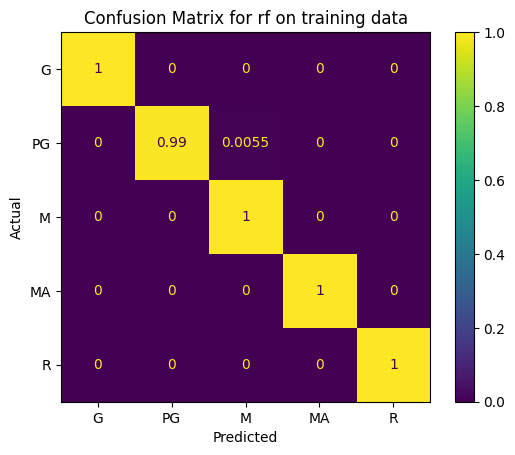

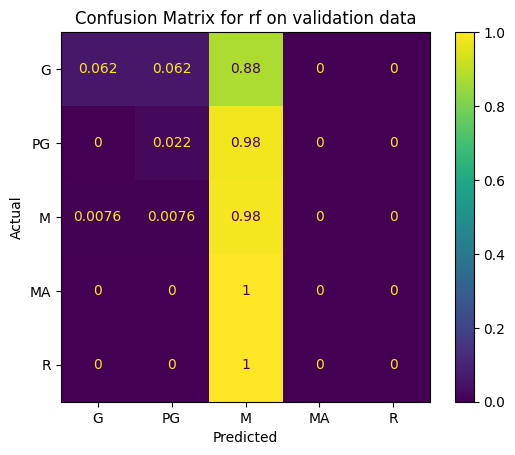

In [156]:
rf = plant_forest("rf")

Overfits and over-biased to predicting M. We'll try balanced class weights. 

c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        67
           1       0.99      1.00      1.00       182
           2       1.00      1.00      1.00       526
           3       1.00      1.00      1.00       105
           4       1.00      1.00      1.00        59

    accuracy                           1.00       939
   macro avg       1.00      1.00      1.00       939
weighted avg       1.00      1.00      1.00       939


              precision    recall  f1-score   support

           0       0.50      0.06      0.11        16
           1       0.00      0.00      0.00        46
           2       0.56      0.99      0.72       132
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        15

    accuracy                           0.56       235
   macro avg       0.21      0.21      0.17       235
weighted avg       0.35      0.56      0.41       235


Accuracy Generalizat

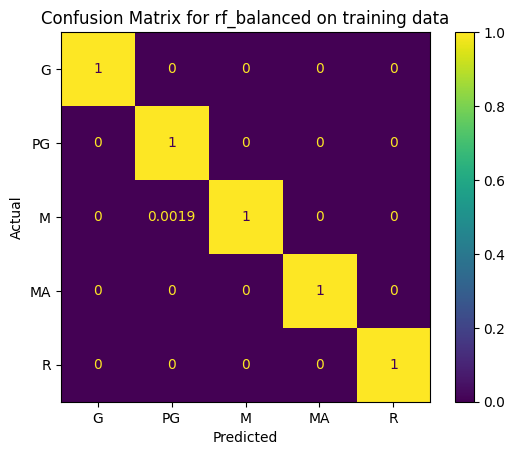

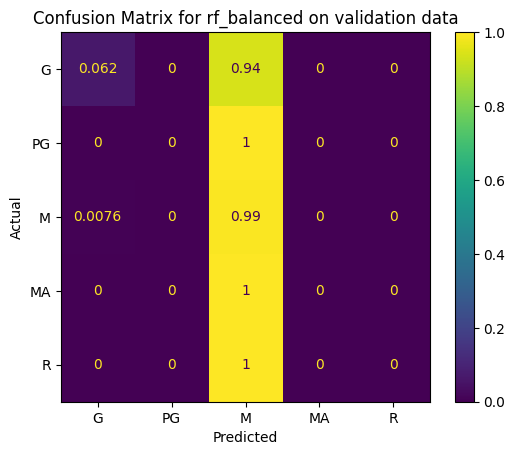

In [158]:
rf_balanced = plant_forest("rf_balanced", class_weight='balanced')

Still overfitting and heavily biased towards predicting M. 

#### 4.4.5.2 Manual Hyperparameter tuning

##### 4.4.5.2.1 Depth tuning

In [160]:
# get the average depth of rf_balanced 
avg_depth = np.mean([estimator.get_depth() for estimator in rf_balanced.estimators_])
print("Average tree depth of RF_balanced:", avg_depth)

Average tree depth of RF_balanced: 24.49


c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        67
           1       1.00      0.99      1.00       182
           2       1.00      1.00      1.00       526
           3       1.00      1.00      1.00       105
           4       1.00      1.00      1.00        59

    accuracy                           1.00       939
   macro avg       1.00      1.00      1.00       939
weighted avg       1.00      1.00      1.00       939


              precision    recall  f1-score   support

           0       0.33      0.06      0.11        16
           1       0.50      0.09      0.15        46
           2       0.58      0.98      0.73       132
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        15

    accuracy                           0.57       235
   macro avg       0.28      0.23      0.20       235
weighted avg       0.45      0.57      0.45       235


Accuracy Generalizat

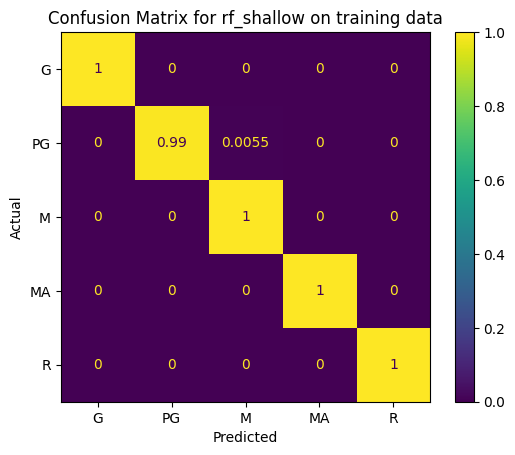

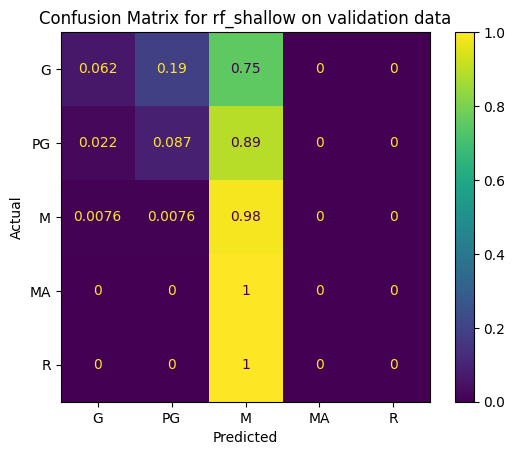

In [161]:
# reducing max_depth to 10 
rf_shallow = plant_forest("rf_shallow", class_weight='balanced', max_depth=10)

very marginally better results in dissuading the forest from predicting M.

c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.89      1.00      0.94        67
           1       0.75      0.92      0.83       182
           2       0.98      0.84      0.90       526
           3       0.83      1.00      0.91       105
           4       0.94      0.98      0.96        59

    accuracy                           0.89       939
   macro avg       0.88      0.95      0.91       939
weighted avg       0.91      0.89      0.90       939


              precision    recall  f1-score   support

           0       0.40      0.25      0.31        16
           1       0.35      0.48      0.41        46
           2       0.64      0.62      0.63       132
           3       0.15      0.19      0.17        26
           4       0.00      0.00      0.00        15

    accuracy                           0.48       235
   macro avg       0.31      0.31      0.30       235
weighted avg       0.47      0.48      0.47       235


Accuracy Generalizat

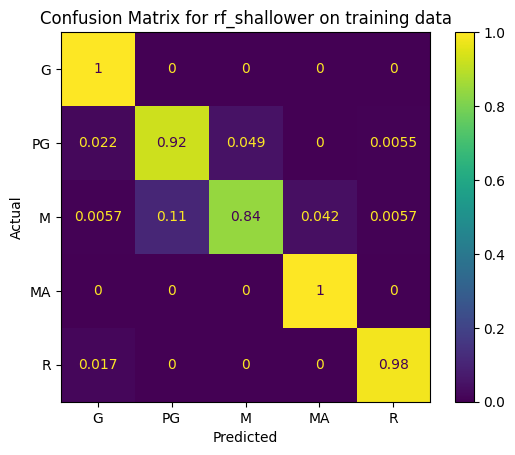

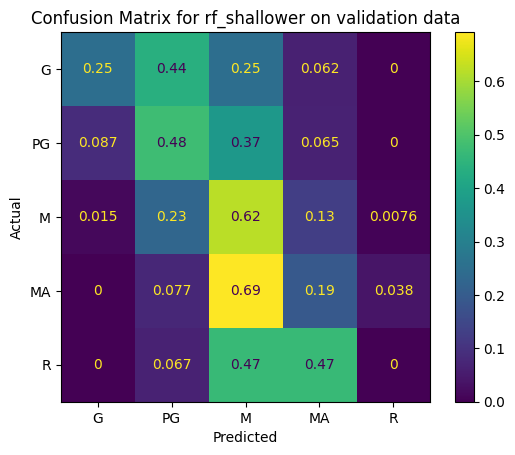

In [172]:
rf_shallower = plant_forest(
    "rf_shallower",
    max_depth=5,
    class_weight='balanced'
)

The shallower forest has lower accuracy but higher F1 scores, which is a worthwhile trade-off here. Training results are still pretty strong, suggesting the forest is still overfitting even now. 

Let's now try reducing max_depth even lower to see the direction for the optimal range. 

c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.64      1.00      0.78        67
           1       0.56      0.77      0.65       182
           2       0.93      0.49      0.64       526
           3       0.43      0.92      0.59       105
           4       0.74      1.00      0.85        59

    accuracy                           0.66       939
   macro avg       0.66      0.84      0.70       939
weighted avg       0.77      0.66      0.66       939


              precision    recall  f1-score   support

           0       0.19      0.38      0.26        16
           1       0.40      0.46      0.43        46
           2       0.75      0.39      0.52       132
           3       0.22      0.62      0.33        26
           4       0.09      0.07      0.08        15

    accuracy                           0.41       235
   macro avg       0.33      0.38      0.32       235
weighted avg       0.55      0.41      0.43       235


Accuracy Generalizat

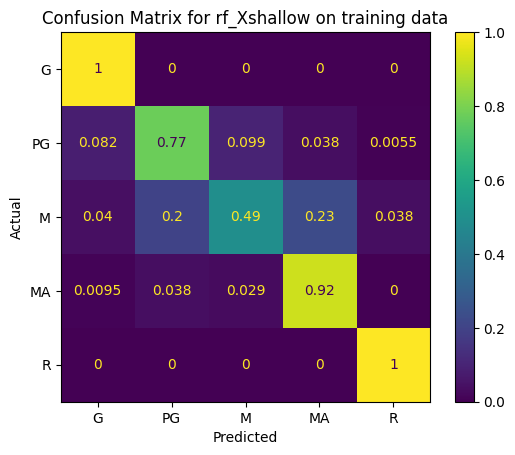

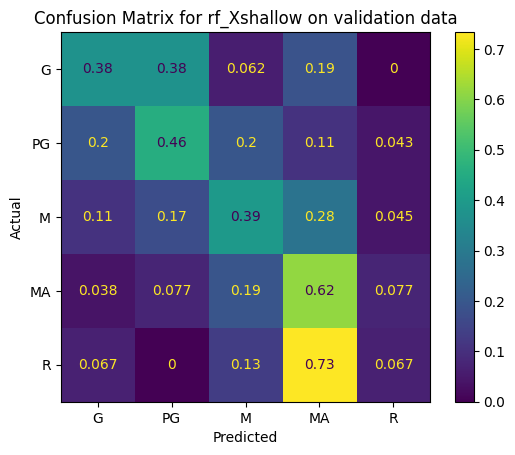

In [176]:
rf_Xshallow = plant_forest(
    "rf_Xshallow",
    max_depth=3,
    class_weight='balanced'
)

reducing max_depth to 3 yields lower accuracy, slightly higher macro f1 but lower weighted f1. Likely the optimal md is between 4 and 9. Let's try md=8 to see which direction we should be going in. 

Compared with md=5, md=8 yields higher accuracy, lower macro f1 and marginally higher weighted f1. So likely the optimal md is between 4 and 7. 

c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99        67
           1       0.99      0.99      0.99       182
           2       1.00      0.99      1.00       526
           3       0.99      1.00      1.00       105
           4       0.98      1.00      0.99        59

    accuracy                           0.99       939
   macro avg       0.99      1.00      0.99       939
weighted avg       0.99      0.99      0.99       939


              precision    recall  f1-score   support

           0       0.20      0.06      0.10        16
           1       0.47      0.20      0.28        46
           2       0.59      0.93      0.73       132
           3       0.50      0.08      0.13        26
           4       0.00      0.00      0.00        15

    accuracy                           0.57       235
   macro avg       0.35      0.25      0.25       235
weighted avg       0.50      0.57      0.48       235


Accuracy Generalizat

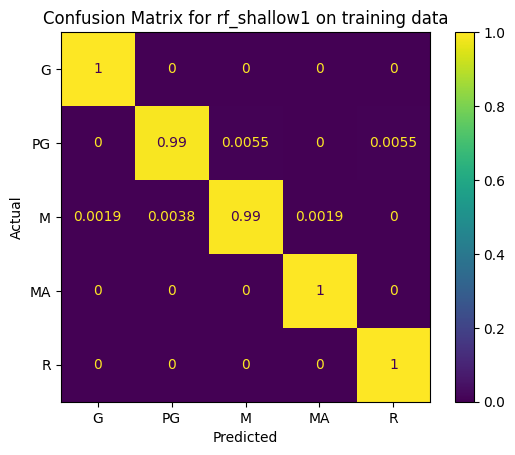

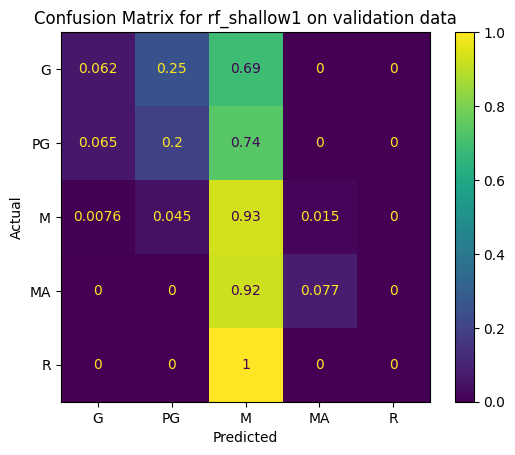

In [177]:
rf_shallow1 = plant_forest(
    "rf_shallow1",
    max_depth=8,
    class_weight='balanced'
)

##### 4.4.5.2.2 Criterion tuning

c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        67
           1       0.99      1.00      1.00       182
           2       1.00      1.00      1.00       526
           3       1.00      1.00      1.00       105
           4       1.00      1.00      1.00        59

    accuracy                           1.00       939
   macro avg       1.00      1.00      1.00       939
weighted avg       1.00      1.00      1.00       939


              precision    recall  f1-score   support

           0       0.33      0.06      0.11        16
           1       0.50      0.02      0.04        46
           2       0.57      0.99      0.72       132
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        15

    accuracy                           0.57       235
   macro avg       0.28      0.22      0.17       235
weighted avg       0.44      0.57      0.42       235


Accuracy Generalizat

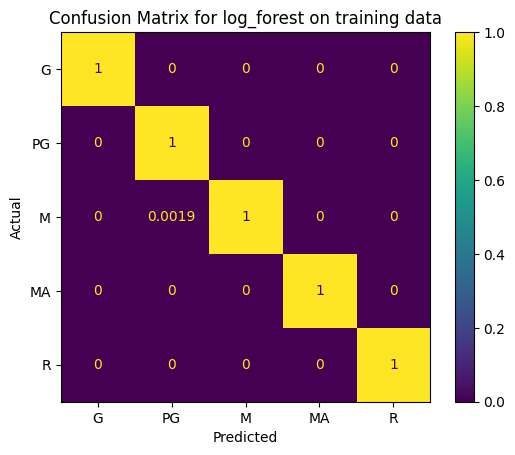

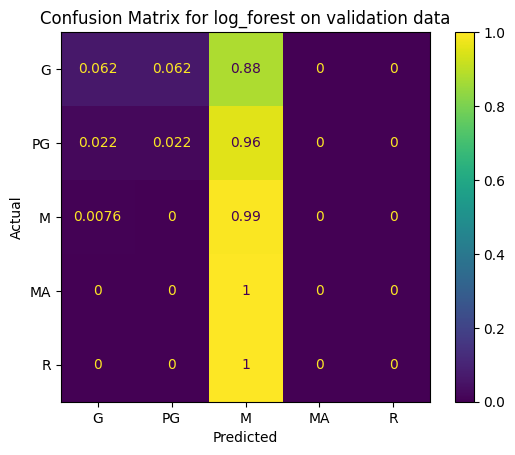

In [162]:
# trying log-loss criterion 
log_forest = plant_forest("log_forest", criterion='log_loss', max_depth=10, class_weight='balanced')

Results are slightly worse than gini criterion w same params. 

c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        67
           1       0.99      1.00      1.00       182
           2       1.00      1.00      1.00       526
           3       1.00      1.00      1.00       105
           4       1.00      1.00      1.00        59

    accuracy                           1.00       939
   macro avg       1.00      1.00      1.00       939
weighted avg       1.00      1.00      1.00       939


              precision    recall  f1-score   support

           0       0.33      0.06      0.11        16
           1       0.50      0.02      0.04        46
           2       0.57      0.99      0.72       132
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        15

    accuracy                           0.57       235
   macro avg       0.28      0.22      0.17       235
weighted avg       0.44      0.57      0.42       235


Accuracy Generalizat

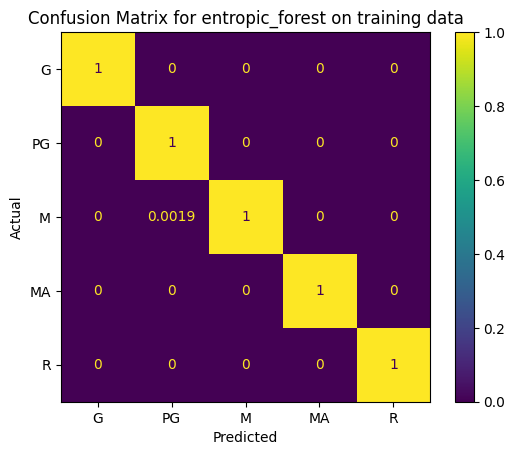

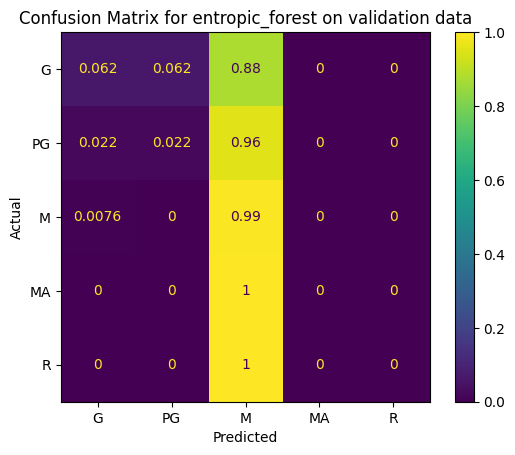

In [164]:
# trying gini criterion 
entropic_forest = plant_forest("entropic_forest", criterion='entropy', max_depth=10, class_weight='balanced')

Results are slightly worse than Gini criterion. 

Let's try reducing max_features to 'log2'

In [167]:
sqrt_features = np.sqrt(entropic_forest.n_features_in_)
print("Square root of featurespace =", sqrt_features)

log2_features = np.log2(entropic_forest.n_features_in_)
print("Log_2 of featurespace =", log2_features)

Square root of featurespace = 254.67037519114783
Log_2 of featurespace = 15.984974672149518


c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        67
           1       0.99      1.00      1.00       182
           2       1.00      1.00      1.00       526
           3       1.00      1.00      1.00       105
           4       1.00      1.00      1.00        59

    accuracy                           1.00       939
   macro avg       1.00      1.00      1.00       939
weighted avg       1.00      1.00      1.00       939


              precision    recall  f1-score   support

           0       0.50      0.06      0.11        16
           1       0.00      0.00      0.00        46
           2       0.56      0.99      0.72       132
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        15

    accuracy                           0.56       235
   macro avg       0.21      0.21      0.17       235
weighted avg       0.35      0.56      0.41       235


Accuracy Generalizat

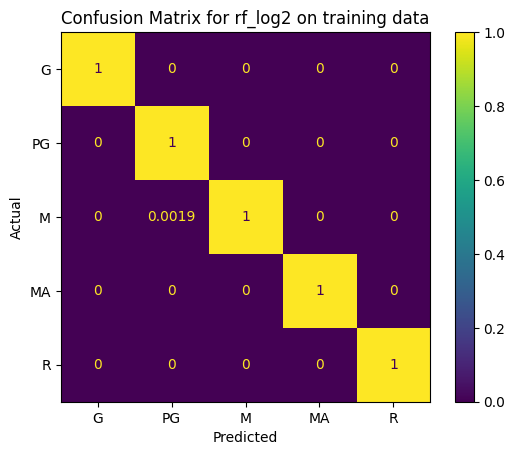

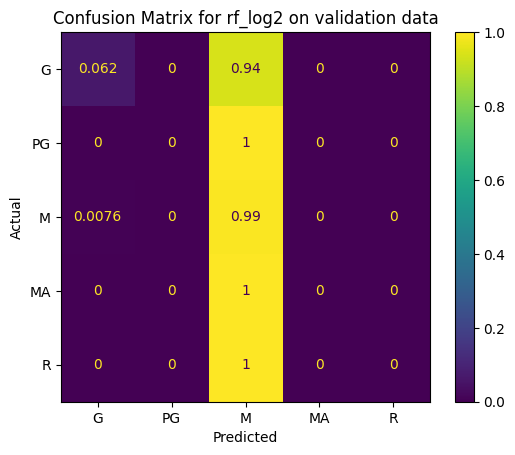

In [169]:
rf_log2 = plant_forest(
    "rf_log2",
    class_weight='balanced',
    max_features='log2'
)

Somewhat surprisingly the results are identical with max_features='sqrt', but let's try it for a shallower forest. 

c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       1.00      0.99      0.99        67
           1       0.99      0.96      0.97       182
           2       0.98      1.00      0.99       526
           3       0.99      1.00      1.00       105
           4       1.00      1.00      1.00        59

    accuracy                           0.99       939
   macro avg       0.99      0.99      0.99       939
weighted avg       0.99      0.99      0.99       939


              precision    recall  f1-score   support

           0       0.33      0.06      0.11        16
           1       0.32      0.15      0.21        46
           2       0.58      0.90      0.71       132
           3       0.20      0.04      0.06        26
           4       0.00      0.00      0.00        15

    accuracy                           0.54       235
   macro avg       0.29      0.23      0.22       235
weighted avg       0.43      0.54      0.45       235


Accuracy Generalizat

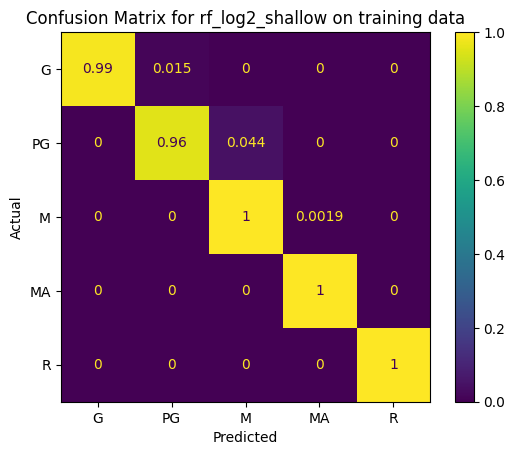

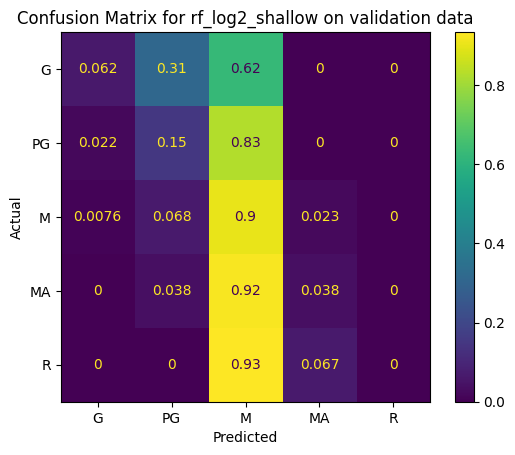

In [170]:
rf_log2_shallow = plant_forest(
    "rf_log2_shallow",
    class_weight='balanced',
    max_depth=10,
    max_features='log2'
)

The forest has a slightly higher macro avg f1 score than the equivalent forest with 'sqrt' max_features. Overall the forest is still overfitting heavily. Let's try a forest with no max_features to see the results. 

c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        67
           1       0.99      1.00      1.00       182
           2       1.00      1.00      1.00       526
           3       1.00      1.00      1.00       105
           4       1.00      1.00      1.00        59

    accuracy                           1.00       939
   macro avg       1.00      1.00      1.00       939
weighted avg       1.00      1.00      1.00       939


              precision    recall  f1-score   support

           0       0.33      0.12      0.18        16
           1       0.52      0.30      0.38        46
           2       0.61      0.92      0.73       132
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        15

    accuracy                           0.59       235
   macro avg       0.29      0.27      0.26       235
weighted avg       0.47      0.59      0.50       235


Accuracy Generalizat

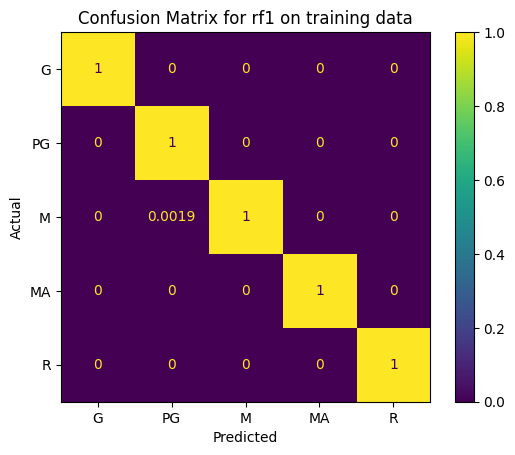

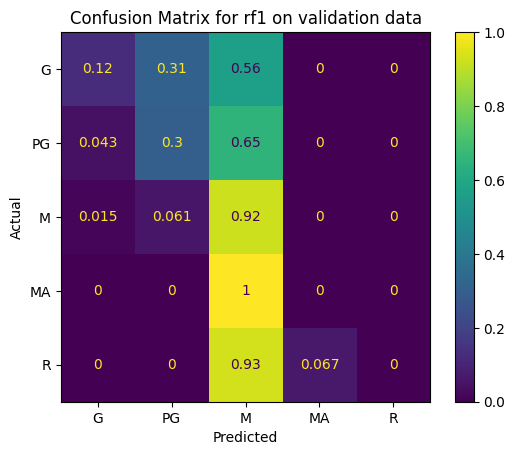

In [171]:
rf1 = plant_forest(
    "rf1", 
    class_weight='balanced', 
    max_features=None
)

Lifting the max_features cap gives higher accuracy and f1 scores, although still overfitting and too biased towards M. Let's reduce max_features a bit and limit max_depth. 

First trying the same model with max_depth halved down to 5. 

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        68
           1       0.87      0.96      0.91       169
           2       0.99      0.95      0.97       465
           3       0.95      0.96      0.95       108
           4       0.99      0.97      0.98        70

    accuracy                           0.96       880
   macro avg       0.96      0.97      0.96       880
weighted avg       0.96      0.96      0.96       880


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.21      0.21      0.21        42
           2       0.50      0.70      0.58       116
           3       0.19      0.11      0.14        27
           4       0.00      0.00      0.00        18

    accuracy                           0.42       220
   macro avg       0.18      0.20      0.19       220
weighted avg       0.33      0.42      0.37       220


Accuracy Generalizat

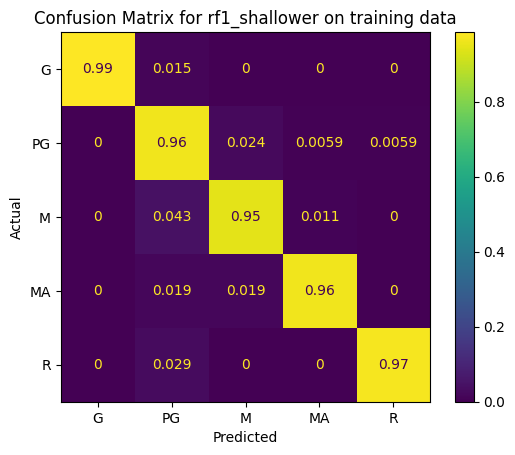

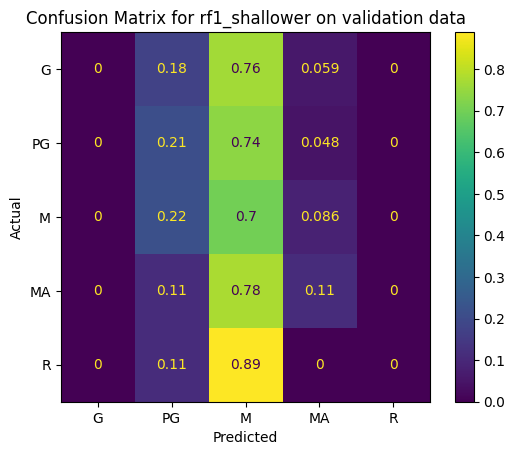

In [109]:
rf1_shallower = plant_forest(
    "rf1_shallower", 
    class_weight='balanced', 
    max_features=None,
    max_depth=5
)

Could also try e.g. max_features=0.1, allowing each tree to see 10% of the featurespace. Would be around 600 in this case, approx. 3x the size of 'sqrt'.

Compared with rf_shallower (same except more features allowed to each tree), rf1a performs better on all measures. Likely the ideal max_features is somewhere between 0.1 and 1.0.

c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.92      0.99      0.95        67
           1       0.59      0.91      0.71       182
           2       0.97      0.75      0.85       526
           3       0.83      0.92      0.87       105
           4       0.98      1.00      0.99        59

    accuracy                           0.83       939
   macro avg       0.86      0.91      0.88       939
weighted avg       0.88      0.83      0.84       939


              precision    recall  f1-score   support

           0       0.45      0.31      0.37        16
           1       0.40      0.70      0.50        46
           2       0.75      0.61      0.68       132
           3       0.32      0.42      0.37        26
           4       0.00      0.00      0.00        15

    accuracy                           0.55       235
   macro avg       0.38      0.41      0.38       235
weighted avg       0.57      0.55      0.54       235


Accuracy Generalizat

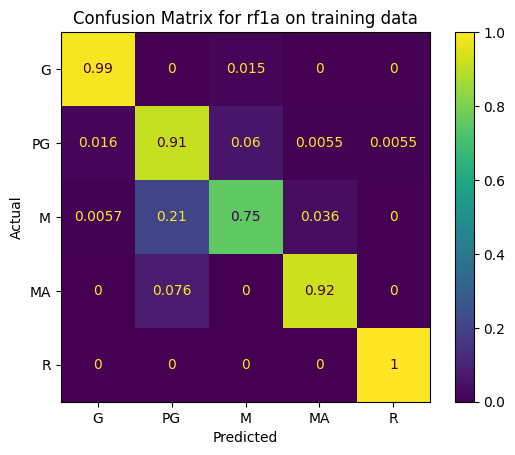

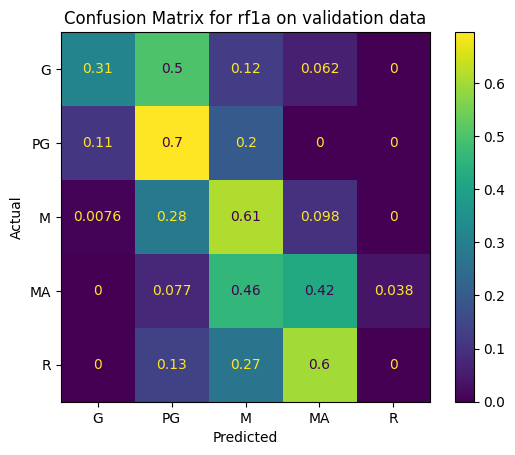

In [173]:
rf1a = plant_forest(
    "rf1a",
    max_depth=5, 
    class_weight='balanced',
    max_features=0.1
)

Now we'll see the result if we set max_features for each tree at 50%. 

Compared with rf1a (mf=0.1), rf1b (mf=0.5) performs worse overall. Likely optimal mf between 0.1 and 0.5.  

              precision    recall  f1-score   support

           0       0.87      0.99      0.92        67
           1       0.60      0.88      0.72       182
           2       0.96      0.76      0.85       526
           3       0.81      0.91      0.86       105
           4       0.98      1.00      0.99        59

    accuracy                           0.83       939
   macro avg       0.84      0.91      0.87       939
weighted avg       0.87      0.83      0.84       939


              precision    recall  f1-score   support

           0       0.42      0.31      0.36        16
           1       0.40      0.67      0.50        46
           2       0.70      0.59      0.64       132
           3       0.26      0.35      0.30        26
           4       0.00      0.00      0.00        15

    accuracy                           0.52       235
   macro avg       0.36      0.38      0.36       235
weighted avg       0.53      0.52      0.52       235


Accuracy Generalizat

c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


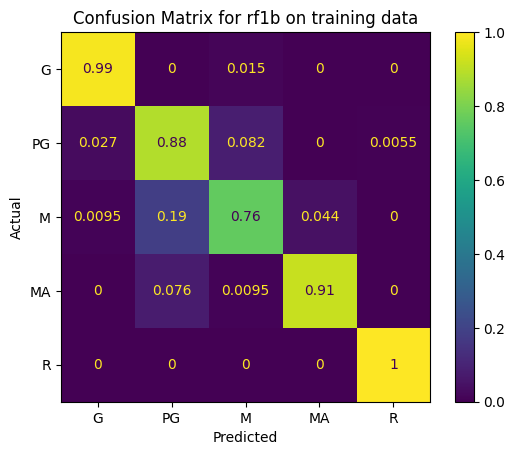

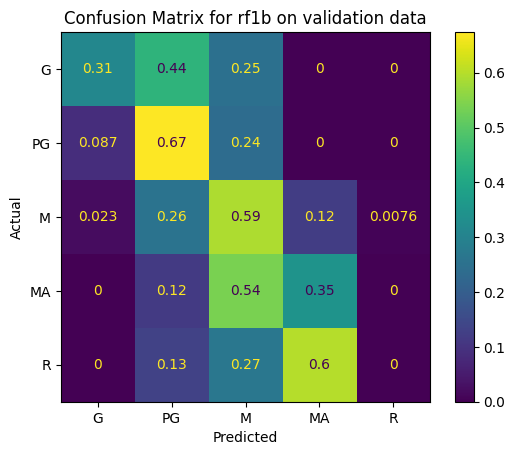

In [174]:
rf1b = plant_forest(
    "rf1b",
    max_depth=5, 
    class_weight='balanced',
    max_features=0.5
)

try raising min_samples_leaf, first to 8.

Much better f1 results than rf_balanced with msl=1. We can try doubling again to 16 to see what happens. 

c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.97      1.00      0.99        67
           1       0.99      0.99      0.99       182
           2       1.00      0.99      1.00       526
           3       1.00      1.00      1.00       105
           4       0.98      1.00      0.99        59

    accuracy                           0.99       939
   macro avg       0.99      1.00      0.99       939
weighted avg       0.99      0.99      0.99       939


              precision    recall  f1-score   support

           0       0.33      0.12      0.18        16
           1       0.35      0.26      0.30        46
           2       0.62      0.88      0.73       132
           3       0.12      0.04      0.06        26
           4       0.00      0.00      0.00        15

    accuracy                           0.56       235
   macro avg       0.29      0.26      0.25       235
weighted avg       0.45      0.56      0.49       235


Accuracy Generalizat

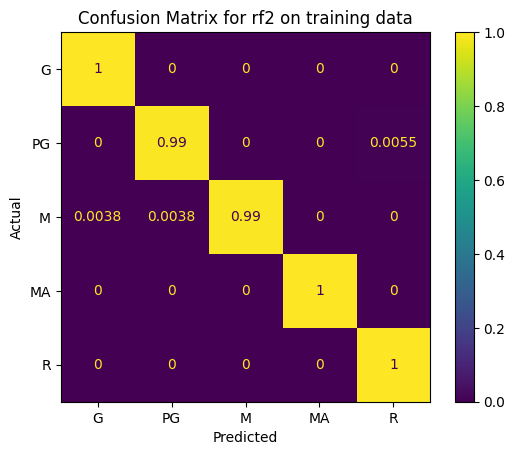

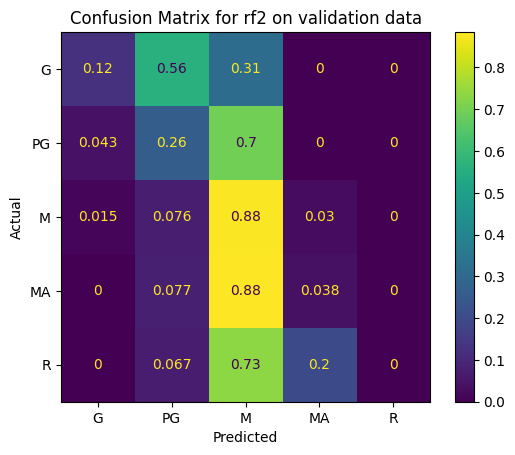

In [178]:
rf2 = plant_forest(
    "rf2",
    min_samples_leaf=8,
    class_weight='balanced'
)

Result is again significant improvements to f1 scores, so let's try doubling again to 32. 

c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.87      1.00      0.93        67
           1       0.86      0.96      0.91       182
           2       0.99      0.89      0.94       526
           3       0.85      0.99      0.92       105
           4       0.92      1.00      0.96        59

    accuracy                           0.93       939
   macro avg       0.90      0.97      0.93       939
weighted avg       0.94      0.93      0.93       939


              precision    recall  f1-score   support

           0       0.29      0.31      0.30        16
           1       0.38      0.46      0.41        46
           2       0.68      0.66      0.67       132
           3       0.31      0.35      0.33        26
           4       0.00      0.00      0.00        15

    accuracy                           0.52       235
   macro avg       0.33      0.35      0.34       235
weighted avg       0.51      0.52      0.51       235


Accuracy Generalizat

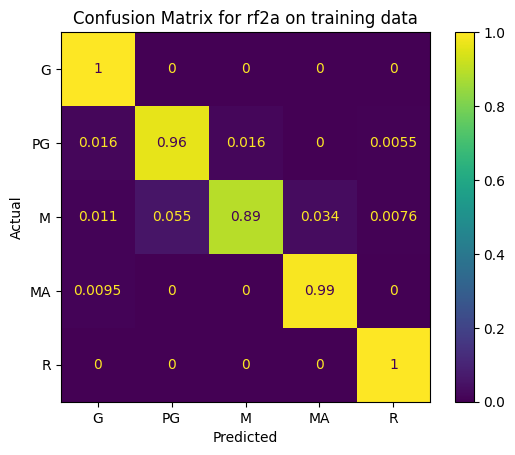

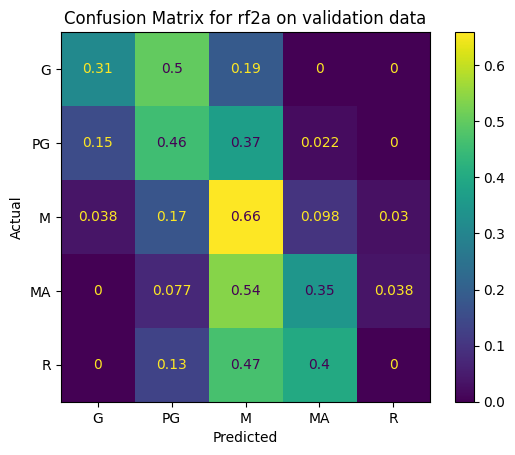

In [179]:
rf2a = plant_forest(
    "rf2a",
    min_samples_leaf=16,
    class_weight='balanced'
)

doubling msl to 32 yields lower metrics overall. So likely optimal msl is between 8 and 32. We can try msl=20 to see which direction we should be going in. 

c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.58      1.00      0.73        67
           1       0.66      0.84      0.73       182
           2       0.98      0.58      0.73       526
           3       0.53      0.99      0.69       105
           4       0.75      1.00      0.86        59

    accuracy                           0.73       939
   macro avg       0.70      0.88      0.75       939
weighted avg       0.82      0.73      0.73       939


              precision    recall  f1-score   support

           0       0.22      0.50      0.31        16
           1       0.42      0.39      0.40        46
           2       0.71      0.46      0.56       132
           3       0.27      0.58      0.37        26
           4       0.07      0.07      0.07        15

    accuracy                           0.44       235
   macro avg       0.34      0.40      0.34       235
weighted avg       0.53      0.44      0.46       235


Accuracy Generalizat

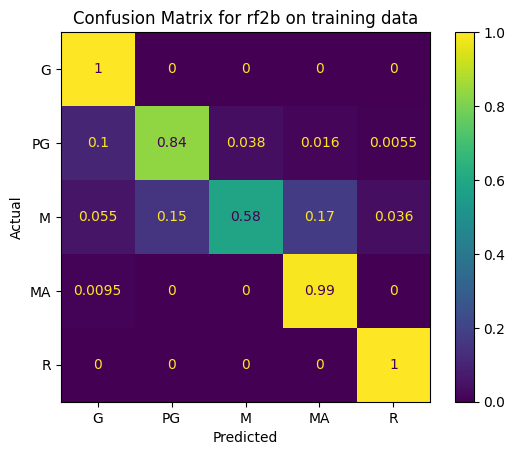

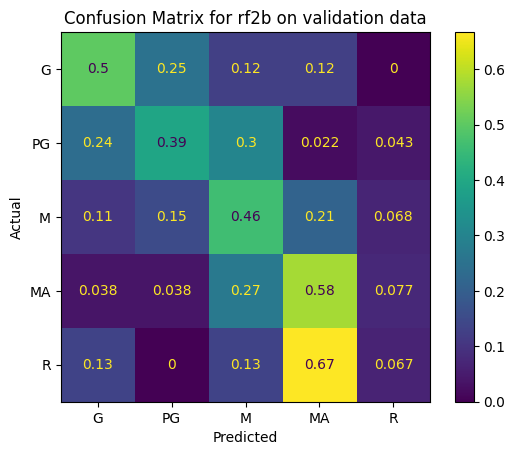

In [180]:
rf2b = plant_forest(
    "rf2b",
    min_samples_leaf=32,
    class_weight='balanced'
)

compared with msl=16, msl=20 yieds lower metrics overall, so optimum between 9 and 19, most likely between 9 and 15. 

c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.79      1.00      0.88        67
           1       0.79      0.92      0.85       182
           2       0.99      0.82      0.90       526
           3       0.76      1.00      0.86       105
           4       0.83      1.00      0.91        59

    accuracy                           0.88       939
   macro avg       0.83      0.95      0.88       939
weighted avg       0.90      0.88      0.88       939


              precision    recall  f1-score   support

           0       0.25      0.31      0.28        16
           1       0.32      0.39      0.35        46
           2       0.66      0.58      0.62       132
           3       0.26      0.38      0.31        26
           4       0.33      0.07      0.11        15

    accuracy                           0.47       235
   macro avg       0.36      0.35      0.33       235
weighted avg       0.50      0.47      0.48       235


Accuracy Generalizat

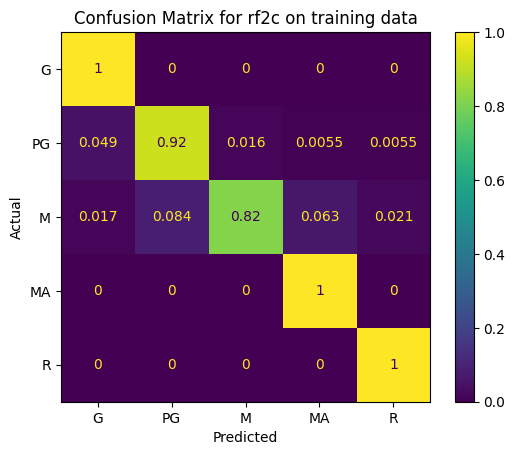

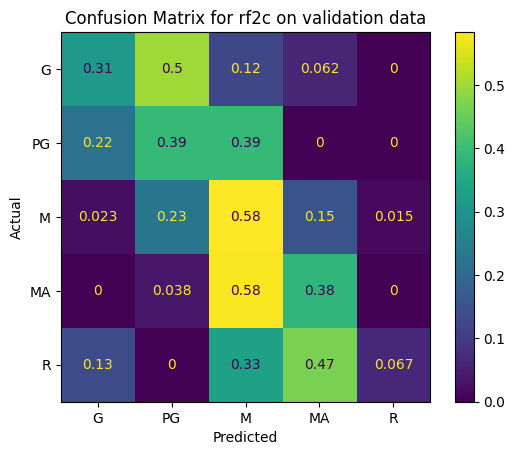

In [181]:
rf2c = plant_forest(
    "rf2c",
    min_samples_leaf=20,
    class_weight='balanced'
)

Now we'll take best performing metrics and start tuning n_estimators. 

c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.81      0.99      0.89        67
           1       0.53      0.86      0.66       182
           2       0.94      0.62      0.75       526
           3       0.59      0.90      0.71       105
           4       0.97      0.97      0.97        59

    accuracy                           0.74       939
   macro avg       0.77      0.87      0.79       939
weighted avg       0.82      0.74      0.75       939


              precision    recall  f1-score   support

           0       0.44      0.44      0.44        16
           1       0.40      0.70      0.51        46
           2       0.80      0.53      0.64       132
           3       0.31      0.62      0.42        26
           4       0.00      0.00      0.00        15

    accuracy                           0.53       235
   macro avg       0.39      0.46      0.40       235
weighted avg       0.59      0.53      0.53       235


Accuracy Generalizat

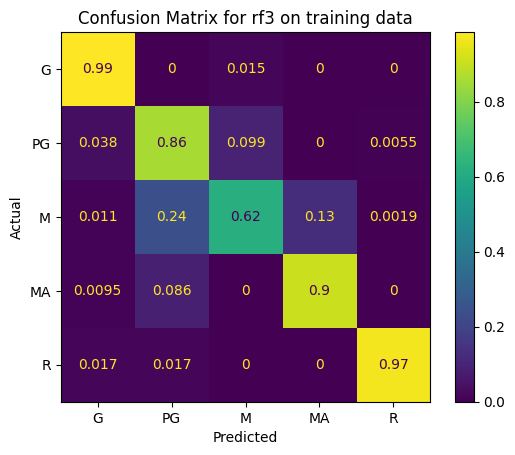

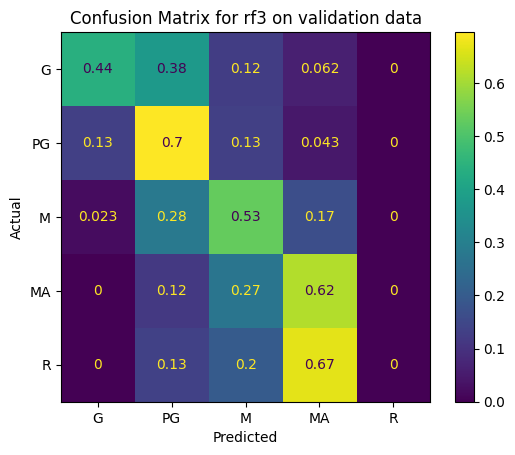

In [183]:
rf3 = plant_forest(
    "rf3",
    max_depth=5, 
    min_samples_leaf=16,
    class_weight='balanced',
    max_features=0.1
)

slightly better f1 results by boosting n_estimators to 250, so we may as well try 500. 

c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.82      0.97      0.89        67
           1       0.57      0.89      0.70       182
           2       0.96      0.66      0.78       526
           3       0.63      0.91      0.74       105
           4       0.97      0.97      0.97        59

    accuracy                           0.78       939
   macro avg       0.79      0.88      0.82       939
weighted avg       0.84      0.78      0.78       939


              precision    recall  f1-score   support

           0       0.44      0.44      0.44        16
           1       0.38      0.63      0.48        46
           2       0.78      0.56      0.65       132
           3       0.30      0.54      0.39        26
           4       0.50      0.07      0.12        15

    accuracy                           0.53       235
   macro avg       0.48      0.45      0.41       235
weighted avg       0.61      0.53      0.54       235


Accuracy Generalizat

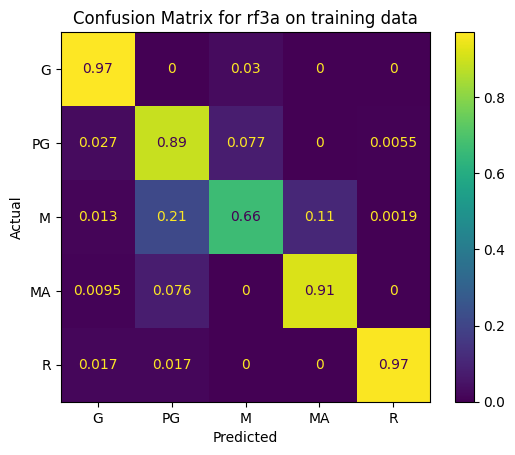

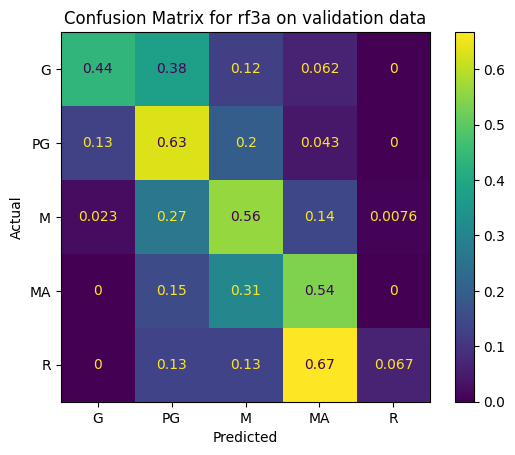

In [184]:
rf3a = plant_forest(
    "rf3a",
    n_estimators=250,
    max_depth=5, 
    min_samples_leaf=16,
    class_weight='balanced',
    max_features=0.1    
)

again, slightly better results with n_estimators=500. Let's try 1000. 

c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.83      0.97      0.90        67
           1       0.55      0.88      0.68       182
           2       0.95      0.63      0.76       526
           3       0.61      0.90      0.73       105
           4       0.97      0.97      0.97        59

    accuracy                           0.76       939
   macro avg       0.78      0.87      0.81       939
weighted avg       0.83      0.76      0.76       939


              precision    recall  f1-score   support

           0       0.47      0.44      0.45        16
           1       0.41      0.70      0.51        46
           2       0.80      0.56      0.66       132
           3       0.32      0.58      0.41        26
           4       0.00      0.00      0.00        15

    accuracy                           0.54       235
   macro avg       0.40      0.45      0.41       235
weighted avg       0.60      0.54      0.55       235


Accuracy Generalizat

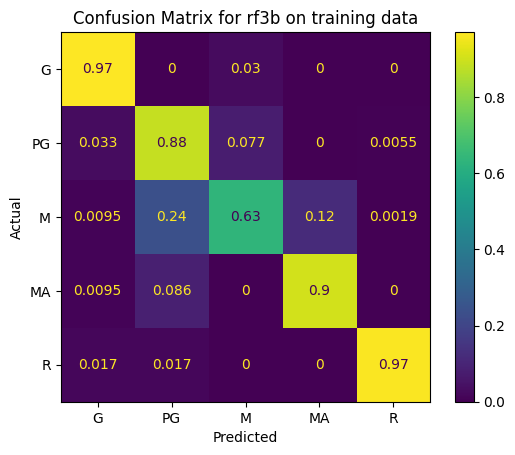

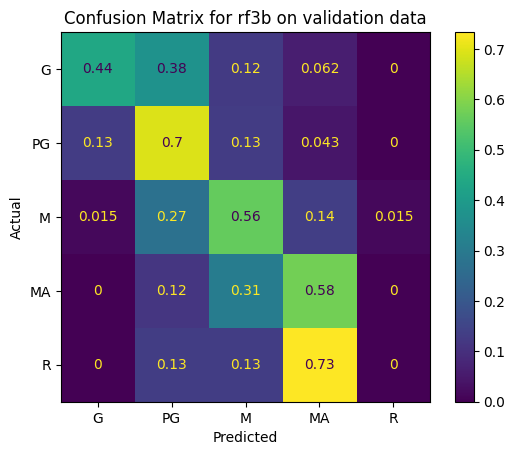

In [185]:
rf3b = plant_forest(
    "rf3b",
    n_estimators=500,
    max_depth=5, 
    min_samples_leaf=16,
    class_weight='balanced',
    max_features=0.1    
)

Again, results are still better with 1000 estimators, so we may as well go for broke and try 2500. 

c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.83      0.97      0.90        67
           1       0.55      0.90      0.68       182
           2       0.96      0.64      0.77       526
           3       0.62      0.90      0.73       105
           4       0.98      0.98      0.98        59

    accuracy                           0.76       939
   macro avg       0.79      0.88      0.81       939
weighted avg       0.83      0.76      0.77       939


              precision    recall  f1-score   support

           0       0.47      0.44      0.45        16
           1       0.41      0.70      0.51        46
           2       0.80      0.56      0.66       132
           3       0.33      0.58      0.42        26
           4       0.33      0.07      0.11        15

    accuracy                           0.55       235
   macro avg       0.47      0.47      0.43       235
weighted avg       0.62      0.55      0.56       235


Accuracy Generalizat

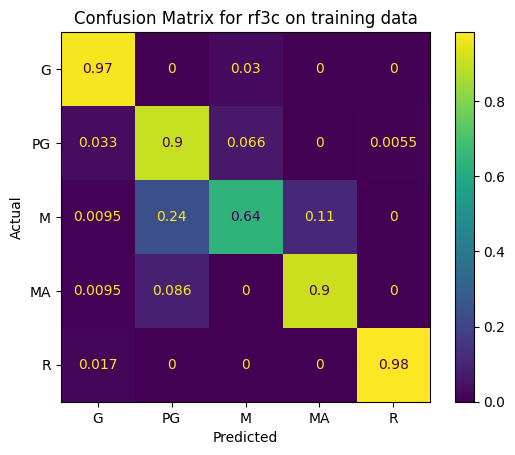

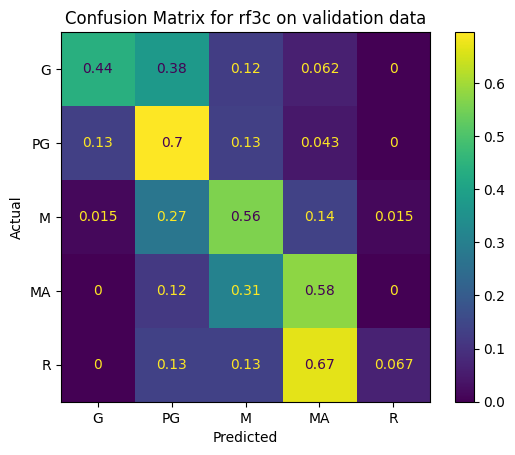

In [186]:
rf3c = plant_forest(
    "rf3c",
    n_estimators=1000,
    max_depth=5, 
    min_samples_leaf=16,
    class_weight='balanced',
    max_features=0.1    
)

performance declines at 2500, so most likely optimal n_estimators roughly between 1000 and 2000. 

c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.82      0.97      0.89        67
           1       0.55      0.89      0.68       182
           2       0.96      0.64      0.77       526
           3       0.62      0.90      0.73       105
           4       0.98      0.98      0.98        59

    accuracy                           0.76       939
   macro avg       0.79      0.88      0.81       939
weighted avg       0.83      0.76      0.77       939


              precision    recall  f1-score   support

           0       0.47      0.44      0.45        16
           1       0.41      0.70      0.51        46
           2       0.80      0.55      0.65       132
           3       0.31      0.58      0.40        26
           4       0.00      0.00      0.00        15

    accuracy                           0.54       235
   macro avg       0.40      0.45      0.40       235
weighted avg       0.60      0.54      0.54       235


Accuracy Generalizat

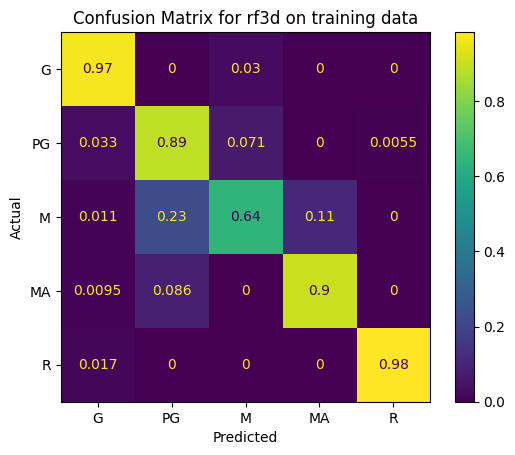

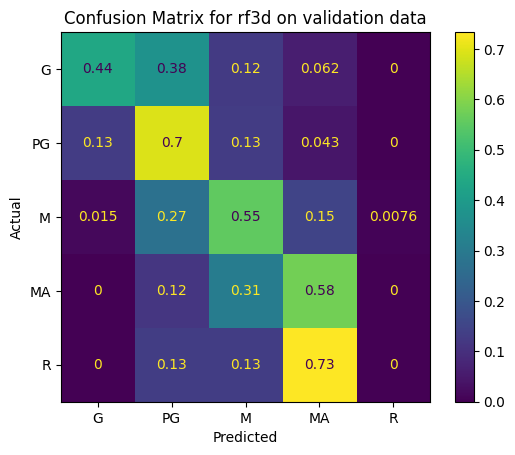

In [187]:
rf3d = plant_forest(
    "rf3d",
    n_estimators=2500,
    max_depth=5, 
    min_samples_leaf=16,
    class_weight='balanced',
    max_features=0.1    
)

Let's try n_estimators=50 to see if there are better results going in the other direction. 

worse result on all measures. optimal n_estimators likely between 1000 and 2000. 

c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.76      0.99      0.86        67
           1       0.53      0.84      0.65       182
           2       0.93      0.61      0.74       526
           3       0.61      0.91      0.73       105
           4       0.88      0.95      0.91        59

    accuracy                           0.74       939
   macro avg       0.74      0.86      0.78       939
weighted avg       0.80      0.74      0.74       939


              precision    recall  f1-score   support

           0       0.46      0.38      0.41        16
           1       0.40      0.74      0.52        46
           2       0.77      0.49      0.60       132
           3       0.28      0.58      0.38        26
           4       0.00      0.00      0.00        15

    accuracy                           0.51       235
   macro avg       0.38      0.44      0.38       235
weighted avg       0.58      0.51      0.51       235


Accuracy Generalizat

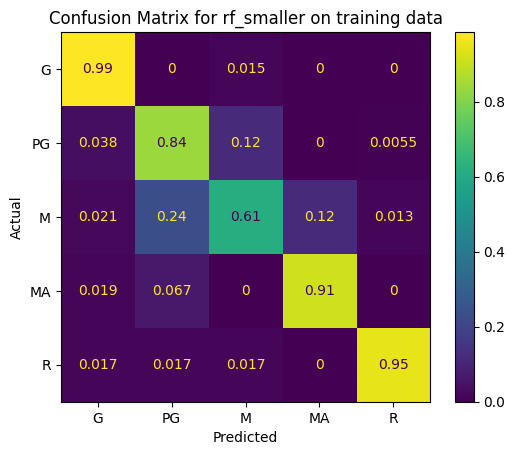

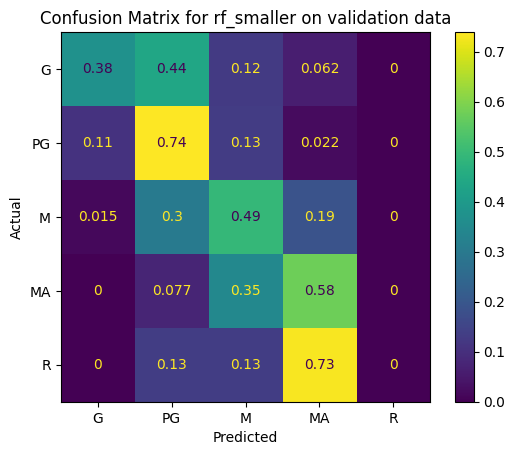

In [188]:
rf_smaller = plant_forest(
    "rf_smaller",
    n_estimators=50,
    max_depth=5,
    min_samples_leaf=16,
    class_weight='balanced',
    max_features=0.1
)

In [189]:
val_FNs = []
val_FPs = []

for cm in cm_val_list:
  val_FNs.append(cm[0][1])
  val_FPs.append(cm[1][0])

rf_eval = pd.DataFrame({
    'Model': model_names_list,
    'No. Estimators': number_of_estimators_list,
    'Max Depth': max_depth_list,
    'Avg Depth': avg_depth_list,
    'Min Samples Leaf': min_samples_leaf_list,
    'Max Features': max_features_list,
    'Class Weight': class_weights,
    'Train Accuracy': training_accuracy_list,
    'Train Precision': training_precision_list,
    'Train Recall': training_recall_list,
    'Train F1': training_f1_list,
    'Validation FNs': val_FNs,
    'Validation FPs': val_FPs,
    'Validation Accuracy': validation_accuracy_list,
    'Validation Precision': validation_precision_list,
    'Validation Recall': validation_recall_list,
    'Validation F1': validation_f1_list,
    'Accuracy Generalization Loss': accuracy_losses_list,
    'Precision Generalization Loss': precision_losses_list,
    'Recall Generalization Loss': recall_losses_list,
    'F1 Generalization Loss': f1_losses_list
})

rf_eval.fillna("None", inplace=True)

rf_f1_results = rf_eval.sort_values('Validation F1', ascending=False)
rf_f1_results

C:\Users\bened\AppData\Local\Temp\ipykernel_19444\3812536347.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'None' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  rf_eval.fillna("None", inplace=True)


,Model,No. Estimators,Max Depth,Avg Depth,Min Samples Leaf,Max Features,Class Weight,Train Accuracy,Train Precision,Train Recall,...,Validation FNs,Validation FPs,Validation Accuracy,Validation Precision,Validation Recall,Validation F1,Accuracy Generalization Loss,Precision Generalization Loss,Recall Generalization Loss,F1 Generalization Loss
17,rf1_shallower,100,5.0,5.00,1,None,balanced,0.795527,0.847947,0.795527,...,7,2,0.561702,0.592483,0.561702,0.556573,0.233825,0.255464,0.233825,0.245766
27,rf3c,1000,5.0,5.00,16,0.1,balanced,0.763578,0.833990,0.763578,...,6,6,0.548936,0.620220,0.548936,0.555285,0.214642,0.213770,0.214642,0.213842
26,rf3b,500,5.0,5.00,16,0.1,balanced,0.758253,0.828170,0.758253,...,6,6,0.544681,0.598176,0.544681,0.547562,0.213573,0.229994,0.213573,0.216207
15,rf1a,100,5.0,5.00,1,0.1,balanced,0.833866,0.877244,0.833866,...,8,5,0.548936,0.565350,0.548936,0.543576,0.284930,0.311894,0.284930,0.296905
28,rf3d,2500,5.0,5.00,16,0.1,balanced,0.764643,0.832624,0.764643,...,6,6,0.540426,0.595527,0.540426,0.542976,0.224218,0.237097,0.224218,0.227088
25,rf3a,250,5.0,5.00,16,0.1,balanced,0.776358,0.836140,0.776358,...,6,6,0.531915,0.607603,0.531915,0.539601,0.244443,0.228537,0.244443,0.241733
24,rf3,100,5.0,5.00,16,0.1,balanced,0.744409,0.816843,0.744409,...,6,6,0.531915,0.589604,0.531915,0.532639,0.212494,0.227239,0.212494,0.217105
16,rf1b,100,5.0,5.00,1,0.5,balanced,0.832801,0.868167,0.832801,...,7,4,0.523404,0.531171,0.523404,0.516775,0.309397,0.336995,0.309397,0.321465
21,rf2a,100,None,10.88,16,sqrt,balanced,0.930777,0.938213,0.930777,...,8,7,0.519149,0.509547,0.519149,0.513350,0.411628,0.428666,0.411628,0.418027
29,rf_smaller,50,5.0,5.00,16,0.1,balanced,0.736954,0.802170,0.736954,...,7,5,0.510638,0.575685,0.510638,0.509857,0.226316,0.226485,0.226316,0.230337


### GridSearch

free up RAM 

In [184]:
del bigrams, bigrams_dict, bigrams_df, data, df_aus, dt, dt_balanced, entropic_forest, feature_names, filtered_sent, filtered_sents, js_sents, log_forest, lr, lr_balanced, preds_dt_balanced_train, preds_dt_balanced_val, preds_dt_train, preds_dt_val, preds_svc_train, preds_svc_val, preds_train_lr, preds_train_lr_balanced, preds_val_lr, preds_val_lr_balanced, rf, rf_balanced, rf_gini, rf_log2, rf_log2_shallow, rf_shallow, rf_shallow1, rf_shallower, rf_smaller, rf_Xshallow, rf1, rf1_shallower, rf1a, rf1b, rf2, rf2a, rf2b, rf2c, rf3, rf3a, rf3b, rf3c, rf3d, screenplays_annot, sent, sents, sents_data, svc, svc_balanced, trigrams, trigrams_df, trigrams_dict, val

NameError: name 'bigrams' is not defined

In [191]:
from sklearn.model_selection import GridSearchCV 

rf_def = RandomForestClassifier(class_weight='balanced')  

params = {
    'max_depth': np.arange(4, 8, 1),
    'min_samples_leaf': np.arange(9, 16, 2),
    'max_features': np.arange(0.1, 0.5, 0.1),
    'n_estimators': np.arange(1000, 2000, 250)
}

gs = GridSearchCV(rf_def, params, scoring='f1_weighted', n_jobs=-1, verbose=4)

rf_gs = gs.fit(X_data, y_data)

print(rf_gs.best_params_)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


KeyboardInterrupt: 

### BayesianSearch

In [186]:
! pip install scikit-optimize

execution time of over 300m at the 8th candidate. 

In [192]:
from skopt import BayesSearchCV, space
from sklearn.ensemble import RandomForestClassifier 

bayes_grid = {
    'max_depth': space.Integer(4, 7),
    'min_samples_leaf': space.Integer(9, 15),
    'max_features': space.Real(0.1, 0.4),
    'n_estimators': space.Integer(1000, 2000)
}
rf_def = RandomForestClassifier(class_weight='balanced')  

bayes_search = BayesSearchCV(
    rf_def, 
    bayes_grid,
    scoring='f1_weighted',
    random_state=1,
    verbose=10
)

rf_bayes = bayes_search.fit(X_data, y_data)

print(rf_bayes.get_params())

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START max_depth=6, max_features=0.11849551954426699, min_samples_leaf=11, n_estimators=1146
[CV 1/5; 1/1] END max_depth=6, max_features=0.11849551954426699, min_samples_leaf=11, n_estimators=1146;, score=0.296 total time= 3.2min
[CV 2/5; 1/1] START max_depth=6, max_features=0.11849551954426699, min_samples_leaf=11, n_estimators=1146
[CV 2/5; 1/1] END max_depth=6, max_features=0.11849551954426699, min_samples_leaf=11, n_estimators=1146;, score=0.301 total time= 3.1min
[CV 3/5; 1/1] START max_depth=6, max_features=0.11849551954426699, min_samples_leaf=11, n_estimators=1146
[CV 3/5; 1/1] END max_depth=6, max_features=0.11849551954426699, min_samples_leaf=11, n_estimators=1146;, score=0.317 total time= 3.2min
[CV 4/5; 1/1] START max_depth=6, max_features=0.11849551954426699, min_samples_leaf=11, n_estimators=1146
[CV 4/5; 1/1] END max_depth=6, max_features=0.11849551954426699, min_samples_leaf=11, n_estimators=1146;, 

KeyboardInterrupt: 

## 4.5 Testing and Evaluation

### 5.5.1 Logistic Regression 

In [99]:
results_data = {} 

def test_model(model, name): 
    test_preds = model.predict(X_test) 
    test_accuracy = accuracy_score(y_test, test_preds) 
    test_f1 = f1_score(y_test, test_preds, average='weighted') 
    results_data[name] = [test_accuracy, test_f1]
    CM = ConfusionMatrixDisplay.from_predictions(y_test, test_preds, normalize='true') 
    print(classification_report(y_test, test_preds))
    print("") 
    configure_CM(CM, f"Test Confusion Matrix for {name}")

              precision    recall  f1-score   support

           0       0.09      0.10      0.09        21
           1       0.22      0.23      0.22        53
           2       0.49      0.53      0.51       146
           3       0.11      0.09      0.10        34
           4       0.14      0.09      0.11        22

    accuracy                           0.35       276
   macro avg       0.21      0.21      0.21       276
weighted avg       0.33      0.35      0.34       276




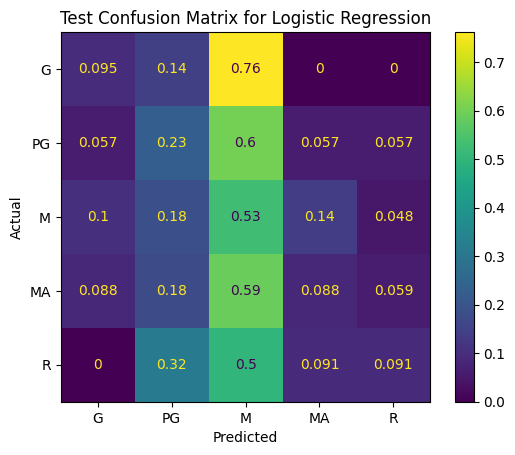

In [102]:
test_model(lr_balanced, "Logistic Regression")

              precision    recall  f1-score   support

           0       0.05      0.05      0.05        21
           1       0.14      0.15      0.15        53
           2       0.51      0.51      0.51       146
           3       0.15      0.15      0.15        34
           4       0.05      0.05      0.05        22

    accuracy                           0.32       276
   macro avg       0.18      0.18      0.18       276
weighted avg       0.32      0.32      0.32       276




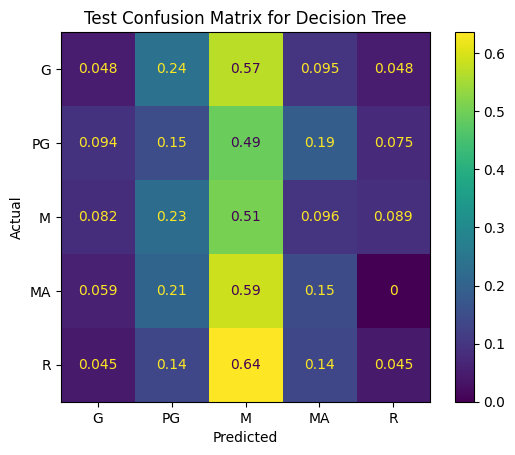

In [103]:
test_model(dt_balanced, "Decision Tree")

In [104]:
test_model(svc_balanced, "Support Vector Classifier")

ValueError: X has 98136 features, but SVC is expecting 2 features as input.

# 5. Word2Vec Approach 

## 5.0 Building Continuous Bag of Words (CBOW) Model

In [147]:
# truncate repetitions from sents to reduce resulting vocab size 
filtered_sents = [] 
for sent in sents: 
    filtered_sent = [truncate_repetitions(token) for token in sent]
    filtered_sents.append(filtered_sent)

In [148]:
from gensim.models import Word2Vec 

cbow = Word2Vec(
    sentences=trigram_phraser[filtered_sents],
    vector_size=128,
    sg=0
)

word_vectors = cbow.wv 

## 5.1 Analyzing CBOW Model

In [149]:
wv_vocab = list(word_vectors.key_to_index.keys())
print(wv_vocab[:100])
print("Size of vocab:", len(wv_vocab))

['look', 'go', 'get', 'see', 'know', 'back', 'come', 'take', 'one', 'turn', 'hand', 'say', 'think', 'man', 'well', 'right', 'want', 'make', 'face', 'move', 'walk', 'stand', 'eye', 'head', 'two', 'room', 'tell', 'start', 'door', '_', 'way', 'stop', 'pull', 'time', 'watch', 'sit', 'car', 'hold', 'leave', 'give', 'try', 'run', 'good', 'still', 'smile', 'hear', 'let', 'open', 'find', 'put', 'little', 'thing', 'talk', 'away', 'call', 'stare', 'work', 'oh', 'close', 'beat', 'people', 'guy', 'day', 'never', 'window', 'really', 'step', ':', 'house', 'wait', 'like', 'light', 'long', 'keep', 'yes', 'even', 'suddenly', 'moment', 'place', 'side', 'front', 'okay', 'follow', 'need', 'first', 'boy', 'enter', 'begin', "'s", 'feel', 'continue', 'yeah', 'old', 'table', 'love', 'help', 'girl', 'reach', 'mean', "'_m"]
Size of vocab: 97721


We will take an example from our six "classifiable elements". 

The first being 'language'

In [150]:
def find_synonyms(vectors, word, topn=5):
    synonyms = vectors.most_similar(word, topn=topn)
    print(f"Words most similar to {word}:")
    for w, s in synonyms:
        print(f'{w}: {s:.4f}')

find_synonyms(word_vectors, 'fuck')

Words most similar to fuck:
fucking: 0.8956
fuck_fuck: 0.8797
piece_shit: 0.8263
asshole: 0.8215
shut_fuck: 0.7968


Now depictions of sex

In [151]:
find_synonyms(word_vectors, 'sex', 5)

Words most similar to sex:
lesbian: 0.6832
obsess: 0.6774
relationship: 0.6513
first_date: 0.6310
fantasize: 0.6268


Drug use

In [152]:
find_synonyms(word_vectors, 'cocaine', 5)

Words most similar to cocaine:
heroin: 0.8662
packet: 0.7224
condom: 0.7157
alcohol: 0.7039
vitamin: 0.7017


Nudity

In [153]:
find_synonyms(word_vectors, 'naked', 5)

Words most similar to naked:
nude: 0.7635
half_naked: 0.6998
wrap_towel: 0.6479
naked_body: 0.6435
shirtless: 0.6397


And finally 'themes'

In [154]:
find_synonyms(word_vectors, 'rape', 5)

Words most similar to rape:
murder: 0.7876
murderer: 0.7792
kidnap: 0.7692
commit_suicide: 0.7356
accuse: 0.7215


In [155]:
find_synonyms(word_vectors, 'schizophrenia', 5)

Words most similar to schizophrenia:
traumatic: 0.8317
schizophrenic: 0.8242
intellectually: 0.8179
cognitive: 0.8174
tenet: 0.8173


In [161]:
cbow.save(r"C:\\Users\bened\DataScience\ANLP\AT2\\models\\cbow_final.model")

### Mean Vectors Approach 

On previous attempts with Word2Vec, the size of the featurespace ended up being too large to be computationally feasible. To deal with this, we doubled the number of vector dimensions to 128, but then reduced each document to its mean vector representation. 

First we re-split X_filtered into training, testing and validation sets with the same random_state seed as before.

In [156]:
X_data, X_test, y_data, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=1, stratify=y_data)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(1208,)
(1208,)
(302,)
(302,)
(378,)
(378,)


In [174]:
def get_mean_vectors(tokens, word_vectors):
    vectors = [word_vectors[word] for word in tokens if word in word_vectors]
    if len(vectors) == 0: 
        return np.zeros(word_vectors.vector_size)
    else:
        return np.mean(vectors, axis=0)

train_vectors = X_train.apply(lambda tokens: get_mean_vectors(tokens, word_vectors))
val_vectors = X_val.apply(lambda tokens: get_mean_vectors(tokens, word_vectors))
test_vectors = X_test.apply(lambda tokens: get_mean_vectors(tokens, word_vectors))

In [175]:
X_train_wv = np.array(train_vectors.tolist())
X_val_wv = np.array(val_vectors.tolist())
X_test_wv = np.array(test_vectors.tolist())

print(X_train_wv.shape)
print(X_val_wv.shape)
print(X_test_wv.shape)

(1208, 128)
(302, 128)
(378, 128)


Now we run some traditional ML models again to see if performance with w2v is any better than TFIDF. 

In [158]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

results_dict = {
    'Model Type': [],
    'Training Accuracy': [],
    'Training Recall': [],
    'Training Precision': [],
    'Training F1': [],
    'Validation Accuracy': [],
    'Validation Recall': [],
    'Validation Precision': [],
    'Validation F1': []
}

In [159]:
def store_results(model_name, train_preds, val_preds):

  train_accuracy = accuracy_score(y_train, train_preds)
  train_precision = precision_score(y_train, train_preds, average='weighted')
  train_recall = recall_score(y_train, train_preds, average='weighted')
  train_f1 = f1_score(y_train, train_preds, average='weighted')

  val_accuracy = accuracy_score(y_val, val_preds)
  val_precision = precision_score(y_val, val_preds, average='weighted')
  val_recall = recall_score(y_val, val_preds, average='weighted')
  val_f1 = f1_score(y_val, val_preds, average='weighted')

  results_dict['Model Type'].append(model_name)
  results_dict['Training Accuracy'].append(train_accuracy)
  results_dict['Training Precision'].append(train_precision)
  results_dict['Training Recall'].append(train_recall)
  results_dict['Training F1'].append(train_f1)
  results_dict['Validation Accuracy'].append(val_accuracy)
  results_dict['Validation Precision'].append(val_precision)
  results_dict['Validation Recall'].append(val_recall)
  results_dict['Validation F1'].append(val_f1)

In [160]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

Free up RAM 

In [162]:
del bigram_counts, bigram_select_counts, bigram_select_phraser, bigram_select_sentences, bigram_sentences, bigrams, bigrams_df, bigrams_df_select, bigrams_dict, bigrams_select, bigrams_dict_select, cbow, clean_data, data, data_series, df, df_aus, df_clean, df_meta, feature_names, trigram_counts, trigram_model, trigram_sents, trigrams, trigrams_df, trigrams_dict

In [176]:
lr = LogisticRegression()
lr.fit(X_train_wv, y_train)
preds_train_lr = lr.predict(X_train_wv)
preds_val_lr = lr.predict(X_val_wv)

store_results("LR_wv", preds_train_lr, preds_val_lr)

print("Classifcation report on training data:")
print(classification_report(y_train, preds_train_lr))
print("Classification report on validation data:")
print(classification_report(y_val, preds_val_lr))

Classifcation report on training data:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        57
           1       0.00      0.00      0.00       213
           2       0.48      0.98      0.64       561
           3       0.56      0.09      0.16       311
           4       0.00      0.00      0.00        66

    accuracy                           0.48      1208
   macro avg       0.21      0.21      0.16      1208
weighted avg       0.37      0.48      0.34      1208

Classification report on validation data:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.50      0.02      0.04        54
           2       0.47      0.95      0.63       140
           3       0.41      0.09      0.15        78
           4       0.00      0.00      0.00        16

    accuracy                           0.47       302
   macro avg       0.28      0.21      0.16       

c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is 

In [ ]:
lr = LogisticRegression()
lr.fit(X_train_wv, y_train)
preds_train_lr_balanced = lr_balanced.predict(X_train_wv)
preds_val_lr_balanced = lr_balanced.predict(X_val_wv)

store_results("LR_balanced_wv", preds_train_lr_balanced, preds_val_lr_balanced)

print("Classifcation report on training data:")
print(classification_report(y_train, preds_train_lr_balanced))
print("Classification report on validation data:")
print(classification_report(y_val, preds_val_lr_balanced))

ConfusionMatrixDisplay.from_predictions(y_train, preds_train_lr_balanced, normalize='true')
ConfusionMatrixDisplay.from_predictions(y_val, preds_val_lr_balanced, normalize='true')

c:\Users\bened\anaconda3\envs\spacy_env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classifcation report on training data:
              precision    recall  f1-score   support

           0       0.14      0.68      0.23        57
           1       0.30      0.40      0.34       213
           2       0.59      0.22      0.32       561
           3       0.39      0.23      0.29       311
           4       0.14      0.56      0.23        66

    accuracy                           0.29      1208
   macro avg       0.31      0.42      0.28      1208
weighted avg       0.44      0.29      0.31      1208

Classification report on validation data:
              precision    recall  f1-score   support

           0       0.13      0.64      0.21        14
           1       0.23      0.28      0.25        54
           2       0.44      0.19      0.27       140
           3       0.30      0.18      0.23        78
           4       0.02      0.06      0.03        16

    accuracy                           0.22       302
   macro avg       0.22      0.27      0.20       

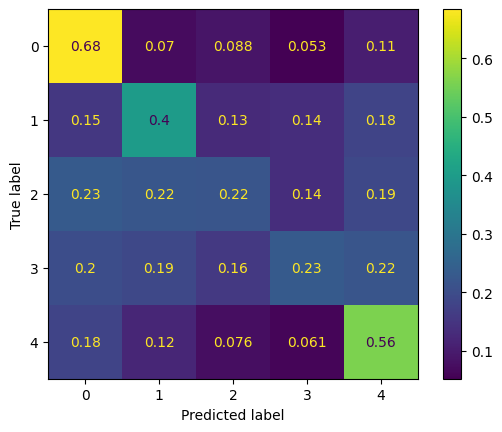

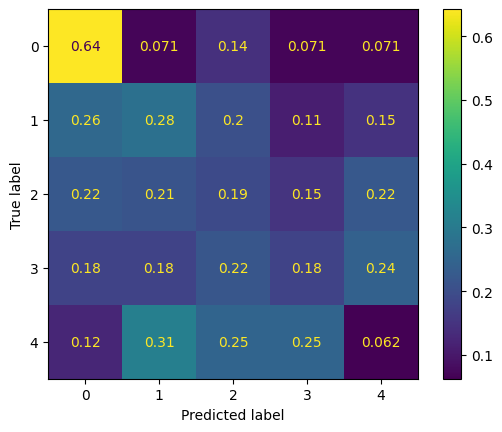

In [177]:
lr_balanced = LogisticRegression(class_weight='balanced')
lr_balanced.fit(X_train_wv, y_train)
preds_train_lr_balanced = lr_balanced.predict(X_train_wv)
preds_val_lr_balanced = lr_balanced.predict(X_val_wv)

store_results("LR_balanced_wv", preds_train_lr_balanced, preds_val_lr_balanced)

print("Classifcation report on training data:")
print(classification_report(y_train, preds_train_lr_balanced))
print("Classification report on validation data:")
print(classification_report(y_val, preds_val_lr_balanced))

ConfusionMatrixDisplay.from_predictions(y_train, preds_train_lr_balanced, normalize='true')
ConfusionMatrixDisplay.from_predictions(y_val, preds_val_lr_balanced, normalize='true')

Classification report for DT_balanced on training data:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        57
           1       0.99      1.00      1.00       213
           2       1.00      0.99      1.00       561
           3       0.99      0.99      0.99       311
           4       1.00      1.00      1.00        66

    accuracy                           0.99      1208
   macro avg       0.99      1.00      0.99      1208
weighted avg       0.99      0.99      0.99      1208

Classification report for DT on validation data:
              precision    recall  f1-score   support

           0       0.08      0.07      0.07        14
           1       0.23      0.22      0.22        54
           2       0.47      0.43      0.45       140
           3       0.29      0.31      0.30        78
           4       0.00      0.00      0.00        16

    accuracy                           0.32       302
   macro avg       0.21   

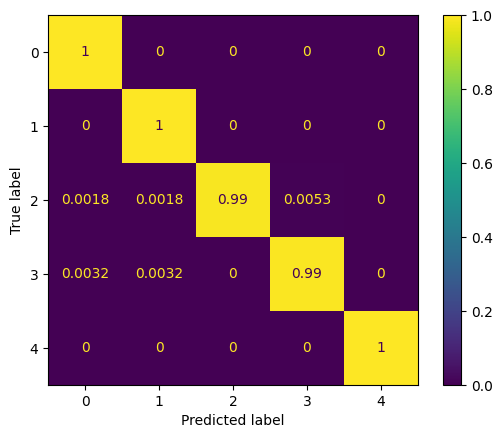

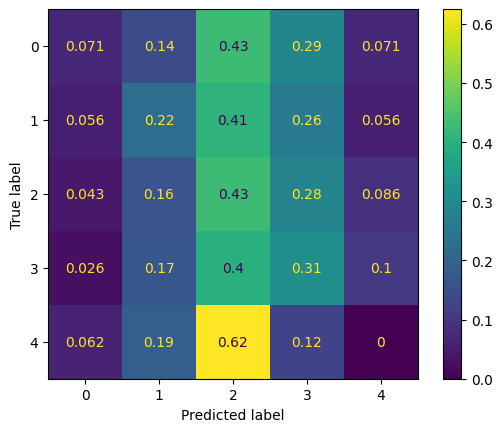

In [180]:
from sklearn.tree import DecisionTreeClassifier

dt_balanced = DecisionTreeClassifier(class_weight='balanced')
dt_balanced.fit(X_train_wv, y_train)
preds_dt_balanced_train = dt_balanced.predict(X_train_wv)
preds_dt_balanced_val = dt_balanced.predict(X_val_wv)
print("Classification report for DT_balanced on training data:")
print(classification_report(y_train, preds_dt_balanced_train))
print("Classification report for DT on validation data:")
print(classification_report(y_val, preds_dt_balanced_val))

store_results("DT_balanced_wv", preds_dt_balanced_train, preds_dt_balanced_val)

ConfusionMatrixDisplay.from_predictions(y_train, preds_dt_balanced_train, normalize='true')
ConfusionMatrixDisplay.from_predictions(y_val, preds_dt_balanced_val, normalize='true')

results are worse than the TFIDF equivalent model.

Classification report for SVC_balanced on training data:
              precision    recall  f1-score   support

           0       0.12      0.51      0.19        57
           1       0.25      0.38      0.30       213
           2       0.51      0.30      0.38       561
           3       0.36      0.03      0.05       311
           4       0.12      0.52      0.19        66

    accuracy                           0.26      1208
   macro avg       0.27      0.34      0.22      1208
weighted avg       0.39      0.26      0.26      1208

Classification report for SVC_balanced on validation_data:
              precision    recall  f1-score   support

           0       0.10      0.43      0.16        14
           1       0.20      0.35      0.26        54
           2       0.40      0.23      0.29       140
           3       0.60      0.04      0.07        78
           4       0.03      0.12      0.05        16

    accuracy                           0.21       302
   macro avg   

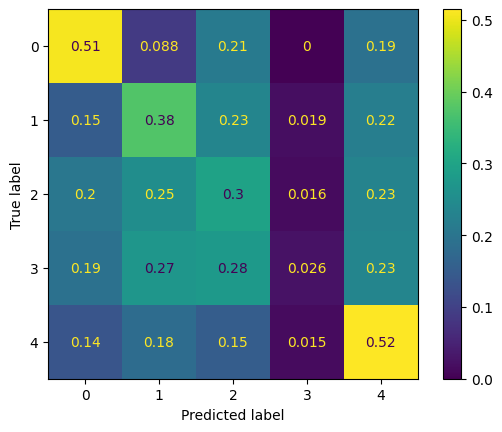

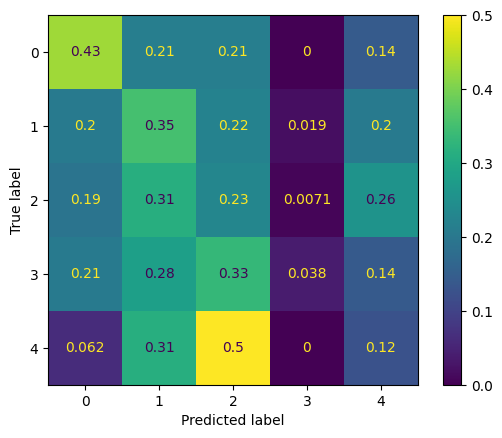

In [183]:
from sklearn.svm import SVC

svc_balanced = SVC(class_weight='balanced')
svc_balanced.fit(X_train_wv, y_train)
preds_svc_train = svc_balanced.predict(X_train_wv)
preds_svc_val = svc_balanced.predict(X_val_wv)
print("Classification report for SVC_balanced on training data:")
print(classification_report(y_train, preds_svc_train))
print("Classification report for SVC_balanced on validation_data:")
print(classification_report(y_val, preds_svc_val))

store_results("SVC_balanced_wv", preds_svc_train, preds_svc_val)

ConfusionMatrixDisplay.from_predictions(y_train, preds_svc_train, normalize='true')
ConfusionMatrixDisplay.from_predictions(y_val, preds_svc_val, normalize='true')

Results much worse than TFIDF equivalent model. 

# 6. Deep Learning Approaches

## 6.0 Data Preparation

In [ ]:
# create a corpus of tokens from trigrams_phraser[filtered_sents]
corpus_tokens = [] 
for sent in filtered_sents: 
    tokens = trigram_phraser[sent]
    corpus_tokens.append(tokens) 

In [ ]:
def create_vocab(corpus): 
    vocab = set() 
    for tokens in corpus:
        vocab.update(tokens) 
    return {word: idx + 1 for idx, word in enumerate(vocab)} 

vocab = create_vocab(corpus_tokens)
print("size of vocabulary:", len(vocab))

In [ ]:
def sents_to_seqs(screenplay, vocab): 
    return [[vocab[token] for token in tokens] for sents in screenplay]

X_train_seq = sents_to_seqs(X_data['screenplay'], vocab) 
X_test_seq = sents_to_seqs(X_test['screenplay'], vocab) 

In [ ]:
# average sequence length 
import numpy as np

avg_seq_length_train = np.mean([len(seq) for seq in X_train_seq])
avg_seq_length_test = np.mean([len(seq) for seq in X_test_seq])

print("Train avg. sequence length:", avg_seq_length_train)
print("Test avg sequence length:", avg_seq_length_test)
print("\nTrain max sequence length:", np.max([len(seq) for seq in X_train_seq]))
print("Test max sequence length:", np.max([len(seq) for seq in X_test_seq]))

In [ ]:
X_combined = X_train_seq + X_test_seq
seq_lengths = np.array([len(seq) for seq in X_combined])
se = np.mean(seq_lengths) + 2 * np.std(seq_lengths)
print(f"Sequence lengths fall below {se} with 95% confidence")

In [ ]:
max_seq = 

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_padded = pad_sequences(X_train_seq, maxlen=max_seq, padding='post', truncating='pre')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_seq, padding='post', truncating='pre')

In [ ]:
embeddings_dict = dict()

glove_path = r"C:\\Users\bened\DataScience\ANLP\AT2\\glove.6B.100d.txt"

glove_file = open(glove_path, encoding='utf-8')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dims = np.asarray(records[1:], dtype='float32')
    embeddings_dict[word] = vector_dims

glove_file.close()

In [ ]:
embedding_matrix = np.zeros((len(vocab), 100))
for word, index in vocab.items():
    vector = embeddings_dict.get(word)
    if vector is not None:
        embedding_matrix[index] = vector

print(embedding_matrix.shape)

## 6.2 Feed-Forward Neural Network

### 6.2.0 Custom Architecture

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers

maxlen=15000

# input for text data 
text_input = layers.Input(shape=(maxlen,), name='screenplay_input')

# densely connected layer that tries to boil down feature space to six classifiable elements
dense = layers.Dense(6, activation='relu', name='classifiable_elements')(text_input)

def one_to_one(inputs):
    return layers.multiply(inputs)

impact_units = [layers.Dense(1, activation='relu', name=f"Impact_score_{i}")(layers.Lambda(lambda x: x[:,i:i+1])(dense)) for i in range(6)]

# concatenate 1:1 impact scores
impact_scores = layers.concatenate(impact_units)

# year 
year_input = layers.Input(shape=(1,),name='year_input')

# concatenate impact scores with year input
merged = layers.concatenate([impact_scores, year_input])

# output layer 
output = layers.Dense(5, activation='softmax', name='output_layer')(merged)

ff = Model(inputs=[text_input, year_input], outputs=output)

ff.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['f1_score'])

ff.summary()

In [ ]:
ff_history = ff.fit(
    [X_train_padded, X_train_year], 
    y_train,
    validation_data=([X_test_padded, X_test_year], y_test)
)

In [ ]:
score = ff.evaluate(X_test, y_test, verbose=1)

print("Test Loss:", score[0])
print("Test F1:", score[1])

### 6.2.1 Simple FF Sequential

In [ ]:
snn = Sequential() 
embedding_layer = layers.Embedding(len(vocab), 100, weights=[embedding_matrix], trainable=False) 
snn.add(embedding_layer) 
snn.add(Flatten()) 
snn.add(Dense(5, activation='softmax'))

snn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['f1_score']) 
print(snn.summary()) 

In [ ]:
snn_history = snn.fit(
    X_train, 
    y_train, 
    batch_size=64, 
    epochs=6, 
    verbose=1, 
    validation_split=0.2
)

## 6.3 LSTM 

In [ ]:
text_input = layers.Input(shape=(maxlen,),name='screenplay_input')

embedding_layer = layers.Embedding(len(vocab), 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)(text_input)

lstm_layer = layers.LSTM(64, return_sequences=False)(embedding_layer)

dense_1 = layers.Dense(6, activation='relu')(lstm_layer)
dense_2 = layers.Dense(6, activation='relu')(dense_1)

year_input = layers.Input(shape=(1,),name='year_input')

merged = layers.concatenate([dense_2, year_input])

output = layers.Dense(5, activation='softmax')(merged)

model = Model(inputs=[text_input, year_input],outputs=output)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['f1_score'])

model.summary()

In [ ]:
lstm_history = model.fit(
    [X_train_padded, X_train['year']], 
    y_train,
    validation_data=([X_test_padded, X_test['year']], y_test),
    epochs=10, batch_size=64)

In [ ]:
embedding_layer = layers.Embedding(len(vocab), 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)(text_input)

lstm_layer = layers.LSTM(64, return_sequences=False)(embedding_layer)

dense_1 = layers.Dense(6, activation='relu')(lstm_layer)
dense_2 = layers.Dense(6, activation='relu')(dense_1)

year_input = layers.Input(shape=(1,),name='year_input')

merged = layers.concatenate([dense_2, year_input])

output = layers.Dense(5, activation='softmax')(merged)

model = Model(inputs=[text_input, year_input],outputs=output)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()